In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [5]:
binning_method='healpix'
nside=8
bin_space='azel'
specific_years=[2014]
# specific_months=[12],
# specific_days=[15, 16, 17],
include_default_features=True
include_bin_features=False
do_z_score_norm=True
do_cyclical_norm=True

In [ ]:
# radec, time --> az, el


In [11]:
dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    # specific_months=[12],
    # specific_days=[15, 16, 17],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

## Check that normalizations are working

In [19]:
for i, feat_name in enumerate(dataset.state_feature_names):
    print(feat_name, (dataset._df[feat_name].to_numpy() == dataset.next_states[:, i]).all())


ra_cos tensor(True)
ra_sin tensor(True)
dec tensor(False)
az_cos tensor(True)
az_sin tensor(True)
el tensor(False)
airmass tensor(False)
ha_cos tensor(True)
ha_sin tensor(True)
sun_ra_cos tensor(True)
sun_ra_sin tensor(True)
sun_dec tensor(False)
sun_az_cos tensor(True)
sun_az_sin tensor(True)
sun_el tensor(False)
moon_ra_cos tensor(True)
moon_ra_sin tensor(True)
moon_dec tensor(False)
moon_az_cos tensor(True)
moon_az_sin tensor(True)
moon_el tensor(False)
time_fraction_since_start tensor(False)


# Visualize dataset in az, el and ra, dec

In [21]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

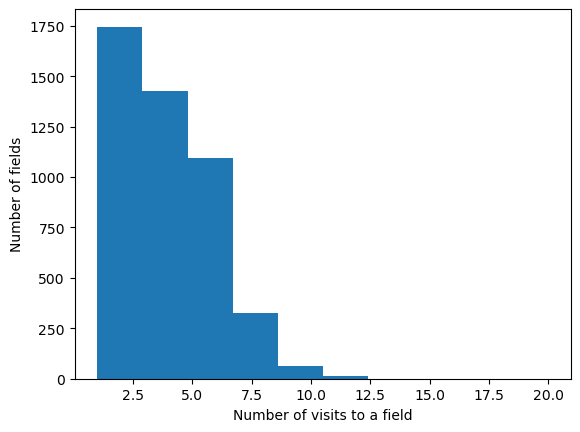

In [22]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

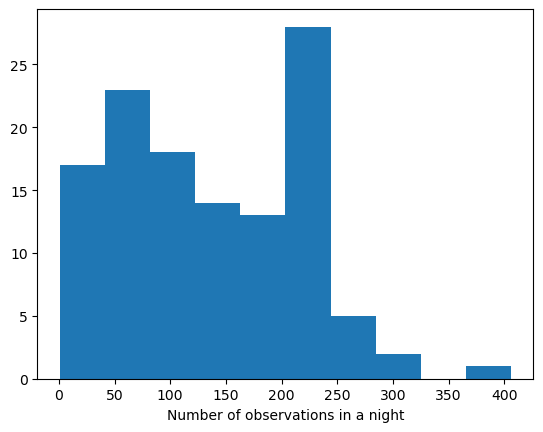

In [23]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

# Train

In [26]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [27]:
dataset.do_z_score_norm

True

In [28]:
dataset.do_cyclical_norm

True

In [30]:
"""Algorithm and Train setup"""
exp_name_prefix = 'azel_zscore_on_Cyclical_on_'

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 128,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 10,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Train

In [31]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [32]:
try:
    agent.load(filepath=outdir + 'weights.pt')
except:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s')

  0%|                                                | 0/165470 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  0%|                                     | 105/165470 [00:00<06:20, 434.29it/s]

Train step 0: Accuracy = 0.000, Loss = 6.6761, Q-val=0.000
Train step 100: Accuracy = 0.188, Loss = 2.9601, Q-val=0.000
Train step 200: Accuracy = 0.344, Loss = 1.9608, Q-val=0.000


  0%|                                     | 452/165470 [00:00<02:52, 959.02it/s]

Train step 300: Accuracy = 0.375, Loss = 2.0974, Q-val=0.000
Train step 400: Accuracy = 0.469, Loss = 1.9222, Q-val=0.000
Train step 500: Accuracy = 0.500, Loss = 2.4419, Q-val=0.000


  0%|▏                                   | 799/165470 [00:00<02:33, 1075.95it/s]

Train step 600: Accuracy = 0.562, Loss = 1.6788, Q-val=0.000
Train step 700: Accuracy = 0.500, Loss = 1.7909, Q-val=0.000
Train step 800: Accuracy = 0.531, Loss = 1.5997, Q-val=0.000


  1%|▏                                  | 1019/165470 [00:01<02:34, 1067.20it/s]

Train step 900: Accuracy = 0.500, Loss = 1.5487, Q-val=0.000
Train step 1000: Accuracy = 0.344, Loss = 1.6111, Q-val=0.000
Train step 1100: Accuracy = 0.469, Loss = 1.6802, Q-val=0.000


  1%|▎                                  | 1349/165470 [00:01<02:31, 1083.79it/s]

Train step 1200: Accuracy = 0.500, Loss = 1.8982, Q-val=0.000
Train step 1300: Accuracy = 0.562, Loss = 1.2817, Q-val=0.000
Train step 1400: Accuracy = 0.469, Loss = 1.5508, Q-val=0.000


  1%|▎                                  | 1685/165470 [00:01<02:27, 1109.13it/s]

Train step 1500: Accuracy = 0.500, Loss = 1.8636, Q-val=0.000
Train step 1600: Accuracy = 0.625, Loss = 1.7694, Q-val=0.000
Train step 1700: Accuracy = 0.469, Loss = 1.5238, Q-val=0.000


  1%|▍                                  | 2030/165470 [00:02<02:24, 1134.10it/s]

Train step 1800: Accuracy = 0.594, Loss = 1.1868, Q-val=0.000
Train step 1900: Accuracy = 0.500, Loss = 1.9964, Q-val=0.000
Train step 2000: Accuracy = 0.625, Loss = 1.3946, Q-val=0.000


  1%|▍                                  | 2258/165470 [00:02<02:24, 1129.00it/s]

Train step 2100: Accuracy = 0.531, Loss = 1.3690, Q-val=0.000
Train step 2200: Accuracy = 0.656, Loss = 1.4879, Q-val=0.000
Train step 2300: Accuracy = 0.500, Loss = 1.6149, Q-val=0.000


  2%|▌                                  | 2600/165470 [00:02<02:24, 1123.53it/s]

Train step 2400: Accuracy = 0.625, Loss = 1.5027, Q-val=0.000
Train step 2500: Accuracy = 0.469, Loss = 1.1806, Q-val=0.000
Train step 2600: Accuracy = 0.625, Loss = 1.0221, Q-val=0.000


  2%|▌                                  | 2825/165470 [00:02<02:27, 1100.38it/s]

Train step 2700: Accuracy = 0.531, Loss = 1.5883, Q-val=0.000
Train step 2800: Accuracy = 0.500, Loss = 1.5797, Q-val=0.000
Train step 2900: Accuracy = 0.469, Loss = 1.3304, Q-val=0.000


  2%|▋                                  | 3157/165470 [00:03<02:29, 1088.67it/s]

Train step 3000: Accuracy = 0.438, Loss = 1.4510, Q-val=0.000
Train step 3100: Accuracy = 0.500, Loss = 1.3733, Q-val=0.000
Train step 3200: Accuracy = 0.562, Loss = 1.5572, Q-val=0.000


  2%|▋                                  | 3485/165470 [00:03<02:29, 1085.02it/s]

Train step 3300: Accuracy = 0.531, Loss = 1.5464, Q-val=0.000
Train step 3400: Accuracy = 0.594, Loss = 1.4606, Q-val=0.000
Train step 3500: Accuracy = 0.531, Loss = 0.9979, Q-val=0.000


  2%|▊                                  | 3818/165470 [00:03<02:27, 1098.26it/s]

Train step 3600: Accuracy = 0.594, Loss = 1.5411, Q-val=0.000
Train step 3700: Accuracy = 0.562, Loss = 1.2278, Q-val=0.000
Train step 3800: Accuracy = 0.469, Loss = 1.5811, Q-val=0.000


  2%|▊                                  | 4039/165470 [00:03<02:26, 1098.60it/s]

Train step 3900: Accuracy = 0.688, Loss = 1.0598, Q-val=0.000
Train step 4000: Accuracy = 0.625, Loss = 1.1709, Q-val=0.000
Train step 4100: Accuracy = 0.469, Loss = 1.4260, Q-val=0.000


  3%|▉                                  | 4373/165470 [00:04<02:25, 1105.99it/s]

Train step 4200: Accuracy = 0.500, Loss = 1.2768, Q-val=0.000
Train step 4300: Accuracy = 0.500, Loss = 1.7940, Q-val=0.000
Train step 4400: Accuracy = 0.719, Loss = 1.1967, Q-val=0.000


  3%|▉                                  | 4705/165470 [00:04<02:27, 1092.02it/s]

Train step 4500: Accuracy = 0.688, Loss = 1.3374, Q-val=0.000
Train step 4600: Accuracy = 0.594, Loss = 1.0440, Q-val=0.000
Train step 4700: Accuracy = 0.562, Loss = 1.3982, Q-val=0.000


  3%|█                                  | 4927/165470 [00:04<02:26, 1098.82it/s]

Train step 4800: Accuracy = 0.625, Loss = 0.9341, Q-val=0.000
Train step 4900: Accuracy = 0.625, Loss = 1.1917, Q-val=0.000
Train step 5000: Accuracy = 0.625, Loss = 1.2618, Q-val=0.000


  3%|█                                  | 5271/165470 [00:04<02:22, 1120.65it/s]

Train step 5100: Accuracy = 0.469, Loss = 1.3805, Q-val=0.000
Train step 5200: Accuracy = 0.531, Loss = 1.0405, Q-val=0.000
Train step 5300: Accuracy = 0.500, Loss = 1.2710, Q-val=0.000


  3%|█▏                                 | 5616/165470 [00:05<02:21, 1132.64it/s]

Train step 5400: Accuracy = 0.656, Loss = 1.2221, Q-val=0.000
Train step 5500: Accuracy = 0.594, Loss = 1.2178, Q-val=0.000
Train step 5600: Accuracy = 0.562, Loss = 1.2738, Q-val=0.000


  4%|█▏                                 | 5845/165470 [00:05<02:21, 1128.90it/s]

Train step 5700: Accuracy = 0.594, Loss = 1.5807, Q-val=0.000
Train step 5800: Accuracy = 0.625, Loss = 1.0539, Q-val=0.000
Train step 5900: Accuracy = 0.406, Loss = 1.1914, Q-val=0.000


  4%|█▎                                 | 6182/165470 [00:05<02:22, 1114.32it/s]

Train step 6000: Accuracy = 0.750, Loss = 1.2115, Q-val=0.000
Train step 6100: Accuracy = 0.562, Loss = 1.1499, Q-val=0.000
Train step 6200: Accuracy = 0.562, Loss = 1.4789, Q-val=0.000


  4%|█▍                                 | 6523/165470 [00:06<02:21, 1126.26it/s]

Train step 6300: Accuracy = 0.656, Loss = 1.0619, Q-val=0.000
Train step 6400: Accuracy = 0.656, Loss = 1.4921, Q-val=0.000
Train step 6500: Accuracy = 0.688, Loss = 1.2374, Q-val=0.000


  4%|█▍                                 | 6755/165470 [00:06<02:19, 1138.57it/s]

Train step 6600: Accuracy = 0.750, Loss = 1.4515, Q-val=0.000
Train step 6700: Accuracy = 0.594, Loss = 1.5571, Q-val=0.000
Train step 6800: Accuracy = 0.594, Loss = 1.1960, Q-val=0.000


  4%|█▌                                 | 7100/165470 [00:06<02:19, 1134.55it/s]

Train step 6900: Accuracy = 0.562, Loss = 1.1322, Q-val=0.000
Train step 7000: Accuracy = 0.594, Loss = 1.1865, Q-val=0.000
Train step 7100: Accuracy = 0.625, Loss = 1.1902, Q-val=0.000


  4%|█▌                                 | 7330/165470 [00:06<02:19, 1136.86it/s]

Train step 7200: Accuracy = 0.688, Loss = 1.3799, Q-val=0.000
Train step 7300: Accuracy = 0.531, Loss = 1.1949, Q-val=0.000
Train step 7400: Accuracy = 0.625, Loss = 1.5085, Q-val=0.000


  5%|█▌                                 | 7672/165470 [00:07<02:21, 1112.06it/s]

Train step 7500: Accuracy = 0.562, Loss = 1.5782, Q-val=0.000
Train step 7600: Accuracy = 0.719, Loss = 1.0172, Q-val=0.000
Train step 7700: Accuracy = 0.625, Loss = 1.4132, Q-val=0.000


  5%|█▋                                 | 8014/165470 [00:07<02:19, 1126.25it/s]

Train step 7800: Accuracy = 0.562, Loss = 1.4227, Q-val=0.000
Train step 7900: Accuracy = 0.688, Loss = 1.3945, Q-val=0.000
Train step 8000: Accuracy = 0.469, Loss = 0.9938, Q-val=0.000


  5%|█▋                                 | 8243/165470 [00:07<02:18, 1132.66it/s]

Train step 8100: Accuracy = 0.438, Loss = 1.0212, Q-val=0.000
Train step 8200: Accuracy = 0.531, Loss = 1.5792, Q-val=0.000
Train step 8300: Accuracy = 0.500, Loss = 1.3047, Q-val=0.000


  5%|█▊                                 | 8580/165470 [00:07<02:22, 1099.06it/s]

Train step 8400: Accuracy = 0.531, Loss = 1.0864, Q-val=0.000
Train step 8500: Accuracy = 0.500, Loss = 0.8812, Q-val=0.000
Train step 8600: Accuracy = 0.688, Loss = 1.2518, Q-val=0.000


  5%|█▉                                 | 8910/165470 [00:08<02:23, 1094.30it/s]

Train step 8700: Accuracy = 0.688, Loss = 1.3913, Q-val=0.000
Train step 8800: Accuracy = 0.562, Loss = 0.9462, Q-val=0.000
Train step 8900: Accuracy = 0.531, Loss = 1.3319, Q-val=0.000


  6%|█▉                                 | 9130/165470 [00:08<02:22, 1093.91it/s]

Train step 9000: Accuracy = 0.719, Loss = 0.8618, Q-val=0.000
Train step 9100: Accuracy = 0.469, Loss = 1.2387, Q-val=0.000
Train step 9200: Accuracy = 0.656, Loss = 0.8679, Q-val=0.000


  6%|██                                 | 9461/165470 [00:08<02:22, 1091.97it/s]

Train step 9300: Accuracy = 0.625, Loss = 1.0414, Q-val=0.000
Train step 9400: Accuracy = 0.594, Loss = 1.3113, Q-val=0.000
Train step 9500: Accuracy = 0.594, Loss = 0.7218, Q-val=0.000


  6%|██                                 | 9797/165470 [00:09<02:20, 1110.64it/s]

Train step 9600: Accuracy = 0.531, Loss = 1.1199, Q-val=0.000
Train step 9700: Accuracy = 0.625, Loss = 1.1074, Q-val=0.000
Train step 9800: Accuracy = 0.531, Loss = 0.7593, Q-val=0.000


  6%|██                                | 10022/165470 [00:09<02:19, 1112.75it/s]

Train step 9900: Accuracy = 0.562, Loss = 1.4495, Q-val=0.000
Train step 10000: Accuracy = 0.656, Loss = 1.0075, Q-val=0.000
Train step 10100: Accuracy = 0.469, Loss = 1.1777, Q-val=0.000


  6%|██▏                               | 10361/165470 [00:09<02:19, 1115.27it/s]

Train step 10200: Accuracy = 0.688, Loss = 1.2479, Q-val=0.000
Train step 10300: Accuracy = 0.594, Loss = 0.8132, Q-val=0.000
Train step 10400: Accuracy = 0.656, Loss = 1.0976, Q-val=0.000


  6%|██▏                               | 10701/165470 [00:09<02:19, 1106.59it/s]

Train step 10500: Accuracy = 0.562, Loss = 1.0773, Q-val=0.000
Train step 10600: Accuracy = 0.719, Loss = 1.3485, Q-val=0.000
Train step 10700: Accuracy = 0.562, Loss = 1.3587, Q-val=0.000


  7%|██▏                               | 10923/165470 [00:10<02:20, 1101.08it/s]

Train step 10800: Accuracy = 0.594, Loss = 0.8124, Q-val=0.000
Train step 10900: Accuracy = 0.500, Loss = 0.9808, Q-val=0.000
Train step 11000: Accuracy = 0.625, Loss = 1.1404, Q-val=0.000


  7%|██▎                               | 11268/165470 [00:10<02:16, 1130.36it/s]

Train step 11100: Accuracy = 0.562, Loss = 1.0564, Q-val=0.000
Train step 11200: Accuracy = 0.438, Loss = 1.3768, Q-val=0.000
Train step 11300: Accuracy = 0.656, Loss = 1.3108, Q-val=0.000


  7%|██▍                               | 11606/165470 [00:10<02:19, 1100.65it/s]

Train step 11400: Accuracy = 0.562, Loss = 1.0127, Q-val=0.000
Train step 11500: Accuracy = 0.594, Loss = 1.0661, Q-val=0.000
Train step 11600: Accuracy = 0.562, Loss = 0.8819, Q-val=0.000


  7%|██▍                               | 11828/165470 [00:10<02:19, 1101.38it/s]

Train step 11700: Accuracy = 0.469, Loss = 1.0985, Q-val=0.000
Train step 11800: Accuracy = 0.562, Loss = 1.1787, Q-val=0.000
Train step 11900: Accuracy = 0.594, Loss = 0.9154, Q-val=0.000


  7%|██▌                               | 12167/165470 [00:11<02:18, 1104.51it/s]

Train step 12000: Accuracy = 0.625, Loss = 1.1466, Q-val=0.000
Train step 12100: Accuracy = 0.656, Loss = 1.0795, Q-val=0.000
Train step 12200: Accuracy = 0.562, Loss = 1.2163, Q-val=0.000


  8%|██▌                               | 12506/165470 [00:11<02:18, 1106.47it/s]

Train step 12300: Accuracy = 0.719, Loss = 1.1685, Q-val=0.000
Train step 12400: Accuracy = 0.688, Loss = 1.1724, Q-val=0.000
Train step 12500: Accuracy = 0.531, Loss = 0.7337, Q-val=0.000


  8%|██▌                               | 12731/165470 [00:11<02:17, 1114.21it/s]

Train step 12600: Accuracy = 0.562, Loss = 0.7637, Q-val=0.000
Train step 12700: Accuracy = 0.625, Loss = 0.9767, Q-val=0.000
Train step 12800: Accuracy = 0.531, Loss = 1.2230, Q-val=0.000


  8%|██▋                               | 13074/165470 [00:11<02:15, 1128.73it/s]

Train step 12900: Accuracy = 0.531, Loss = 1.0379, Q-val=0.000
Train step 13000: Accuracy = 0.812, Loss = 1.1547, Q-val=0.000
Train step 13100: Accuracy = 0.594, Loss = 0.9163, Q-val=0.000


  8%|██▊                               | 13416/165470 [00:12<02:14, 1129.32it/s]

Train step 13200: Accuracy = 0.500, Loss = 1.3935, Q-val=0.000
Train step 13300: Accuracy = 0.531, Loss = 1.0937, Q-val=0.000
Train step 13400: Accuracy = 0.781, Loss = 1.0105, Q-val=0.000


  8%|██▊                               | 13642/165470 [00:12<02:17, 1107.50it/s]

Train step 13500: Accuracy = 0.781, Loss = 0.9695, Q-val=0.000
Train step 13600: Accuracy = 0.688, Loss = 1.0032, Q-val=0.000
Train step 13700: Accuracy = 0.719, Loss = 1.2142, Q-val=0.000


  8%|██▊                               | 13990/165470 [00:12<02:13, 1136.88it/s]

Train step 13800: Accuracy = 0.625, Loss = 1.4943, Q-val=0.000
Train step 13900: Accuracy = 0.656, Loss = 0.8015, Q-val=0.000
Train step 14000: Accuracy = 0.531, Loss = 1.1931, Q-val=0.000


  9%|██▉                               | 14217/165470 [00:12<02:14, 1121.57it/s]

Train step 14100: Accuracy = 0.562, Loss = 1.2443, Q-val=0.000
Train step 14200: Accuracy = 0.688, Loss = 1.0570, Q-val=0.000
Train step 14300: Accuracy = 0.594, Loss = 1.1973, Q-val=0.000


  9%|██▉                               | 14552/165470 [00:13<02:17, 1099.55it/s]

Train step 14400: Accuracy = 0.531, Loss = 1.0579, Q-val=0.000
Train step 14500: Accuracy = 0.688, Loss = 1.1288, Q-val=0.000
Train step 14600: Accuracy = 0.719, Loss = 0.9152, Q-val=0.000


  9%|███                               | 14883/165470 [00:13<02:17, 1091.61it/s]

Train step 14700: Accuracy = 0.688, Loss = 1.0481, Q-val=0.000
Train step 14800: Accuracy = 0.531, Loss = 0.7419, Q-val=0.000
Train step 14900: Accuracy = 0.594, Loss = 1.0215, Q-val=0.000


  9%|███▏                              | 15214/165470 [00:13<02:17, 1093.86it/s]

Train step 15000: Accuracy = 0.531, Loss = 1.5672, Q-val=0.000
Train step 15100: Accuracy = 0.656, Loss = 1.6179, Q-val=0.000
Train step 15200: Accuracy = 0.562, Loss = 0.8954, Q-val=0.000


  9%|███▏                              | 15434/165470 [00:14<02:18, 1086.92it/s]

Train step 15300: Accuracy = 0.688, Loss = 1.1368, Q-val=0.000
Train step 15400: Accuracy = 0.656, Loss = 0.9553, Q-val=0.000
Train step 15500: Accuracy = 0.656, Loss = 1.1291, Q-val=0.000


 10%|███▏                              | 15763/165470 [00:14<02:17, 1089.45it/s]

Train step 15600: Accuracy = 0.562, Loss = 0.7658, Q-val=0.000
Train step 15700: Accuracy = 0.594, Loss = 0.8933, Q-val=0.000
Train step 15800: Accuracy = 0.625, Loss = 0.9480, Q-val=0.000


 10%|███▎                              | 16101/165470 [00:14<02:14, 1110.22it/s]

Train step 15900: Accuracy = 0.562, Loss = 1.1279, Q-val=0.000
Train step 16000: Accuracy = 0.750, Loss = 0.7698, Q-val=0.000
Train step 16100: Accuracy = 0.438, Loss = 1.0746, Q-val=0.000


 10%|███▎                              | 16324/165470 [00:14<02:14, 1105.83it/s]

Train step 16200: Accuracy = 0.625, Loss = 1.2706, Q-val=0.000
Train step 16300: Accuracy = 0.812, Loss = 0.9600, Q-val=0.000
Train step 16400: Accuracy = 0.719, Loss = 1.1304, Q-val=0.000


 10%|███▍                              | 16658/165470 [00:15<02:14, 1107.11it/s]

Train step 16500: Accuracy = 0.531, Loss = 0.8041, Q-val=0.000
Train step 16600: Accuracy = 0.531, Loss = 0.9562, Q-val=0.000
Train step 16700: Accuracy = 0.500, Loss = 0.8811, Q-val=0.000


 10%|███▍                              | 16992/165470 [00:15<02:14, 1100.25it/s]

Train step 16800: Accuracy = 0.656, Loss = 1.2838, Q-val=0.000
Train step 16900: Accuracy = 0.656, Loss = 1.4914, Q-val=0.000
Train step 17000: Accuracy = 0.594, Loss = 0.9126, Q-val=0.000


 10%|███▌                              | 17212/165470 [00:15<02:16, 1085.10it/s]

Train step 17100: Accuracy = 0.656, Loss = 0.7848, Q-val=0.000
Train step 17200: Accuracy = 0.688, Loss = 0.8982, Q-val=0.000
Train step 17300: Accuracy = 0.688, Loss = 1.1540, Q-val=0.000


 11%|███▌                              | 17550/165470 [00:16<02:13, 1107.78it/s]

Train step 17400: Accuracy = 0.594, Loss = 1.0646, Q-val=0.000
Train step 17500: Accuracy = 0.438, Loss = 1.2885, Q-val=0.000
Train step 17600: Accuracy = 0.562, Loss = 1.1347, Q-val=0.000


 11%|███▋                              | 17889/165470 [00:16<02:11, 1118.08it/s]

Train step 17700: Accuracy = 0.625, Loss = 0.8296, Q-val=0.000
Train step 17800: Accuracy = 0.562, Loss = 0.8804, Q-val=0.000
Train step 17900: Accuracy = 0.562, Loss = 0.8022, Q-val=0.000


 11%|███▋                              | 18113/165470 [00:16<02:13, 1107.88it/s]

Train step 18000: Accuracy = 0.531, Loss = 0.8402, Q-val=0.000
Train step 18100: Accuracy = 0.562, Loss = 0.9552, Q-val=0.000
Train step 18200: Accuracy = 0.594, Loss = 0.8388, Q-val=0.000


 11%|███▊                              | 18448/165470 [00:16<02:13, 1100.11it/s]

Train step 18300: Accuracy = 0.625, Loss = 1.0626, Q-val=0.000
Train step 18400: Accuracy = 0.562, Loss = 0.9229, Q-val=0.000
Train step 18500: Accuracy = 0.594, Loss = 0.9584, Q-val=0.000


 11%|███▊                              | 18781/165470 [00:17<02:14, 1089.71it/s]

Train step 18600: Accuracy = 0.594, Loss = 0.9028, Q-val=0.000
Train step 18700: Accuracy = 0.500, Loss = 0.9977, Q-val=0.000
Train step 18800: Accuracy = 0.719, Loss = 1.2687, Q-val=0.000


 12%|███▉                              | 19112/165470 [00:17<02:13, 1092.63it/s]

Train step 18900: Accuracy = 0.750, Loss = 1.0155, Q-val=0.000
Train step 19000: Accuracy = 0.781, Loss = 1.1222, Q-val=0.000
Train step 19100: Accuracy = 0.531, Loss = 1.0103, Q-val=0.000


 12%|███▉                              | 19336/165470 [00:17<02:12, 1104.06it/s]

Train step 19200: Accuracy = 0.656, Loss = 0.8188, Q-val=0.000
Train step 19300: Accuracy = 0.469, Loss = 1.1924, Q-val=0.000
Train step 19400: Accuracy = 0.656, Loss = 0.9837, Q-val=0.000


 12%|████                              | 19673/165470 [00:17<02:11, 1109.87it/s]

Train step 19500: Accuracy = 0.656, Loss = 0.9975, Q-val=0.000
Train step 19600: Accuracy = 0.562, Loss = 0.9094, Q-val=0.000
Train step 19700: Accuracy = 0.688, Loss = 0.7251, Q-val=0.000


 12%|████                              | 20007/165470 [00:18<02:11, 1105.50it/s]

Train step 19800: Accuracy = 0.594, Loss = 0.8317, Q-val=0.000
Train step 19900: Accuracy = 0.531, Loss = 0.9837, Q-val=0.000
Train step 20000: Accuracy = 0.719, Loss = 1.1836, Q-val=0.000


 12%|████▏                             | 20230/165470 [00:18<02:11, 1103.61it/s]

Train step 20100: Accuracy = 0.719, Loss = 1.1799, Q-val=0.000
Train step 20200: Accuracy = 0.688, Loss = 0.8970, Q-val=0.000
Train step 20300: Accuracy = 0.531, Loss = 1.2456, Q-val=0.000


 12%|████▏                             | 20560/165470 [00:18<02:13, 1083.72it/s]

Train step 20400: Accuracy = 0.688, Loss = 1.2221, Q-val=0.000
Train step 20500: Accuracy = 0.719, Loss = 1.2360, Q-val=0.000
Train step 20600: Accuracy = 0.688, Loss = 0.8154, Q-val=0.000


 13%|████▎                             | 20891/165470 [00:19<02:12, 1092.40it/s]

Train step 20700: Accuracy = 0.531, Loss = 1.2964, Q-val=0.000
Train step 20800: Accuracy = 0.688, Loss = 0.7567, Q-val=0.000
Train step 20900: Accuracy = 0.750, Loss = 0.8411, Q-val=0.000


 13%|████▎                             | 21111/165470 [00:19<02:13, 1083.26it/s]

Train step 21000: Accuracy = 0.594, Loss = 0.7833, Q-val=0.000
Train step 21100: Accuracy = 0.719, Loss = 0.7011, Q-val=0.000
Train step 21200: Accuracy = 0.562, Loss = 1.3683, Q-val=0.000


 13%|████▍                             | 21442/165470 [00:19<02:11, 1095.15it/s]

Train step 21300: Accuracy = 0.656, Loss = 1.2337, Q-val=0.000
Train step 21400: Accuracy = 0.562, Loss = 0.8211, Q-val=0.000
Train step 21500: Accuracy = 0.594, Loss = 0.9651, Q-val=0.000


 13%|████▍                             | 21775/165470 [00:19<02:10, 1097.69it/s]

Train step 21600: Accuracy = 0.562, Loss = 0.9858, Q-val=0.000
Train step 21700: Accuracy = 0.625, Loss = 1.0186, Q-val=0.000
Train step 21800: Accuracy = 0.625, Loss = 0.7171, Q-val=0.000


 13%|████▌                             | 22108/165470 [00:20<02:09, 1105.83it/s]

Train step 21900: Accuracy = 0.625, Loss = 1.3988, Q-val=0.000
Train step 22000: Accuracy = 0.562, Loss = 0.7944, Q-val=0.000
Train step 22100: Accuracy = 0.719, Loss = 0.8784, Q-val=0.000


 13%|████▌                             | 22334/165470 [00:20<02:08, 1117.71it/s]

Train step 22200: Accuracy = 0.719, Loss = 1.1368, Q-val=0.000
Train step 22300: Accuracy = 0.781, Loss = 0.9320, Q-val=0.000
Train step 22400: Accuracy = 0.656, Loss = 0.9466, Q-val=0.000


 14%|████▋                             | 22677/165470 [00:20<02:06, 1125.64it/s]

Train step 22500: Accuracy = 0.688, Loss = 1.0012, Q-val=0.000
Train step 22600: Accuracy = 0.688, Loss = 0.8166, Q-val=0.000
Train step 22700: Accuracy = 0.625, Loss = 0.8191, Q-val=0.000


 14%|████▋                             | 23015/165470 [00:20<02:08, 1109.49it/s]

Train step 22800: Accuracy = 0.688, Loss = 0.8368, Q-val=0.000
Train step 22900: Accuracy = 0.625, Loss = 0.8383, Q-val=0.000
Train step 23000: Accuracy = 0.719, Loss = 1.0303, Q-val=0.000


 14%|████▊                             | 23239/165470 [00:21<02:08, 1106.96it/s]

Train step 23100: Accuracy = 0.625, Loss = 0.8422, Q-val=0.000
Train step 23200: Accuracy = 0.438, Loss = 0.9712, Q-val=0.000
Train step 23300: Accuracy = 0.562, Loss = 0.8185, Q-val=0.000


 14%|████▊                             | 23571/165470 [00:21<02:11, 1081.61it/s]

Train step 23400: Accuracy = 0.750, Loss = 1.3857, Q-val=0.000
Train step 23500: Accuracy = 0.500, Loss = 0.6091, Q-val=0.000
Train step 23600: Accuracy = 0.781, Loss = 0.8624, Q-val=0.000


 14%|████▉                             | 23907/165470 [00:21<02:08, 1103.05it/s]

Train step 23700: Accuracy = 0.625, Loss = 0.7957, Q-val=0.000
Train step 23800: Accuracy = 0.812, Loss = 0.7939, Q-val=0.000
Train step 23900: Accuracy = 0.750, Loss = 0.9790, Q-val=0.000


 15%|████▉                             | 24130/165470 [00:22<02:08, 1096.25it/s]

Train step 24000: Accuracy = 0.781, Loss = 0.8632, Q-val=0.000
Train step 24100: Accuracy = 0.688, Loss = 1.0583, Q-val=0.000
Train step 24200: Accuracy = 0.531, Loss = 0.5807, Q-val=0.000


 15%|█████                             | 24475/165470 [00:22<02:04, 1132.02it/s]

Train step 24300: Accuracy = 0.719, Loss = 0.8668, Q-val=0.000
Train step 24400: Accuracy = 0.688, Loss = 1.0361, Q-val=0.000
Train step 24500: Accuracy = 0.656, Loss = 0.9306, Q-val=0.000


 15%|█████                             | 24815/165470 [00:22<02:05, 1125.09it/s]

Train step 24600: Accuracy = 0.625, Loss = 1.0780, Q-val=0.000
Train step 24700: Accuracy = 0.656, Loss = 0.7971, Q-val=0.000
Train step 24800: Accuracy = 0.719, Loss = 0.7604, Q-val=0.000


 15%|█████▏                            | 25043/165470 [00:22<02:04, 1130.27it/s]

Train step 24900: Accuracy = 0.656, Loss = 0.9006, Q-val=0.000
Train step 25000: Accuracy = 0.844, Loss = 0.9403, Q-val=0.000
Train step 25100: Accuracy = 0.688, Loss = 0.7393, Q-val=0.000


 15%|█████▏                            | 25382/165470 [00:23<02:05, 1111.86it/s]

Train step 25200: Accuracy = 0.719, Loss = 1.2252, Q-val=0.000
Train step 25300: Accuracy = 0.625, Loss = 0.9801, Q-val=0.000
Train step 25400: Accuracy = 0.625, Loss = 1.0487, Q-val=0.000


 16%|█████▎                            | 25732/165470 [00:23<02:02, 1144.16it/s]

Train step 25500: Accuracy = 0.812, Loss = 0.8348, Q-val=0.000
Train step 25600: Accuracy = 0.594, Loss = 0.8228, Q-val=0.000
Train step 25700: Accuracy = 0.625, Loss = 1.0667, Q-val=0.000


 16%|█████▎                            | 25962/165470 [00:23<02:02, 1137.54it/s]

Train step 25800: Accuracy = 0.562, Loss = 0.9603, Q-val=0.000
Train step 25900: Accuracy = 0.781, Loss = 0.8841, Q-val=0.000
Train step 26000: Accuracy = 0.625, Loss = 0.8819, Q-val=0.000


 16%|█████▍                            | 26303/165470 [00:23<02:03, 1127.94it/s]

Train step 26100: Accuracy = 0.781, Loss = 0.8540, Q-val=0.000
Train step 26200: Accuracy = 0.625, Loss = 0.8699, Q-val=0.000
Train step 26300: Accuracy = 0.688, Loss = 0.7492, Q-val=0.000


 16%|█████▍                            | 26534/165470 [00:24<02:01, 1139.49it/s]

Train step 26400: Accuracy = 0.656, Loss = 0.9815, Q-val=0.000
Train step 26500: Accuracy = 0.750, Loss = 0.9729, Q-val=0.000
Train step 26600: Accuracy = 0.688, Loss = 0.6148, Q-val=0.000


 16%|█████▌                            | 26877/165470 [00:24<02:02, 1128.64it/s]

Train step 26700: Accuracy = 0.625, Loss = 1.1567, Q-val=0.000
Train step 26800: Accuracy = 0.656, Loss = 1.2636, Q-val=0.000
Train step 26900: Accuracy = 0.438, Loss = 1.0782, Q-val=0.000


 16%|█████▌                            | 27214/165470 [00:24<02:04, 1108.53it/s]

Train step 27000: Accuracy = 0.625, Loss = 0.9070, Q-val=0.000
Train step 27100: Accuracy = 0.531, Loss = 0.7033, Q-val=0.000
Train step 27200: Accuracy = 0.688, Loss = 1.0786, Q-val=0.000


 17%|█████▋                            | 27439/165470 [00:24<02:04, 1107.52it/s]

Train step 27300: Accuracy = 0.688, Loss = 1.0732, Q-val=0.000
Train step 27400: Accuracy = 0.750, Loss = 0.7290, Q-val=0.000
Train step 27500: Accuracy = 0.594, Loss = 0.7515, Q-val=0.000


 17%|█████▋                            | 27783/165470 [00:25<02:01, 1131.09it/s]

Train step 27600: Accuracy = 0.562, Loss = 1.1147, Q-val=0.000
Train step 27700: Accuracy = 0.719, Loss = 0.9177, Q-val=0.000
Train step 27800: Accuracy = 0.719, Loss = 0.7382, Q-val=0.000


 17%|█████▊                            | 28129/165470 [00:25<02:00, 1140.33it/s]

Train step 27900: Accuracy = 0.562, Loss = 0.9872, Q-val=0.000
Train step 28000: Accuracy = 0.688, Loss = 0.7861, Q-val=0.000
Train step 28100: Accuracy = 0.531, Loss = 0.8150, Q-val=0.000


 17%|█████▊                            | 28360/165470 [00:25<02:00, 1137.85it/s]

Train step 28200: Accuracy = 0.562, Loss = 0.8044, Q-val=0.000
Train step 28300: Accuracy = 0.688, Loss = 1.1862, Q-val=0.000
Train step 28400: Accuracy = 0.812, Loss = 0.8137, Q-val=0.000


 17%|█████▉                            | 28701/165470 [00:26<02:02, 1114.22it/s]

Train step 28500: Accuracy = 0.781, Loss = 0.8893, Q-val=0.000
Train step 28600: Accuracy = 0.844, Loss = 0.6701, Q-val=0.000
Train step 28700: Accuracy = 0.625, Loss = 0.9157, Q-val=0.000


 17%|█████▉                            | 28933/165470 [00:26<02:00, 1134.42it/s]

Train step 28800: Accuracy = 0.750, Loss = 0.7282, Q-val=0.000
Train step 28900: Accuracy = 0.750, Loss = 0.7435, Q-val=0.000
Train step 29000: Accuracy = 0.531, Loss = 0.7656, Q-val=0.000


 18%|██████                            | 29273/165470 [00:26<02:01, 1118.53it/s]

Train step 29100: Accuracy = 0.688, Loss = 0.8756, Q-val=0.000
Train step 29200: Accuracy = 0.781, Loss = 1.1625, Q-val=0.000
Train step 29300: Accuracy = 0.625, Loss = 0.8633, Q-val=0.000


 18%|██████                            | 29616/165470 [00:26<02:00, 1125.30it/s]

Train step 29400: Accuracy = 0.594, Loss = 0.9845, Q-val=0.000
Train step 29500: Accuracy = 0.688, Loss = 0.8576, Q-val=0.000
Train step 29600: Accuracy = 0.594, Loss = 0.6089, Q-val=0.000


 18%|██████▏                           | 29845/165470 [00:27<02:01, 1119.90it/s]

Train step 29700: Accuracy = 0.781, Loss = 0.8087, Q-val=0.000
Train step 29800: Accuracy = 0.594, Loss = 1.1826, Q-val=0.000
Train step 29900: Accuracy = 0.750, Loss = 0.6362, Q-val=0.000


 18%|██████▏                           | 30181/165470 [00:27<02:03, 1091.07it/s]

Train step 30000: Accuracy = 0.781, Loss = 1.2035, Q-val=0.000
Train step 30100: Accuracy = 0.562, Loss = 1.0418, Q-val=0.000
Train step 30200: Accuracy = 0.750, Loss = 0.9047, Q-val=0.000


 18%|██████▎                           | 30510/165470 [00:27<02:04, 1084.12it/s]

Train step 30300: Accuracy = 0.625, Loss = 1.1058, Q-val=0.000
Train step 30400: Accuracy = 0.719, Loss = 0.7286, Q-val=0.000
Train step 30500: Accuracy = 0.625, Loss = 0.8777, Q-val=0.000


 19%|██████▎                           | 30734/165470 [00:27<02:02, 1098.89it/s]

Train step 30600: Accuracy = 0.531, Loss = 0.6841, Q-val=0.000
Train step 30700: Accuracy = 0.719, Loss = 0.7125, Q-val=0.000
Train step 30800: Accuracy = 0.656, Loss = 1.1263, Q-val=0.000


 19%|██████▍                           | 31084/165470 [00:28<01:57, 1141.22it/s]

Train step 30900: Accuracy = 0.719, Loss = 0.9066, Q-val=0.000
Train step 31000: Accuracy = 0.781, Loss = 0.7358, Q-val=0.000
Train step 31100: Accuracy = 0.656, Loss = 0.8876, Q-val=0.000


 19%|██████▍                           | 31312/165470 [00:28<01:59, 1123.34it/s]

Train step 31200: Accuracy = 0.750, Loss = 0.7295, Q-val=0.000
Train step 31300: Accuracy = 0.844, Loss = 0.7780, Q-val=0.000
Train step 31400: Accuracy = 0.781, Loss = 0.6446, Q-val=0.000


 19%|██████▌                           | 31652/165470 [00:28<01:59, 1115.99it/s]

Train step 31500: Accuracy = 0.656, Loss = 0.8442, Q-val=0.000
Train step 31600: Accuracy = 0.750, Loss = 1.1104, Q-val=0.000
Train step 31700: Accuracy = 0.688, Loss = 0.7205, Q-val=0.000


 19%|██████▌                           | 31989/165470 [00:29<01:59, 1116.45it/s]

Train step 31800: Accuracy = 0.688, Loss = 0.9543, Q-val=0.000
Train step 31900: Accuracy = 0.625, Loss = 0.7889, Q-val=0.000
Train step 32000: Accuracy = 0.656, Loss = 1.1360, Q-val=0.000


 20%|██████▋                           | 32331/165470 [00:29<01:57, 1133.09it/s]

Train step 32100: Accuracy = 0.562, Loss = 1.3064, Q-val=0.000
Train step 32200: Accuracy = 0.625, Loss = 0.6969, Q-val=0.000
Train step 32300: Accuracy = 0.625, Loss = 1.1053, Q-val=0.000


 20%|██████▋                           | 32556/165470 [00:29<02:02, 1084.96it/s]

Train step 32400: Accuracy = 0.750, Loss = 0.5801, Q-val=0.000
Train step 32500: Accuracy = 0.594, Loss = 0.6250, Q-val=0.000
Train step 32600: Accuracy = 0.562, Loss = 0.9910, Q-val=0.000


 20%|██████▊                           | 32887/165470 [00:29<02:03, 1075.76it/s]

Train step 32700: Accuracy = 0.719, Loss = 0.7367, Q-val=0.000
Train step 32800: Accuracy = 0.812, Loss = 1.3111, Q-val=0.000
Train step 32900: Accuracy = 0.688, Loss = 1.1088, Q-val=0.000


 20%|██████▊                           | 33213/165470 [00:30<02:04, 1064.23it/s]

Train step 33000: Accuracy = 0.688, Loss = 0.7821, Q-val=0.000
Train step 33100: Accuracy = 0.594, Loss = 0.5602, Q-val=0.000
Train step 33200: Accuracy = 0.625, Loss = 1.0927, Q-val=0.000


 20%|██████▊                           | 33429/165470 [00:30<02:03, 1072.25it/s]

Train step 33300: Accuracy = 0.562, Loss = 1.0394, Q-val=0.000
Train step 33400: Accuracy = 0.781, Loss = 0.9426, Q-val=0.000
Train step 33500: Accuracy = 0.688, Loss = 0.7450, Q-val=0.000


 20%|██████▉                           | 33757/165470 [00:30<02:01, 1081.16it/s]

Train step 33600: Accuracy = 0.844, Loss = 0.8799, Q-val=0.000
Train step 33700: Accuracy = 0.469, Loss = 1.2274, Q-val=0.000
Train step 33800: Accuracy = 0.656, Loss = 0.5140, Q-val=0.000


 21%|███████                           | 34094/165470 [00:30<01:58, 1108.51it/s]

Train step 33900: Accuracy = 0.719, Loss = 0.7524, Q-val=0.000
Train step 34000: Accuracy = 0.625, Loss = 0.7594, Q-val=0.000
Train step 34100: Accuracy = 0.781, Loss = 1.2202, Q-val=0.000


 21%|███████                           | 34321/165470 [00:31<01:57, 1119.72it/s]

Train step 34200: Accuracy = 0.781, Loss = 1.3694, Q-val=0.000
Train step 34300: Accuracy = 0.625, Loss = 0.7640, Q-val=0.000
Train step 34400: Accuracy = 0.562, Loss = 1.2124, Q-val=0.000


 21%|███████                           | 34670/165470 [00:31<01:56, 1123.01it/s]

Train step 34500: Accuracy = 0.688, Loss = 1.0226, Q-val=0.000
Train step 34600: Accuracy = 0.750, Loss = 0.6739, Q-val=0.000
Train step 34700: Accuracy = 0.656, Loss = 0.7386, Q-val=0.000


 21%|███████▏                          | 35011/165470 [00:31<01:56, 1121.72it/s]

Train step 34800: Accuracy = 0.750, Loss = 0.6578, Q-val=0.000
Train step 34900: Accuracy = 0.750, Loss = 1.0132, Q-val=0.000
Train step 35000: Accuracy = 0.625, Loss = 0.8446, Q-val=0.000


 21%|███████▏                          | 35236/165470 [00:31<01:58, 1100.55it/s]

Train step 35100: Accuracy = 0.656, Loss = 1.1312, Q-val=0.000
Train step 35200: Accuracy = 0.531, Loss = 0.7268, Q-val=0.000
Train step 35300: Accuracy = 0.750, Loss = 0.7465, Q-val=0.000


 21%|███████▎                          | 35569/165470 [00:32<01:58, 1097.93it/s]

Train step 35400: Accuracy = 0.750, Loss = 0.6391, Q-val=0.000
Train step 35500: Accuracy = 0.594, Loss = 0.8637, Q-val=0.000
Train step 35600: Accuracy = 0.625, Loss = 0.7942, Q-val=0.000


 22%|███████▍                          | 35904/165470 [00:32<01:58, 1097.40it/s]

Train step 35700: Accuracy = 0.812, Loss = 0.7842, Q-val=0.000
Train step 35800: Accuracy = 0.812, Loss = 0.5190, Q-val=0.000
Train step 35900: Accuracy = 0.688, Loss = 0.7817, Q-val=0.000


 22%|███████▍                          | 36123/165470 [00:32<01:59, 1083.69it/s]

Train step 36000: Accuracy = 0.750, Loss = 0.8407, Q-val=0.000
Train step 36100: Accuracy = 0.719, Loss = 0.8915, Q-val=0.000
Train step 36200: Accuracy = 0.656, Loss = 0.7273, Q-val=0.000


 22%|███████▍                          | 36458/165470 [00:33<01:57, 1096.93it/s]

Train step 36300: Accuracy = 0.781, Loss = 0.6671, Q-val=0.000
Train step 36400: Accuracy = 0.594, Loss = 0.9169, Q-val=0.000
Train step 36500: Accuracy = 0.688, Loss = 0.9775, Q-val=0.000


 22%|███████▌                          | 36798/165470 [00:33<01:55, 1115.43it/s]

Train step 36600: Accuracy = 0.688, Loss = 0.8694, Q-val=0.000
Train step 36700: Accuracy = 0.625, Loss = 0.7296, Q-val=0.000
Train step 36800: Accuracy = 0.750, Loss = 0.9468, Q-val=0.000


 22%|███████▌                          | 37023/165470 [00:33<01:55, 1115.71it/s]

Train step 36900: Accuracy = 0.719, Loss = 0.5294, Q-val=0.000
Train step 37000: Accuracy = 0.562, Loss = 1.0484, Q-val=0.000
Train step 37100: Accuracy = 0.594, Loss = 1.0395, Q-val=0.000


 23%|███████▋                          | 37366/165470 [00:33<01:53, 1131.90it/s]

Train step 37200: Accuracy = 0.656, Loss = 0.8365, Q-val=0.000
Train step 37300: Accuracy = 0.625, Loss = 0.7765, Q-val=0.000
Train step 37400: Accuracy = 0.688, Loss = 1.0200, Q-val=0.000


 23%|███████▋                          | 37713/165470 [00:34<01:51, 1141.74it/s]

Train step 37500: Accuracy = 0.719, Loss = 0.8285, Q-val=0.000
Train step 37600: Accuracy = 0.781, Loss = 0.5826, Q-val=0.000
Train step 37700: Accuracy = 0.562, Loss = 0.7980, Q-val=0.000


 23%|███████▊                          | 37941/165470 [00:34<01:54, 1108.97it/s]

Train step 37800: Accuracy = 0.688, Loss = 0.5553, Q-val=0.000
Train step 37900: Accuracy = 0.781, Loss = 0.4633, Q-val=0.000
Train step 38000: Accuracy = 0.625, Loss = 0.8570, Q-val=0.000


 23%|███████▊                          | 38282/165470 [00:34<01:53, 1116.12it/s]

Train step 38100: Accuracy = 0.750, Loss = 1.1407, Q-val=0.000
Train step 38200: Accuracy = 0.594, Loss = 0.7913, Q-val=0.000
Train step 38300: Accuracy = 0.688, Loss = 0.9840, Q-val=0.000


 23%|███████▉                          | 38619/165470 [00:35<01:53, 1115.40it/s]

Train step 38400: Accuracy = 0.750, Loss = 0.9628, Q-val=0.000
Train step 38500: Accuracy = 0.688, Loss = 0.7904, Q-val=0.000
Train step 38600: Accuracy = 0.781, Loss = 0.7843, Q-val=0.000


 23%|███████▉                          | 38843/165470 [00:35<01:53, 1114.88it/s]

Train step 38700: Accuracy = 0.625, Loss = 0.7633, Q-val=0.000
Train step 38800: Accuracy = 0.656, Loss = 0.8603, Q-val=0.000
Train step 38900: Accuracy = 0.656, Loss = 0.8325, Q-val=0.000


 24%|████████                          | 39176/165470 [00:35<01:55, 1095.44it/s]

Train step 39000: Accuracy = 0.438, Loss = 0.6459, Q-val=0.000
Train step 39100: Accuracy = 0.750, Loss = 1.1115, Q-val=0.000
Train step 39200: Accuracy = 0.625, Loss = 0.8736, Q-val=0.000


 24%|████████                          | 39511/165470 [00:35<01:54, 1102.01it/s]

Train step 39300: Accuracy = 0.562, Loss = 1.0430, Q-val=0.000
Train step 39400: Accuracy = 0.625, Loss = 1.2727, Q-val=0.000
Train step 39500: Accuracy = 0.625, Loss = 0.5902, Q-val=0.000


 24%|████████▏                         | 39740/165470 [00:36<01:52, 1120.87it/s]

Train step 39600: Accuracy = 0.750, Loss = 1.1004, Q-val=0.000
Train step 39700: Accuracy = 0.688, Loss = 1.0729, Q-val=0.000
Train step 39800: Accuracy = 0.625, Loss = 0.8183, Q-val=0.000


 24%|████████▏                         | 40077/165470 [00:36<01:52, 1113.95it/s]

Train step 39900: Accuracy = 0.844, Loss = 0.9154, Q-val=0.000
Train step 40000: Accuracy = 0.625, Loss = 0.7195, Q-val=0.000
Train step 40100: Accuracy = 0.719, Loss = 0.6061, Q-val=0.000


 24%|████████▎                         | 40412/165470 [00:36<01:53, 1103.89it/s]

Train step 40200: Accuracy = 0.750, Loss = 0.8245, Q-val=0.000
Train step 40300: Accuracy = 0.625, Loss = 1.1976, Q-val=0.000
Train step 40400: Accuracy = 0.594, Loss = 0.6998, Q-val=0.000


 25%|████████▎                         | 40636/165470 [00:36<01:52, 1106.91it/s]

Train step 40500: Accuracy = 0.719, Loss = 0.7398, Q-val=0.000
Train step 40600: Accuracy = 0.500, Loss = 1.0875, Q-val=0.000
Train step 40700: Accuracy = 0.688, Loss = 0.7551, Q-val=0.000


 25%|████████▍                         | 40969/165470 [00:37<01:52, 1105.29it/s]

Train step 40800: Accuracy = 0.750, Loss = 0.9126, Q-val=0.000
Train step 40900: Accuracy = 0.625, Loss = 0.7463, Q-val=0.000
Train step 41000: Accuracy = 0.656, Loss = 0.9380, Q-val=0.000


 25%|████████▍                         | 41314/165470 [00:37<01:50, 1123.08it/s]

Train step 41100: Accuracy = 0.719, Loss = 0.7405, Q-val=0.000
Train step 41200: Accuracy = 0.719, Loss = 0.7820, Q-val=0.000
Train step 41300: Accuracy = 0.812, Loss = 0.7666, Q-val=0.000


 25%|████████▌                         | 41541/165470 [00:37<01:51, 1116.32it/s]

Train step 41400: Accuracy = 0.562, Loss = 0.9648, Q-val=0.000
Train step 41500: Accuracy = 0.719, Loss = 0.9504, Q-val=0.000
Train step 41600: Accuracy = 0.469, Loss = 0.7202, Q-val=0.000


 25%|████████▌                         | 41879/165470 [00:37<01:50, 1116.35it/s]

Train step 41700: Accuracy = 0.719, Loss = 0.6150, Q-val=0.000
Train step 41800: Accuracy = 0.688, Loss = 0.7085, Q-val=0.000
Train step 41900: Accuracy = 0.656, Loss = 0.5524, Q-val=0.000


 26%|████████▋                         | 42216/165470 [00:38<01:50, 1111.32it/s]

Train step 42000: Accuracy = 0.656, Loss = 0.6419, Q-val=0.000
Train step 42100: Accuracy = 0.750, Loss = 1.0974, Q-val=0.000
Train step 42200: Accuracy = 0.750, Loss = 0.4013, Q-val=0.000


 26%|████████▋                         | 42442/165470 [00:38<01:50, 1114.40it/s]

Train step 42300: Accuracy = 0.812, Loss = 0.5908, Q-val=0.000
Train step 42400: Accuracy = 0.688, Loss = 0.7890, Q-val=0.000
Train step 42500: Accuracy = 0.750, Loss = 0.9016, Q-val=0.000


 26%|████████▊                         | 42784/165470 [00:38<01:48, 1131.11it/s]

Train step 42600: Accuracy = 0.719, Loss = 0.6124, Q-val=0.000
Train step 42700: Accuracy = 0.719, Loss = 0.8858, Q-val=0.000
Train step 42800: Accuracy = 0.750, Loss = 0.8495, Q-val=0.000


 26%|████████▊                         | 43127/165470 [00:39<01:48, 1129.98it/s]

Train step 42900: Accuracy = 0.656, Loss = 0.6350, Q-val=0.000
Train step 43000: Accuracy = 0.656, Loss = 0.7746, Q-val=0.000
Train step 43100: Accuracy = 0.719, Loss = 0.7233, Q-val=0.000


 26%|████████▉                         | 43355/165470 [00:39<01:47, 1131.45it/s]

Train step 43200: Accuracy = 0.750, Loss = 0.7955, Q-val=0.000
Train step 43300: Accuracy = 0.812, Loss = 0.9277, Q-val=0.000
Train step 43400: Accuracy = 0.750, Loss = 0.7682, Q-val=0.000


 26%|████████▉                         | 43705/165470 [00:39<01:45, 1149.93it/s]

Train step 43500: Accuracy = 0.719, Loss = 0.8977, Q-val=0.000
Train step 43600: Accuracy = 0.719, Loss = 0.9223, Q-val=0.000
Train step 43700: Accuracy = 0.531, Loss = 0.9305, Q-val=0.000


 27%|█████████                         | 43936/165470 [00:39<01:47, 1131.01it/s]

Train step 43800: Accuracy = 0.688, Loss = 0.8962, Q-val=0.000
Train step 43900: Accuracy = 0.719, Loss = 0.8036, Q-val=0.000
Train step 44000: Accuracy = 0.750, Loss = 0.9209, Q-val=0.000


 27%|█████████                         | 44277/165470 [00:40<01:48, 1112.84it/s]

Train step 44100: Accuracy = 0.625, Loss = 1.1114, Q-val=0.000
Train step 44200: Accuracy = 0.812, Loss = 0.6591, Q-val=0.000
Train step 44300: Accuracy = 0.656, Loss = 0.8074, Q-val=0.000


 27%|█████████▏                        | 44619/165470 [00:40<01:48, 1118.92it/s]

Train step 44400: Accuracy = 0.562, Loss = 0.7144, Q-val=0.000
Train step 44500: Accuracy = 0.594, Loss = 0.7673, Q-val=0.000
Train step 44600: Accuracy = 0.719, Loss = 0.6919, Q-val=0.000


 27%|█████████▏                        | 44844/165470 [00:40<01:47, 1118.23it/s]

Train step 44700: Accuracy = 0.594, Loss = 0.7745, Q-val=0.000
Train step 44800: Accuracy = 0.656, Loss = 0.9802, Q-val=0.000
Train step 44900: Accuracy = 0.688, Loss = 1.0749, Q-val=0.000


 27%|█████████▎                        | 45185/165470 [00:40<01:47, 1120.59it/s]

Train step 45000: Accuracy = 0.531, Loss = 0.8755, Q-val=0.000
Train step 45100: Accuracy = 0.656, Loss = 0.6074, Q-val=0.000
Train step 45200: Accuracy = 0.750, Loss = 1.0153, Q-val=0.000


 27%|█████████▎                        | 45411/165470 [00:41<01:48, 1110.68it/s]

Train step 45300: Accuracy = 0.812, Loss = 0.8771, Q-val=0.000
Train step 45400: Accuracy = 0.719, Loss = 0.6382, Q-val=0.000
Train step 45500: Accuracy = 0.844, Loss = 0.4727, Q-val=0.000


 28%|█████████▍                        | 45759/165470 [00:41<01:45, 1138.25it/s]

Train step 45600: Accuracy = 0.750, Loss = 0.7036, Q-val=0.000
Train step 45700: Accuracy = 0.688, Loss = 0.5123, Q-val=0.000
Train step 45800: Accuracy = 0.688, Loss = 0.6164, Q-val=0.000


 28%|█████████▍                        | 46109/165470 [00:41<01:45, 1130.04it/s]

Train step 45900: Accuracy = 0.750, Loss = 0.5312, Q-val=0.000
Train step 46000: Accuracy = 0.719, Loss = 0.9769, Q-val=0.000
Train step 46100: Accuracy = 0.656, Loss = 1.0536, Q-val=0.000


 28%|█████████▌                        | 46340/165470 [00:41<01:44, 1134.67it/s]

Train step 46200: Accuracy = 0.594, Loss = 1.4774, Q-val=0.000
Train step 46300: Accuracy = 0.719, Loss = 0.6527, Q-val=0.000
Train step 46400: Accuracy = 0.719, Loss = 0.5784, Q-val=0.000


 28%|█████████▌                        | 46685/165470 [00:42<01:44, 1140.27it/s]

Train step 46500: Accuracy = 0.625, Loss = 0.6635, Q-val=0.000
Train step 46600: Accuracy = 0.688, Loss = 0.5402, Q-val=0.000
Train step 46700: Accuracy = 0.625, Loss = 1.0067, Q-val=0.000


 28%|█████████▋                        | 46920/165470 [00:42<01:42, 1156.67it/s]

Train step 46800: Accuracy = 0.812, Loss = 1.1193, Q-val=0.000
Train step 46900: Accuracy = 0.594, Loss = 0.8968, Q-val=0.000
Train step 47000: Accuracy = 0.750, Loss = 0.6187, Q-val=0.000


 29%|█████████▋                        | 47269/165470 [00:42<01:44, 1130.97it/s]

Train step 47100: Accuracy = 0.688, Loss = 0.7550, Q-val=0.000
Train step 47200: Accuracy = 0.656, Loss = 0.7163, Q-val=0.000
Train step 47300: Accuracy = 0.594, Loss = 0.5997, Q-val=0.000


 29%|█████████▊                        | 47609/165470 [00:43<01:45, 1112.00it/s]

Train step 47400: Accuracy = 0.688, Loss = 0.8556, Q-val=0.000
Train step 47500: Accuracy = 0.750, Loss = 1.0042, Q-val=0.000
Train step 47600: Accuracy = 0.500, Loss = 0.8458, Q-val=0.000


 29%|█████████▊                        | 47833/165470 [00:43<01:46, 1109.18it/s]

Train step 47700: Accuracy = 0.719, Loss = 0.9649, Q-val=0.000
Train step 47800: Accuracy = 0.719, Loss = 0.8708, Q-val=0.000
Train step 47900: Accuracy = 0.656, Loss = 0.4524, Q-val=0.000


 29%|█████████▉                        | 48166/165470 [00:43<01:47, 1092.88it/s]

Train step 48000: Accuracy = 0.719, Loss = 0.7092, Q-val=0.000
Train step 48100: Accuracy = 0.719, Loss = 0.7006, Q-val=0.000
Train step 48200: Accuracy = 0.812, Loss = 0.6488, Q-val=0.000


 29%|█████████▉                        | 48496/165470 [00:43<01:48, 1073.97it/s]

Train step 48300: Accuracy = 0.531, Loss = 0.5941, Q-val=0.000
Train step 48400: Accuracy = 0.750, Loss = 0.7599, Q-val=0.000
Train step 48500: Accuracy = 0.844, Loss = 0.7918, Q-val=0.000


 29%|██████████                        | 48713/165470 [00:44<01:49, 1064.59it/s]

Train step 48600: Accuracy = 0.750, Loss = 0.5107, Q-val=0.000
Train step 48700: Accuracy = 0.594, Loss = 0.7737, Q-val=0.000
Train step 48800: Accuracy = 0.812, Loss = 0.4577, Q-val=0.000


 30%|██████████                        | 49045/165470 [00:44<01:46, 1089.80it/s]

Train step 48900: Accuracy = 0.625, Loss = 1.0916, Q-val=0.000
Train step 49000: Accuracy = 0.812, Loss = 0.8831, Q-val=0.000
Train step 49100: Accuracy = 0.750, Loss = 0.5000, Q-val=0.000


 30%|██████████▏                       | 49386/165470 [00:44<01:44, 1113.25it/s]

Train step 49200: Accuracy = 0.844, Loss = 0.7991, Q-val=0.000
Train step 49300: Accuracy = 0.719, Loss = 0.7407, Q-val=0.000
Train step 49400: Accuracy = 0.750, Loss = 1.0865, Q-val=0.000


 30%|██████████▏                       | 49614/165470 [00:44<01:43, 1122.44it/s]

Train step 49500: Accuracy = 0.719, Loss = 0.9629, Q-val=0.000
Train step 49600: Accuracy = 0.844, Loss = 0.5611, Q-val=0.000
Train step 49700: Accuracy = 0.781, Loss = 0.8272, Q-val=0.000


 30%|██████████▎                       | 49954/165470 [00:45<01:43, 1121.42it/s]

Train step 49800: Accuracy = 0.656, Loss = 0.6322, Q-val=0.000
Train step 49900: Accuracy = 0.688, Loss = 0.7345, Q-val=0.000
Train step 50000: Accuracy = 0.656, Loss = 0.6848, Q-val=0.000


 30%|██████████▎                       | 50296/165470 [00:45<01:42, 1120.66it/s]

Train step 50100: Accuracy = 0.750, Loss = 0.5085, Q-val=0.000
Train step 50200: Accuracy = 0.812, Loss = 0.6360, Q-val=0.000
Train step 50300: Accuracy = 0.719, Loss = 0.7017, Q-val=0.000


 31%|██████████▍                       | 50527/165470 [00:45<01:42, 1124.96it/s]

Train step 50400: Accuracy = 0.688, Loss = 0.5284, Q-val=0.000
Train step 50500: Accuracy = 0.469, Loss = 1.0946, Q-val=0.000
Train step 50600: Accuracy = 0.719, Loss = 0.9008, Q-val=0.000


 31%|██████████▍                       | 50863/165470 [00:46<01:44, 1092.90it/s]

Train step 50700: Accuracy = 0.531, Loss = 0.5007, Q-val=0.000
Train step 50800: Accuracy = 0.500, Loss = 0.7592, Q-val=0.000
Train step 50900: Accuracy = 0.781, Loss = 0.7056, Q-val=0.000


 31%|██████████▌                       | 51190/165470 [00:46<01:46, 1071.68it/s]

Train step 51000: Accuracy = 0.688, Loss = 0.7031, Q-val=0.000
Train step 51100: Accuracy = 0.656, Loss = 0.7240, Q-val=0.000
Train step 51200: Accuracy = 0.781, Loss = 0.6730, Q-val=0.000


 31%|██████████▌                       | 51515/165470 [00:46<01:46, 1069.81it/s]

Train step 51300: Accuracy = 0.688, Loss = 0.5054, Q-val=0.000
Train step 51400: Accuracy = 0.688, Loss = 0.6668, Q-val=0.000
Train step 51500: Accuracy = 0.750, Loss = 0.8312, Q-val=0.000


 31%|██████████▋                       | 51731/165470 [00:46<01:46, 1065.11it/s]

Train step 51600: Accuracy = 0.750, Loss = 0.8276, Q-val=0.000
Train step 51700: Accuracy = 0.844, Loss = 0.4949, Q-val=0.000
Train step 51800: Accuracy = 0.594, Loss = 0.8389, Q-val=0.000


 31%|██████████▋                       | 52059/165470 [00:47<01:45, 1078.71it/s]

Train step 51900: Accuracy = 0.625, Loss = 1.0832, Q-val=0.000
Train step 52000: Accuracy = 0.531, Loss = 0.7633, Q-val=0.000
Train step 52100: Accuracy = 0.719, Loss = 0.8452, Q-val=0.000


 32%|██████████▊                       | 52389/165470 [00:47<01:43, 1092.65it/s]

Train step 52200: Accuracy = 0.719, Loss = 0.5784, Q-val=0.000
Train step 52300: Accuracy = 0.562, Loss = 0.8699, Q-val=0.000
Train step 52400: Accuracy = 0.844, Loss = 0.5189, Q-val=0.000


 32%|██████████▊                       | 52720/165470 [00:47<01:42, 1095.62it/s]

Train step 52500: Accuracy = 0.844, Loss = 0.7864, Q-val=0.000
Train step 52600: Accuracy = 0.750, Loss = 0.7455, Q-val=0.000
Train step 52700: Accuracy = 0.719, Loss = 0.9650, Q-val=0.000


 32%|██████████▉                       | 52940/165470 [00:47<01:44, 1081.05it/s]

Train step 52800: Accuracy = 0.688, Loss = 0.5667, Q-val=0.000
Train step 52900: Accuracy = 0.844, Loss = 0.6269, Q-val=0.000
Train step 53000: Accuracy = 0.781, Loss = 0.6593, Q-val=0.000


 32%|██████████▉                       | 53267/165470 [00:48<01:43, 1081.17it/s]

Train step 53100: Accuracy = 0.688, Loss = 0.6148, Q-val=0.000
Train step 53200: Accuracy = 0.875, Loss = 0.5158, Q-val=0.000
Train step 53300: Accuracy = 0.688, Loss = 0.8095, Q-val=0.000


 32%|███████████                       | 53593/165470 [00:48<01:43, 1075.80it/s]

Train step 53400: Accuracy = 0.938, Loss = 0.8505, Q-val=0.000
Train step 53500: Accuracy = 0.594, Loss = 0.8479, Q-val=0.000
Train step 53600: Accuracy = 0.781, Loss = 0.7980, Q-val=0.000


 33%|███████████                       | 53809/165470 [00:48<01:44, 1067.78it/s]

Train step 53700: Accuracy = 0.844, Loss = 0.7095, Q-val=0.000
Train step 53800: Accuracy = 0.719, Loss = 0.7731, Q-val=0.000
Train step 53900: Accuracy = 0.750, Loss = 0.6350, Q-val=0.000


 33%|███████████                       | 54139/165470 [00:49<01:43, 1078.44it/s]

Train step 54000: Accuracy = 0.594, Loss = 0.6153, Q-val=0.000
Train step 54100: Accuracy = 0.688, Loss = 0.6424, Q-val=0.000
Train step 54200: Accuracy = 0.781, Loss = 0.4503, Q-val=0.000


 33%|███████████▏                      | 54474/165470 [00:49<01:41, 1097.19it/s]

Train step 54300: Accuracy = 0.719, Loss = 0.9061, Q-val=0.000
Train step 54400: Accuracy = 0.781, Loss = 0.7867, Q-val=0.000
Train step 54500: Accuracy = 0.688, Loss = 0.8382, Q-val=0.000


 33%|███████████▎                      | 54801/165470 [00:49<01:42, 1078.36it/s]

Train step 54600: Accuracy = 0.719, Loss = 0.7975, Q-val=0.000
Train step 54700: Accuracy = 0.781, Loss = 1.0099, Q-val=0.000
Train step 54800: Accuracy = 0.656, Loss = 0.8696, Q-val=0.000


 33%|███████████▎                      | 55021/165470 [00:49<01:42, 1081.32it/s]

Train step 54900: Accuracy = 0.625, Loss = 0.8764, Q-val=0.000
Train step 55000: Accuracy = 0.750, Loss = 0.8497, Q-val=0.000
Train step 55100: Accuracy = 0.625, Loss = 0.5755, Q-val=0.000


 33%|███████████▎                      | 55347/165470 [00:50<01:42, 1078.57it/s]

Train step 55200: Accuracy = 0.750, Loss = 0.4272, Q-val=0.000
Train step 55300: Accuracy = 0.812, Loss = 0.7251, Q-val=0.000
Train step 55400: Accuracy = 0.719, Loss = 0.5323, Q-val=0.000


 34%|███████████▍                      | 55686/165470 [00:50<01:38, 1113.00it/s]

Train step 55500: Accuracy = 0.812, Loss = 0.6338, Q-val=0.000
Train step 55600: Accuracy = 0.719, Loss = 0.5492, Q-val=0.000
Train step 55700: Accuracy = 0.750, Loss = 0.4735, Q-val=0.000


 34%|███████████▍                      | 55910/165470 [00:50<01:39, 1101.28it/s]

Train step 55800: Accuracy = 0.875, Loss = 0.7996, Q-val=0.000
Train step 55900: Accuracy = 0.750, Loss = 0.9085, Q-val=0.000
Train step 56000: Accuracy = 0.781, Loss = 0.8541, Q-val=0.000


 34%|███████████▌                      | 56241/165470 [00:50<01:40, 1086.67it/s]

Train step 56100: Accuracy = 0.625, Loss = 0.7287, Q-val=0.000
Train step 56200: Accuracy = 0.781, Loss = 0.8100, Q-val=0.000
Train step 56300: Accuracy = 0.688, Loss = 0.7470, Q-val=0.000


 34%|███████████▌                      | 56572/165470 [00:51<01:39, 1091.77it/s]

Train step 56400: Accuracy = 0.719, Loss = 0.9281, Q-val=0.000
Train step 56500: Accuracy = 0.625, Loss = 0.5583, Q-val=0.000
Train step 56600: Accuracy = 0.781, Loss = 0.5713, Q-val=0.000


 34%|███████████▋                      | 56907/165470 [00:51<01:38, 1099.88it/s]

Train step 56700: Accuracy = 0.656, Loss = 0.4964, Q-val=0.000
Train step 56800: Accuracy = 0.750, Loss = 0.7958, Q-val=0.000
Train step 56900: Accuracy = 0.688, Loss = 0.8743, Q-val=0.000


 35%|███████████▋                      | 57127/165470 [00:51<01:40, 1078.59it/s]

Train step 57000: Accuracy = 0.750, Loss = 0.5118, Q-val=0.000
Train step 57100: Accuracy = 0.719, Loss = 0.7375, Q-val=0.000
Train step 57200: Accuracy = 0.594, Loss = 0.4594, Q-val=0.000


 35%|███████████▊                      | 57454/165470 [00:52<01:39, 1082.39it/s]

Train step 57300: Accuracy = 0.750, Loss = 0.4624, Q-val=0.000
Train step 57400: Accuracy = 0.656, Loss = 0.4977, Q-val=0.000
Train step 57500: Accuracy = 0.750, Loss = 0.7953, Q-val=0.000


 35%|███████████▊                      | 57781/165470 [00:52<01:41, 1058.86it/s]

Train step 57600: Accuracy = 0.688, Loss = 0.6403, Q-val=0.000
Train step 57700: Accuracy = 0.656, Loss = 0.6660, Q-val=0.000
Train step 57800: Accuracy = 0.719, Loss = 0.5405, Q-val=0.000


 35%|███████████▉                      | 58110/165470 [00:52<01:39, 1081.84it/s]

Train step 57900: Accuracy = 0.719, Loss = 0.7095, Q-val=0.000
Train step 58000: Accuracy = 0.625, Loss = 0.6096, Q-val=0.000
Train step 58100: Accuracy = 0.812, Loss = 0.7208, Q-val=0.000


 35%|███████████▉                      | 58327/165470 [00:52<01:39, 1071.49it/s]

Train step 58200: Accuracy = 0.719, Loss = 0.8633, Q-val=0.000
Train step 58300: Accuracy = 0.719, Loss = 1.0390, Q-val=0.000
Train step 58400: Accuracy = 0.469, Loss = 0.5694, Q-val=0.000


 35%|████████████                      | 58543/165470 [00:53<01:40, 1059.77it/s]

Train step 58500: Accuracy = 0.688, Loss = 0.6576, Q-val=0.000
Train step 58600: Accuracy = 0.656, Loss = 0.7507, Q-val=0.000


 35%|████████████                      | 58650/165470 [00:53<01:41, 1052.32it/s]

Train step 58700: Accuracy = 0.594, Loss = 0.5839, Q-val=0.000


 36%|████████████                      | 58756/165470 [00:53<01:42, 1045.04it/s]

Train step 58800: Accuracy = 0.719, Loss = 0.8109, Q-val=0.000


 36%|████████████                      | 58861/165470 [00:53<01:42, 1038.15it/s]

Train step 58900: Accuracy = 0.656, Loss = 0.5494, Q-val=0.000


 36%|████████████                      | 58970/165470 [00:53<01:41, 1051.24it/s]

Train step 59000: Accuracy = 0.531, Loss = 0.7953, Q-val=0.000


 36%|████████████▏                     | 59076/165470 [00:53<01:41, 1048.80it/s]

Train step 59100: Accuracy = 0.688, Loss = 1.1019, Q-val=0.000


 36%|████████████▏                     | 59181/165470 [00:53<01:41, 1048.12it/s]

Train step 59200: Accuracy = 0.750, Loss = 0.3684, Q-val=0.000


 36%|████████████▏                     | 59295/165470 [00:53<01:38, 1074.24it/s]

Train step 59300: Accuracy = 0.781, Loss = 0.5387, Q-val=0.000


 36%|████████████▏                     | 59406/165470 [00:53<01:37, 1083.07it/s]

Train step 59400: Accuracy = 0.781, Loss = 0.6943, Q-val=0.000


 36%|████████████▏                     | 59515/165470 [00:54<01:37, 1083.65it/s]

Train step 59500: Accuracy = 0.594, Loss = 0.6978, Q-val=0.000
Train step 59600: Accuracy = 0.781, Loss = 0.7157, Q-val=0.000


 36%|████████████▎                     | 59624/165470 [00:54<01:38, 1078.26it/s]

Train step 59700: Accuracy = 0.656, Loss = 0.8258, Q-val=0.000


 36%|████████████▎                     | 59733/165470 [00:54<01:37, 1079.96it/s]

Train step 59800: Accuracy = 0.719, Loss = 0.7823, Q-val=0.000


 36%|████████████▎                     | 59842/165470 [00:54<01:38, 1076.31it/s]

Train step 59900: Accuracy = 0.875, Loss = 0.5217, Q-val=0.000


 36%|████████████▎                     | 59954/165470 [00:54<01:36, 1088.84it/s]

Train step 60000: Accuracy = 0.750, Loss = 0.5126, Q-val=0.000


 36%|████████████▎                     | 60068/165470 [00:54<01:35, 1101.43it/s]

Train step 60100: Accuracy = 0.906, Loss = 0.5995, Q-val=0.000


 36%|████████████▎                     | 60179/165470 [00:54<01:35, 1099.21it/s]

Train step 60200: Accuracy = 0.750, Loss = 0.4417, Q-val=0.000


 36%|████████████▍                     | 60295/165470 [00:54<01:34, 1117.24it/s]

Train step 60300: Accuracy = 0.750, Loss = 0.8906, Q-val=0.000


 37%|████████████▍                     | 60407/165470 [00:54<01:35, 1100.27it/s]

Train step 60400: Accuracy = 0.625, Loss = 0.4359, Q-val=0.000


 37%|████████████▍                     | 60519/165470 [00:54<01:34, 1104.93it/s]

Train step 60500: Accuracy = 0.781, Loss = 0.7611, Q-val=0.000
Train step 60600: Accuracy = 0.719, Loss = 0.4647, Q-val=0.000


 37%|████████████▍                     | 60631/165470 [00:55<01:34, 1109.28it/s]

Train step 60700: Accuracy = 0.719, Loss = 1.2179, Q-val=0.000


 37%|████████████▍                     | 60742/165470 [00:55<01:34, 1105.28it/s]

Train step 60800: Accuracy = 0.844, Loss = 0.9729, Q-val=0.000


 37%|████████████▌                     | 60853/165470 [00:55<01:35, 1097.12it/s]

Train step 60900: Accuracy = 0.781, Loss = 0.6923, Q-val=0.000


 37%|████████████▌                     | 60966/165470 [00:55<01:34, 1106.45it/s]

Train step 61000: Accuracy = 0.625, Loss = 0.5869, Q-val=0.000


 37%|████████████▌                     | 61077/165470 [00:55<01:34, 1103.72it/s]

Train step 61100: Accuracy = 0.656, Loss = 1.3287, Q-val=0.000


 37%|████████████▌                     | 61188/165470 [00:55<01:34, 1100.15it/s]

Train step 61200: Accuracy = 0.656, Loss = 0.5138, Q-val=0.000


 37%|████████████▌                     | 61299/165470 [00:55<01:34, 1100.01it/s]

Train step 61300: Accuracy = 0.844, Loss = 0.5331, Q-val=0.000


 37%|████████████▌                     | 61410/165470 [00:55<01:37, 1066.80it/s]

Train step 61400: Accuracy = 0.688, Loss = 0.7043, Q-val=0.000
Train step 61500: Accuracy = 0.688, Loss = 0.7143, Q-val=0.000


 37%|████████████▋                     | 61518/165470 [00:55<01:37, 1069.33it/s]

Train step 61600: Accuracy = 0.562, Loss = 0.8315, Q-val=0.000


 37%|████████████▋                     | 61626/165470 [00:55<01:37, 1068.15it/s]

Train step 61700: Accuracy = 0.688, Loss = 0.8524, Q-val=0.000


 37%|████████████▋                     | 61735/165470 [00:56<01:36, 1073.66it/s]

Train step 61800: Accuracy = 0.688, Loss = 0.6592, Q-val=0.000


 37%|████████████▋                     | 61844/165470 [00:56<01:36, 1075.42it/s]

Train step 61900: Accuracy = 0.781, Loss = 0.5658, Q-val=0.000


 37%|████████████▋                     | 61953/165470 [00:56<01:35, 1079.72it/s]

Train step 62000: Accuracy = 0.719, Loss = 0.5581, Q-val=0.000


 38%|████████████▊                     | 62065/165470 [00:56<01:34, 1091.16it/s]

Train step 62100: Accuracy = 0.750, Loss = 0.7741, Q-val=0.000


 38%|████████████▊                     | 62176/165470 [00:56<01:34, 1093.48it/s]

Train step 62200: Accuracy = 0.781, Loss = 0.6654, Q-val=0.000


 38%|████████████▊                     | 62287/165470 [00:56<01:33, 1098.29it/s]

Train step 62300: Accuracy = 0.625, Loss = 0.5582, Q-val=0.000


 38%|████████████▊                     | 62397/165470 [00:56<01:34, 1096.45it/s]

Train step 62400: Accuracy = 0.875, Loss = 0.6646, Q-val=0.000


 38%|████████████▊                     | 62507/165470 [00:56<01:34, 1093.39it/s]

Train step 62500: Accuracy = 0.844, Loss = 0.5758, Q-val=0.000


 38%|████████████▊                     | 62618/165470 [00:56<01:33, 1096.29it/s]

Train step 62600: Accuracy = 0.781, Loss = 0.6313, Q-val=0.000
Train step 62700: Accuracy = 0.844, Loss = 0.5352, Q-val=0.000


 38%|████████████▉                     | 62728/165470 [00:56<01:34, 1089.71it/s]

Train step 62800: Accuracy = 0.719, Loss = 0.6525, Q-val=0.000


 38%|████████████▉                     | 62837/165470 [00:57<01:34, 1083.32it/s]

Train step 62900: Accuracy = 0.750, Loss = 0.6745, Q-val=0.000


 38%|████████████▉                     | 62946/165470 [00:57<01:35, 1077.40it/s]

Train step 63000: Accuracy = 0.594, Loss = 0.7716, Q-val=0.000


 38%|████████████▉                     | 63054/165470 [00:57<01:35, 1076.06it/s]

Train step 63100: Accuracy = 0.781, Loss = 0.4867, Q-val=0.000


 38%|████████████▉                     | 63164/165470 [00:57<01:34, 1080.98it/s]

Train step 63200: Accuracy = 0.625, Loss = 0.9170, Q-val=0.000


 38%|█████████████                     | 63276/165470 [00:57<01:33, 1092.11it/s]

Train step 63300: Accuracy = 0.688, Loss = 0.4722, Q-val=0.000


 38%|█████████████                     | 63392/165470 [00:57<01:31, 1109.98it/s]

Train step 63400: Accuracy = 0.594, Loss = 0.7230, Q-val=0.000


 38%|█████████████                     | 63504/165470 [00:57<01:32, 1108.06it/s]

Train step 63500: Accuracy = 0.594, Loss = 0.5260, Q-val=0.000


 38%|█████████████                     | 63615/165470 [00:57<01:32, 1104.06it/s]

Train step 63600: Accuracy = 0.562, Loss = 0.4224, Q-val=0.000
Train step 63700: Accuracy = 0.656, Loss = 0.5552, Q-val=0.000


 39%|█████████████                     | 63726/165470 [00:57<01:32, 1094.98it/s]

Train step 63800: Accuracy = 0.750, Loss = 0.5199, Q-val=0.000


 39%|█████████████                     | 63836/165470 [00:57<01:33, 1083.27it/s]

Train step 63900: Accuracy = 0.688, Loss = 0.9390, Q-val=0.000


 39%|█████████████▏                    | 63945/165470 [00:58<01:34, 1076.13it/s]

Train step 64000: Accuracy = 0.781, Loss = 1.2322, Q-val=0.000


 39%|█████████████▏                    | 64053/165470 [00:58<01:34, 1075.39it/s]

Train step 64100: Accuracy = 0.875, Loss = 0.6296, Q-val=0.000


 39%|█████████████▏                    | 64167/165470 [00:58<01:32, 1092.51it/s]

Train step 64200: Accuracy = 0.688, Loss = 0.4938, Q-val=0.000


 39%|█████████████▏                    | 64277/165470 [00:58<01:33, 1080.10it/s]

Train step 64300: Accuracy = 0.688, Loss = 0.7927, Q-val=0.000


 39%|█████████████▏                    | 64390/165470 [00:58<01:32, 1092.26it/s]

Train step 64400: Accuracy = 0.812, Loss = 0.5973, Q-val=0.000


 39%|█████████████▎                    | 64500/165470 [00:58<01:33, 1084.61it/s]

Train step 64500: Accuracy = 0.656, Loss = 0.6621, Q-val=0.000


 39%|█████████████▎                    | 64609/165470 [00:58<01:34, 1069.28it/s]

Train step 64600: Accuracy = 0.625, Loss = 0.9988, Q-val=0.000
Train step 64700: Accuracy = 0.719, Loss = 0.7908, Q-val=0.000


 39%|█████████████▎                    | 64717/165470 [00:58<01:34, 1070.21it/s]

Train step 64800: Accuracy = 0.719, Loss = 0.4706, Q-val=0.000


 39%|█████████████▎                    | 64825/165470 [00:58<01:34, 1067.27it/s]

Train step 64900: Accuracy = 0.750, Loss = 0.7179, Q-val=0.000


 39%|█████████████▎                    | 64935/165470 [00:59<01:33, 1074.58it/s]

Train step 65000: Accuracy = 0.812, Loss = 0.6176, Q-val=0.000


 39%|█████████████▎                    | 65046/165470 [00:59<01:32, 1083.54it/s]

Train step 65100: Accuracy = 0.812, Loss = 0.5938, Q-val=0.000


 39%|█████████████▍                    | 65155/165470 [00:59<01:32, 1081.88it/s]

Train step 65200: Accuracy = 0.812, Loss = 0.5873, Q-val=0.000


 39%|█████████████▍                    | 65264/165470 [00:59<01:33, 1074.71it/s]

Train step 65300: Accuracy = 0.656, Loss = 0.5892, Q-val=0.000


 40%|█████████████▍                    | 65372/165470 [00:59<01:34, 1060.16it/s]

Train step 65400: Accuracy = 0.750, Loss = 0.8493, Q-val=0.000


 40%|█████████████▍                    | 65479/165470 [00:59<01:34, 1060.56it/s]

Train step 65500: Accuracy = 0.719, Loss = 0.8829, Q-val=0.000


 40%|█████████████▍                    | 65586/165470 [00:59<01:35, 1050.74it/s]

Train step 65600: Accuracy = 0.688, Loss = 0.8883, Q-val=0.000


 40%|█████████████▍                    | 65694/165470 [00:59<01:34, 1056.94it/s]

Train step 65700: Accuracy = 0.750, Loss = 0.8178, Q-val=0.000


 40%|█████████████▌                    | 65803/165470 [00:59<01:33, 1066.12it/s]

Train step 65800: Accuracy = 0.625, Loss = 0.5986, Q-val=0.000


 40%|█████████████▌                    | 65915/165470 [00:59<01:32, 1082.05it/s]

Train step 65900: Accuracy = 0.781, Loss = 0.6810, Q-val=0.000
Train step 66000: Accuracy = 0.844, Loss = 0.3492, Q-val=0.000


 40%|█████████████▌                    | 66024/165470 [01:00<01:32, 1074.01it/s]

Train step 66100: Accuracy = 0.781, Loss = 0.6089, Q-val=0.000


 40%|█████████████▌                    | 66134/165470 [01:00<01:31, 1080.39it/s]

Train step 66200: Accuracy = 0.625, Loss = 1.0184, Q-val=0.000


 40%|█████████████▌                    | 66243/165470 [01:00<01:32, 1074.32it/s]

Train step 66300: Accuracy = 0.688, Loss = 0.5141, Q-val=0.000


 40%|█████████████▋                    | 66351/165470 [01:00<01:33, 1064.04it/s]

Train step 66400: Accuracy = 0.656, Loss = 0.9255, Q-val=0.000


 40%|█████████████▋                    | 66459/165470 [01:00<01:32, 1068.45it/s]

Train step 66500: Accuracy = 0.844, Loss = 0.8376, Q-val=0.000


 40%|█████████████▋                    | 66566/165470 [01:00<01:33, 1060.11it/s]

Train step 66600: Accuracy = 0.719, Loss = 1.2612, Q-val=0.000


 40%|█████████████▋                    | 66676/165470 [01:00<01:32, 1070.40it/s]

Train step 66700: Accuracy = 0.812, Loss = 0.6764, Q-val=0.000


 40%|█████████████▋                    | 66786/165470 [01:00<01:31, 1077.75it/s]

Train step 66800: Accuracy = 0.781, Loss = 0.4553, Q-val=0.000


 40%|█████████████▋                    | 66896/165470 [01:00<01:31, 1082.12it/s]

Train step 66900: Accuracy = 0.844, Loss = 0.5638, Q-val=0.000


 40%|█████████████▊                    | 67005/165470 [01:00<01:31, 1080.79it/s]

Train step 67000: Accuracy = 0.719, Loss = 0.6678, Q-val=0.000


 41%|█████████████▊                    | 67114/165470 [01:01<01:31, 1072.50it/s]

Train step 67100: Accuracy = 0.719, Loss = 0.8959, Q-val=0.000
Train step 67200: Accuracy = 0.719, Loss = 0.9753, Q-val=0.000


 41%|█████████████▊                    | 67222/165470 [01:01<01:32, 1057.25it/s]

Train step 67300: Accuracy = 0.688, Loss = 0.8722, Q-val=0.000


 41%|█████████████▊                    | 67330/165470 [01:01<01:32, 1062.60it/s]

Train step 67400: Accuracy = 0.812, Loss = 0.5963, Q-val=0.000


 41%|█████████████▊                    | 67437/165470 [01:01<01:32, 1060.73it/s]

Train step 67500: Accuracy = 0.719, Loss = 0.8686, Q-val=0.000


 41%|█████████████▉                    | 67544/165470 [01:01<01:32, 1059.98it/s]

Train step 67600: Accuracy = 0.719, Loss = 0.5946, Q-val=0.000


 41%|█████████████▉                    | 67652/165470 [01:01<01:31, 1064.12it/s]

Train step 67700: Accuracy = 0.781, Loss = 0.5230, Q-val=0.000


 41%|█████████████▉                    | 67762/165470 [01:01<01:30, 1074.75it/s]

Train step 67800: Accuracy = 0.750, Loss = 0.5732, Q-val=0.000


 41%|█████████████▉                    | 67876/165470 [01:01<01:29, 1092.15it/s]

Train step 67900: Accuracy = 0.781, Loss = 0.5363, Q-val=0.000


 41%|█████████████▉                    | 67986/165470 [01:01<01:29, 1084.46it/s]

Train step 68000: Accuracy = 0.844, Loss = 0.5684, Q-val=0.000


 41%|█████████████▉                    | 68095/165470 [01:01<01:29, 1084.35it/s]

Train step 68100: Accuracy = 0.656, Loss = 0.7272, Q-val=0.000


 41%|██████████████                    | 68204/165470 [01:02<01:30, 1080.70it/s]

Train step 68200: Accuracy = 0.750, Loss = 0.6707, Q-val=0.000


 41%|██████████████                    | 68315/165470 [01:02<01:29, 1088.92it/s]

Train step 68300: Accuracy = 0.656, Loss = 0.7812, Q-val=0.000
Train step 68400: Accuracy = 0.812, Loss = 0.6260, Q-val=0.000


 41%|██████████████                    | 68425/165470 [01:02<01:29, 1089.40it/s]

Train step 68500: Accuracy = 0.719, Loss = 0.4197, Q-val=0.000


 41%|██████████████                    | 68534/165470 [01:02<01:29, 1080.15it/s]

Train step 68600: Accuracy = 0.812, Loss = 0.7720, Q-val=0.000


 41%|██████████████                    | 68644/165470 [01:02<01:29, 1084.19it/s]

Train step 68700: Accuracy = 0.812, Loss = 0.5680, Q-val=0.000


 42%|██████████████▏                   | 68754/165470 [01:02<01:28, 1088.66it/s]

Train step 68800: Accuracy = 0.812, Loss = 0.9655, Q-val=0.000


 42%|██████████████▏                   | 68866/165470 [01:02<01:27, 1097.89it/s]

Train step 68900: Accuracy = 0.750, Loss = 0.4591, Q-val=0.000


 42%|██████████████▏                   | 68976/165470 [01:02<01:27, 1096.65it/s]

Train step 69000: Accuracy = 0.594, Loss = 0.8081, Q-val=0.000


 42%|██████████████▏                   | 69087/165470 [01:02<01:27, 1099.09it/s]

Train step 69100: Accuracy = 0.688, Loss = 0.5741, Q-val=0.000


 42%|██████████████▏                   | 69199/165470 [01:02<01:27, 1102.10it/s]

Train step 69200: Accuracy = 0.688, Loss = 0.6631, Q-val=0.000


 42%|██████████████▏                   | 69310/165470 [01:03<01:28, 1091.14it/s]

Train step 69300: Accuracy = 0.688, Loss = 0.6525, Q-val=0.000
Train step 69400: Accuracy = 0.750, Loss = 0.8516, Q-val=0.000


 42%|██████████████▎                   | 69420/165470 [01:03<01:29, 1074.53it/s]

Train step 69500: Accuracy = 0.719, Loss = 0.8721, Q-val=0.000


 42%|██████████████▎                   | 69528/165470 [01:03<01:29, 1071.79it/s]

Train step 69600: Accuracy = 0.719, Loss = 0.7288, Q-val=0.000


 42%|██████████████▎                   | 69637/165470 [01:03<01:29, 1075.11it/s]

Train step 69700: Accuracy = 0.719, Loss = 0.6276, Q-val=0.000


 42%|██████████████▎                   | 69746/165470 [01:03<01:28, 1079.00it/s]

Train step 69800: Accuracy = 0.750, Loss = 0.6018, Q-val=0.000


 42%|██████████████▎                   | 69854/165470 [01:03<01:28, 1077.98it/s]

Train step 69900: Accuracy = 0.812, Loss = 0.5170, Q-val=0.000


 42%|██████████████▍                   | 69962/165470 [01:03<01:28, 1076.36it/s]

Train step 70000: Accuracy = 0.812, Loss = 0.6143, Q-val=0.000


 42%|██████████████▍                   | 70072/165470 [01:03<01:28, 1083.10it/s]

Train step 70100: Accuracy = 0.750, Loss = 0.7331, Q-val=0.000


 42%|██████████████▍                   | 70183/165470 [01:03<01:27, 1091.10it/s]

Train step 70200: Accuracy = 0.688, Loss = 0.7458, Q-val=0.000


 42%|██████████████▍                   | 70295/165470 [01:03<01:26, 1096.97it/s]

Train step 70300: Accuracy = 0.719, Loss = 0.9221, Q-val=0.000


 43%|██████████████▍                   | 70405/165470 [01:04<01:26, 1093.47it/s]

Train step 70400: Accuracy = 0.594, Loss = 0.6273, Q-val=0.000


 43%|██████████████▍                   | 70515/165470 [01:04<01:27, 1089.12it/s]

Train step 70500: Accuracy = 0.656, Loss = 1.0125, Q-val=0.000
Train step 70600: Accuracy = 0.656, Loss = 0.5266, Q-val=0.000


 43%|██████████████▌                   | 70625/165470 [01:04<01:27, 1089.36it/s]

Train step 70700: Accuracy = 0.875, Loss = 0.7856, Q-val=0.000


 43%|██████████████▌                   | 70735/165470 [01:04<01:26, 1090.97it/s]

Train step 70800: Accuracy = 0.688, Loss = 0.6377, Q-val=0.000


 43%|██████████████▌                   | 70845/165470 [01:04<01:27, 1085.17it/s]

Train step 70900: Accuracy = 0.812, Loss = 0.4681, Q-val=0.000


 43%|██████████████▌                   | 70954/165470 [01:04<01:27, 1084.68it/s]

Train step 71000: Accuracy = 0.688, Loss = 1.0287, Q-val=0.000


 43%|██████████████▌                   | 71063/165470 [01:04<01:27, 1081.78it/s]

Train step 71100: Accuracy = 0.844, Loss = 0.4690, Q-val=0.000


 43%|██████████████▌                   | 71175/165470 [01:04<01:26, 1090.81it/s]

Train step 71200: Accuracy = 0.625, Loss = 0.7099, Q-val=0.000


 43%|██████████████▋                   | 71285/165470 [01:04<01:26, 1093.40it/s]

Train step 71300: Accuracy = 0.812, Loss = 0.3604, Q-val=0.000


 43%|██████████████▋                   | 71395/165470 [01:04<01:26, 1082.60it/s]

Train step 71400: Accuracy = 0.688, Loss = 0.5342, Q-val=0.000


 43%|██████████████▋                   | 71504/165470 [01:05<01:27, 1078.85it/s]

Train step 71500: Accuracy = 0.750, Loss = 0.4269, Q-val=0.000


 43%|██████████████▋                   | 71612/165470 [01:05<01:27, 1074.69it/s]

Train step 71600: Accuracy = 0.625, Loss = 0.7644, Q-val=0.000
Train step 71700: Accuracy = 0.781, Loss = 0.6864, Q-val=0.000


 43%|██████████████▋                   | 71724/165470 [01:05<01:26, 1085.32it/s]

Train step 71800: Accuracy = 0.688, Loss = 0.5254, Q-val=0.000


 43%|██████████████▊                   | 71833/165470 [01:05<01:26, 1085.42it/s]

Train step 71900: Accuracy = 0.719, Loss = 0.8293, Q-val=0.000


 43%|██████████████▊                   | 71945/165470 [01:05<01:25, 1092.90it/s]

Train step 72000: Accuracy = 0.781, Loss = 0.5255, Q-val=0.000


 44%|██████████████▊                   | 72056/165470 [01:05<01:25, 1097.87it/s]

Train step 72100: Accuracy = 0.750, Loss = 0.7111, Q-val=0.000


 44%|██████████████▊                   | 72168/165470 [01:05<01:24, 1103.77it/s]

Train step 72200: Accuracy = 0.656, Loss = 0.7589, Q-val=0.000


 44%|██████████████▊                   | 72283/165470 [01:05<01:23, 1114.90it/s]

Train step 72300: Accuracy = 0.719, Loss = 0.4838, Q-val=0.000


 44%|██████████████▉                   | 72395/165470 [01:05<01:24, 1107.60it/s]

Train step 72400: Accuracy = 0.688, Loss = 0.6555, Q-val=0.000


 44%|██████████████▉                   | 72508/165470 [01:06<01:23, 1112.32it/s]

Train step 72500: Accuracy = 0.594, Loss = 0.6862, Q-val=0.000


 44%|██████████████▉                   | 72621/165470 [01:06<01:23, 1116.66it/s]

Train step 72600: Accuracy = 0.750, Loss = 0.4035, Q-val=0.000
Train step 72700: Accuracy = 0.719, Loss = 0.7436, Q-val=0.000


 44%|██████████████▉                   | 72733/165470 [01:06<01:23, 1117.28it/s]

Train step 72800: Accuracy = 0.938, Loss = 0.3775, Q-val=0.000


 44%|██████████████▉                   | 72845/165470 [01:06<01:24, 1092.60it/s]

Train step 72900: Accuracy = 0.875, Loss = 0.9678, Q-val=0.000


 44%|██████████████▉                   | 72955/165470 [01:06<01:25, 1077.83it/s]

Train step 73000: Accuracy = 0.625, Loss = 0.7572, Q-val=0.000


 44%|███████████████                   | 73064/165470 [01:06<01:25, 1079.32it/s]

Train step 73100: Accuracy = 0.719, Loss = 0.7981, Q-val=0.000


 44%|███████████████                   | 73173/165470 [01:06<01:25, 1080.54it/s]

Train step 73200: Accuracy = 0.688, Loss = 0.6460, Q-val=0.000


 44%|███████████████                   | 73285/165470 [01:06<01:24, 1090.65it/s]

Train step 73300: Accuracy = 0.812, Loss = 0.4928, Q-val=0.000


 44%|███████████████                   | 73395/165470 [01:06<01:24, 1093.38it/s]

Train step 73400: Accuracy = 0.812, Loss = 0.6833, Q-val=0.000


 44%|███████████████                   | 73509/165470 [01:06<01:23, 1105.96it/s]

Train step 73500: Accuracy = 0.875, Loss = 0.5615, Q-val=0.000


 44%|███████████████▏                  | 73620/165470 [01:07<01:23, 1100.64it/s]

Train step 73600: Accuracy = 0.688, Loss = 0.5012, Q-val=0.000
Train step 73700: Accuracy = 0.844, Loss = 0.6862, Q-val=0.000


 45%|███████████████▏                  | 73732/165470 [01:07<01:23, 1103.56it/s]

Train step 73800: Accuracy = 0.719, Loss = 0.7514, Q-val=0.000


 45%|███████████████▏                  | 73843/165470 [01:07<01:23, 1103.89it/s]

Train step 73900: Accuracy = 0.750, Loss = 0.5255, Q-val=0.000


 45%|███████████████▏                  | 73957/165470 [01:07<01:22, 1111.78it/s]

Train step 74000: Accuracy = 0.781, Loss = 0.6201, Q-val=0.000


 45%|███████████████▏                  | 74069/165470 [01:07<01:22, 1106.30it/s]

Train step 74100: Accuracy = 0.875, Loss = 0.4671, Q-val=0.000


 45%|███████████████▏                  | 74180/165470 [01:07<01:22, 1106.86it/s]

Train step 74200: Accuracy = 0.719, Loss = 0.5631, Q-val=0.000


 45%|███████████████▎                  | 74291/165470 [01:07<01:22, 1105.29it/s]

Train step 74300: Accuracy = 0.781, Loss = 0.7978, Q-val=0.000


 45%|███████████████▎                  | 74402/165470 [01:07<01:22, 1104.16it/s]

Train step 74400: Accuracy = 0.656, Loss = 0.2926, Q-val=0.000


 45%|███████████████▎                  | 74516/165470 [01:07<01:21, 1114.02it/s]

Train step 74500: Accuracy = 0.656, Loss = 0.7946, Q-val=0.000
Train step 74600: Accuracy = 0.750, Loss = 0.6570, Q-val=0.000


 45%|███████████████▎                  | 74628/165470 [01:07<01:22, 1104.60it/s]

Train step 74700: Accuracy = 0.875, Loss = 0.4418, Q-val=0.000


 45%|███████████████▎                  | 74741/165470 [01:08<01:21, 1111.71it/s]

Train step 74800: Accuracy = 0.688, Loss = 0.6639, Q-val=0.000


 45%|███████████████▍                  | 74854/165470 [01:08<01:21, 1114.05it/s]

Train step 74900: Accuracy = 0.688, Loss = 0.3394, Q-val=0.000


 45%|███████████████▍                  | 74966/165470 [01:08<01:21, 1113.87it/s]

Train step 75000: Accuracy = 0.656, Loss = 0.5845, Q-val=0.000


 45%|███████████████▍                  | 75079/165470 [01:08<01:20, 1117.18it/s]

Train step 75100: Accuracy = 0.875, Loss = 0.5972, Q-val=0.000


 45%|███████████████▍                  | 75191/165470 [01:08<01:21, 1108.43it/s]

Train step 75200: Accuracy = 0.688, Loss = 0.4894, Q-val=0.000


 46%|███████████████▍                  | 75302/165470 [01:08<01:21, 1100.96it/s]

Train step 75300: Accuracy = 0.844, Loss = 0.7801, Q-val=0.000


 46%|███████████████▍                  | 75414/165470 [01:08<01:21, 1105.50it/s]

Train step 75400: Accuracy = 0.781, Loss = 0.4769, Q-val=0.000
Train step 75500: Accuracy = 0.688, Loss = 0.4487, Q-val=0.000


 46%|███████████████▌                  | 75525/165470 [01:08<01:22, 1094.68it/s]

Train step 75600: Accuracy = 0.719, Loss = 0.6030, Q-val=0.000


 46%|███████████████▌                  | 75635/165470 [01:08<01:23, 1073.97it/s]

Train step 75700: Accuracy = 0.844, Loss = 0.5867, Q-val=0.000


 46%|███████████████▌                  | 75745/165470 [01:08<01:23, 1080.97it/s]

Train step 75800: Accuracy = 0.812, Loss = 0.6541, Q-val=0.000


 46%|███████████████▌                  | 75860/165470 [01:09<01:21, 1098.70it/s]

Train step 75900: Accuracy = 0.750, Loss = 0.8697, Q-val=0.000


 46%|███████████████▌                  | 75972/165470 [01:09<01:21, 1104.24it/s]

Train step 76000: Accuracy = 0.656, Loss = 0.5163, Q-val=0.000


 46%|███████████████▋                  | 76088/165470 [01:09<01:19, 1117.94it/s]

Train step 76100: Accuracy = 0.781, Loss = 0.9084, Q-val=0.000


 46%|███████████████▋                  | 76200/165470 [01:09<01:20, 1103.34it/s]

Train step 76200: Accuracy = 0.812, Loss = 0.2726, Q-val=0.000


 46%|███████████████▋                  | 76311/165470 [01:09<01:21, 1098.11it/s]

Train step 76300: Accuracy = 0.812, Loss = 0.7017, Q-val=0.000


 46%|███████████████▋                  | 76425/165470 [01:09<01:20, 1109.97it/s]

Train step 76400: Accuracy = 0.875, Loss = 0.3206, Q-val=0.000
Train step 76500: Accuracy = 0.719, Loss = 0.6422, Q-val=0.000


 46%|███████████████▋                  | 76537/165470 [01:09<01:20, 1105.72it/s]

Train step 76600: Accuracy = 0.688, Loss = 0.5759, Q-val=0.000


 46%|███████████████▋                  | 76648/165470 [01:09<01:21, 1084.72it/s]

Train step 76700: Accuracy = 0.750, Loss = 0.9157, Q-val=0.000


 46%|███████████████▊                  | 76761/165470 [01:09<01:20, 1095.93it/s]

Train step 76800: Accuracy = 0.844, Loss = 0.4911, Q-val=0.000


 46%|███████████████▊                  | 76876/165470 [01:09<01:19, 1109.30it/s]

Train step 76900: Accuracy = 0.656, Loss = 0.4351, Q-val=0.000


 47%|███████████████▊                  | 76988/165470 [01:10<01:20, 1104.21it/s]

Train step 77000: Accuracy = 0.719, Loss = 0.8301, Q-val=0.000


 47%|███████████████▊                  | 77099/165470 [01:10<01:20, 1103.89it/s]

Train step 77100: Accuracy = 0.750, Loss = 0.4225, Q-val=0.000


 47%|███████████████▊                  | 77210/165470 [01:10<01:20, 1098.60it/s]

Train step 77200: Accuracy = 0.844, Loss = 0.5233, Q-val=0.000


 47%|███████████████▉                  | 77322/165470 [01:10<01:19, 1104.70it/s]

Train step 77300: Accuracy = 0.781, Loss = 0.7883, Q-val=0.000
Train step 77400: Accuracy = 0.906, Loss = 0.3718, Q-val=0.000


 47%|███████████████▉                  | 77433/165470 [01:10<01:20, 1087.78it/s]

Train step 77500: Accuracy = 0.750, Loss = 0.5616, Q-val=0.000


 47%|███████████████▉                  | 77545/165470 [01:10<01:20, 1094.39it/s]

Train step 77600: Accuracy = 0.719, Loss = 0.5150, Q-val=0.000


 47%|███████████████▉                  | 77659/165470 [01:10<01:19, 1106.74it/s]

Train step 77700: Accuracy = 0.688, Loss = 0.7238, Q-val=0.000


 47%|███████████████▉                  | 77770/165470 [01:10<01:19, 1101.45it/s]

Train step 77800: Accuracy = 0.781, Loss = 0.8652, Q-val=0.000


 47%|████████████████                  | 77882/165470 [01:10<01:19, 1104.46it/s]

Train step 77900: Accuracy = 0.625, Loss = 0.6587, Q-val=0.000


 47%|████████████████                  | 77993/165470 [01:10<01:19, 1094.97it/s]

Train step 78000: Accuracy = 0.688, Loss = 0.5047, Q-val=0.000


 47%|████████████████                  | 78103/165470 [01:11<01:20, 1087.82it/s]

Train step 78100: Accuracy = 0.656, Loss = 0.8560, Q-val=0.000


 47%|████████████████                  | 78213/165470 [01:11<01:19, 1090.74it/s]

Train step 78200: Accuracy = 0.844, Loss = 0.5855, Q-val=0.000
Train step 78300: Accuracy = 0.656, Loss = 0.6773, Q-val=0.000


 47%|████████████████                  | 78325/165470 [01:11<01:19, 1097.94it/s]

Train step 78400: Accuracy = 0.750, Loss = 1.2136, Q-val=0.000


 47%|████████████████                  | 78435/165470 [01:11<01:19, 1092.53it/s]

Train step 78500: Accuracy = 0.750, Loss = 0.4507, Q-val=0.000


 47%|████████████████▏                 | 78545/165470 [01:11<01:20, 1075.23it/s]

Train step 78600: Accuracy = 0.688, Loss = 0.7159, Q-val=0.000


 48%|████████████████▏                 | 78653/165470 [01:11<01:20, 1073.71it/s]

Train step 78700: Accuracy = 0.781, Loss = 0.6255, Q-val=0.000


 48%|████████████████▏                 | 78761/165470 [01:11<01:21, 1066.45it/s]

Train step 78800: Accuracy = 0.781, Loss = 0.6011, Q-val=0.000


 48%|████████████████▏                 | 78870/165470 [01:11<01:20, 1073.07it/s]

Train step 78900: Accuracy = 0.750, Loss = 0.4836, Q-val=0.000


 48%|████████████████▏                 | 78982/165470 [01:11<01:19, 1085.03it/s]

Train step 79000: Accuracy = 0.844, Loss = 0.4404, Q-val=0.000


 48%|████████████████▎                 | 79092/165470 [01:12<01:19, 1088.24it/s]

Train step 79100: Accuracy = 0.656, Loss = 0.3801, Q-val=0.000


 48%|████████████████▎                 | 79203/165470 [01:12<01:18, 1092.83it/s]

Train step 79200: Accuracy = 0.906, Loss = 0.4137, Q-val=0.000


 48%|████████████████▎                 | 79315/165470 [01:12<01:18, 1099.61it/s]

Train step 79300: Accuracy = 0.750, Loss = 0.7255, Q-val=0.000
Train step 79400: Accuracy = 0.781, Loss = 0.5299, Q-val=0.000


 48%|████████████████▎                 | 79425/165470 [01:12<01:18, 1097.89it/s]

Train step 79500: Accuracy = 0.750, Loss = 0.5030, Q-val=0.000


 48%|████████████████▎                 | 79540/165470 [01:12<01:17, 1110.86it/s]

Train step 79600: Accuracy = 0.625, Loss = 0.5606, Q-val=0.000


 48%|████████████████▎                 | 79653/165470 [01:12<01:16, 1114.70it/s]

Train step 79700: Accuracy = 0.625, Loss = 1.1082, Q-val=0.000


 48%|████████████████▍                 | 79765/165470 [01:12<01:17, 1106.89it/s]

Train step 79800: Accuracy = 0.688, Loss = 0.5709, Q-val=0.000


 48%|████████████████▍                 | 79876/165470 [01:12<01:18, 1088.94it/s]

Train step 79900: Accuracy = 0.844, Loss = 0.5244, Q-val=0.000


 48%|████████████████▍                 | 79985/165470 [01:12<01:18, 1085.11it/s]

Train step 80000: Accuracy = 0.719, Loss = 0.3812, Q-val=0.000


 48%|████████████████▍                 | 80096/165470 [01:12<01:18, 1091.37it/s]

Train step 80100: Accuracy = 0.688, Loss = 0.5789, Q-val=0.000


 48%|████████████████▍                 | 80210/165470 [01:13<01:17, 1103.51it/s]

Train step 80200: Accuracy = 0.812, Loss = 0.4711, Q-val=0.000


 49%|████████████████▌                 | 80323/165470 [01:13<01:16, 1109.37it/s]

Train step 80300: Accuracy = 0.719, Loss = 0.6755, Q-val=0.000
Train step 80400: Accuracy = 0.781, Loss = 0.5690, Q-val=0.000


 49%|████████████████▌                 | 80435/165470 [01:13<01:16, 1112.02it/s]

Train step 80500: Accuracy = 0.812, Loss = 0.5708, Q-val=0.000


 49%|████████████████▌                 | 80548/165470 [01:13<01:16, 1115.08it/s]

Train step 80600: Accuracy = 0.750, Loss = 0.7108, Q-val=0.000


 49%|████████████████▌                 | 80660/165470 [01:13<01:17, 1099.60it/s]

Train step 80700: Accuracy = 0.625, Loss = 0.5101, Q-val=0.000


 49%|████████████████▌                 | 80771/165470 [01:13<01:17, 1094.86it/s]

Train step 80800: Accuracy = 0.750, Loss = 0.5741, Q-val=0.000


 49%|████████████████▌                 | 80884/165470 [01:13<01:16, 1104.92it/s]

Train step 80900: Accuracy = 0.844, Loss = 0.9972, Q-val=0.000


 49%|████████████████▋                 | 80995/165470 [01:13<01:16, 1102.53it/s]

Train step 81000: Accuracy = 0.625, Loss = 0.7793, Q-val=0.000


 49%|████████████████▋                 | 81110/165470 [01:13<01:15, 1114.01it/s]

Train step 81100: Accuracy = 0.656, Loss = 0.6716, Q-val=0.000


 49%|████████████████▋                 | 81222/165470 [01:13<01:16, 1105.30it/s]

Train step 81200: Accuracy = 0.812, Loss = 0.6802, Q-val=0.000
Train step 81300: Accuracy = 0.781, Loss = 0.5624, Q-val=0.000


 49%|████████████████▋                 | 81333/165470 [01:14<01:16, 1096.24it/s]

Train step 81400: Accuracy = 0.812, Loss = 0.8572, Q-val=0.000


 49%|████████████████▋                 | 81443/165470 [01:14<01:17, 1091.04it/s]

Train step 81500: Accuracy = 0.750, Loss = 0.3927, Q-val=0.000


 49%|████████████████▊                 | 81554/165470 [01:14<01:16, 1093.96it/s]

Train step 81600: Accuracy = 0.719, Loss = 0.9009, Q-val=0.000


 49%|████████████████▊                 | 81665/165470 [01:14<01:16, 1098.18it/s]

Train step 81700: Accuracy = 0.688, Loss = 0.9566, Q-val=0.000


 49%|████████████████▊                 | 81775/165470 [01:14<01:16, 1092.65it/s]

Train step 81800: Accuracy = 0.656, Loss = 0.6352, Q-val=0.000


 49%|████████████████▊                 | 81885/165470 [01:14<01:16, 1089.77it/s]

Train step 81900: Accuracy = 0.781, Loss = 0.1956, Q-val=0.000


 50%|████████████████▊                 | 82000/165470 [01:14<01:15, 1106.88it/s]

Train step 82000: Accuracy = 0.781, Loss = 0.6573, Q-val=0.000


 50%|████████████████▊                 | 82116/165470 [01:14<01:14, 1120.49it/s]

Train step 82100: Accuracy = 0.656, Loss = 0.5933, Q-val=0.000
Train step 82200: Accuracy = 0.750, Loss = 0.6658, Q-val=0.000


 50%|████████████████▉                 | 82229/165470 [01:14<01:15, 1105.93it/s]

Train step 82300: Accuracy = 0.781, Loss = 0.5663, Q-val=0.000


 50%|████████████████▉                 | 82340/165470 [01:14<01:15, 1098.36it/s]

Train step 82400: Accuracy = 0.812, Loss = 0.7451, Q-val=0.000


 50%|████████████████▉                 | 82450/165470 [01:15<01:16, 1088.12it/s]

Train step 82500: Accuracy = 0.812, Loss = 0.7572, Q-val=0.000


 50%|████████████████▉                 | 82562/165470 [01:15<01:15, 1096.31it/s]

Train step 82600: Accuracy = 0.844, Loss = 0.6570, Q-val=0.000


 50%|████████████████▉                 | 82672/165470 [01:15<01:15, 1090.78it/s]

Train step 82700: Accuracy = 0.781, Loss = 0.5865, Q-val=0.000


 50%|█████████████████                 | 82782/165470 [01:15<01:16, 1074.46it/s]

Train step 82800: Accuracy = 0.719, Loss = 0.3521, Q-val=0.000


 50%|█████████████████                 | 82890/165470 [01:15<01:17, 1067.88it/s]

Train step 82900: Accuracy = 0.625, Loss = 0.4989, Q-val=0.000


 50%|█████████████████                 | 82997/165470 [01:15<01:18, 1056.23it/s]

Train step 83000: Accuracy = 0.781, Loss = 0.7088, Q-val=0.000


 50%|█████████████████                 | 83103/165470 [01:15<01:18, 1055.56it/s]

Train step 83100: Accuracy = 0.844, Loss = 0.6742, Q-val=0.000


 50%|█████████████████                 | 83211/165470 [01:15<01:17, 1062.26it/s]

Train step 83200: Accuracy = 0.750, Loss = 0.6535, Q-val=0.000
Train step 83300: Accuracy = 0.750, Loss = 0.6239, Q-val=0.000


 50%|█████████████████                 | 83318/165470 [01:15<01:18, 1041.91it/s]

Train step 83400: Accuracy = 0.844, Loss = 0.6214, Q-val=0.000


 50%|█████████████████▏                | 83427/165470 [01:15<01:17, 1055.80it/s]

Train step 83500: Accuracy = 0.781, Loss = 0.5215, Q-val=0.000


 50%|█████████████████▏                | 83542/165470 [01:16<01:15, 1081.92it/s]

Train step 83600: Accuracy = 0.562, Loss = 0.3606, Q-val=0.000


 51%|█████████████████▏                | 83657/165470 [01:16<01:14, 1101.22it/s]

Train step 83700: Accuracy = 0.844, Loss = 0.6874, Q-val=0.000


 51%|█████████████████▏                | 83770/165470 [01:16<01:13, 1109.55it/s]

Train step 83800: Accuracy = 0.781, Loss = 0.5505, Q-val=0.000


 51%|█████████████████▏                | 83882/165470 [01:16<01:14, 1094.03it/s]

Train step 83900: Accuracy = 0.750, Loss = 0.5644, Q-val=0.000


 51%|█████████████████▎                | 83993/165470 [01:16<01:14, 1097.17it/s]

Train step 84000: Accuracy = 0.844, Loss = 0.7664, Q-val=0.000


 51%|█████████████████▎                | 84105/165470 [01:16<01:13, 1103.28it/s]

Train step 84100: Accuracy = 0.844, Loss = 0.6361, Q-val=0.000


 51%|█████████████████▎                | 84216/165470 [01:16<01:13, 1103.94it/s]

Train step 84200: Accuracy = 0.781, Loss = 0.7068, Q-val=0.000
Train step 84300: Accuracy = 0.844, Loss = 1.0467, Q-val=0.000


 51%|█████████████████▎                | 84327/165470 [01:16<01:13, 1103.83it/s]

Train step 84400: Accuracy = 0.969, Loss = 0.7179, Q-val=0.000


 51%|█████████████████▎                | 84439/165470 [01:16<01:13, 1108.27it/s]

Train step 84500: Accuracy = 0.938, Loss = 0.6258, Q-val=0.000


 51%|█████████████████▎                | 84550/165470 [01:16<01:13, 1097.98it/s]

Train step 84600: Accuracy = 0.844, Loss = 1.1439, Q-val=0.000


 51%|█████████████████▍                | 84663/165470 [01:17<01:13, 1105.56it/s]

Train step 84700: Accuracy = 0.688, Loss = 0.8468, Q-val=0.000


 51%|█████████████████▍                | 84776/165470 [01:17<01:12, 1110.84it/s]

Train step 84800: Accuracy = 0.719, Loss = 0.5503, Q-val=0.000


 51%|█████████████████▍                | 84888/165470 [01:17<01:12, 1107.99it/s]

Train step 84900: Accuracy = 0.719, Loss = 0.7899, Q-val=0.000


 51%|█████████████████▍                | 85000/165470 [01:17<01:12, 1109.95it/s]

Train step 85000: Accuracy = 0.812, Loss = 0.5293, Q-val=0.000


 51%|█████████████████▍                | 85112/165470 [01:17<01:13, 1099.86it/s]

Train step 85100: Accuracy = 0.594, Loss = 0.5352, Q-val=0.000
Train step 85200: Accuracy = 0.719, Loss = 0.6312, Q-val=0.000


 52%|█████████████████▌                | 85224/165470 [01:17<01:12, 1103.40it/s]

Train step 85300: Accuracy = 0.812, Loss = 0.7243, Q-val=0.000


 52%|█████████████████▌                | 85338/165470 [01:17<01:11, 1113.33it/s]

Train step 85400: Accuracy = 0.844, Loss = 0.5089, Q-val=0.000


 52%|█████████████████▌                | 85451/165470 [01:17<01:11, 1115.24it/s]

Train step 85500: Accuracy = 0.781, Loss = 0.8932, Q-val=0.000


 52%|█████████████████▌                | 85563/165470 [01:17<01:11, 1112.61it/s]

Train step 85600: Accuracy = 0.781, Loss = 1.0170, Q-val=0.000


 52%|█████████████████▌                | 85675/165470 [01:17<01:11, 1114.78it/s]

Train step 85700: Accuracy = 0.781, Loss = 0.6143, Q-val=0.000


 52%|█████████████████▋                | 85788/165470 [01:18<01:11, 1116.17it/s]

Train step 85800: Accuracy = 0.844, Loss = 0.5097, Q-val=0.000


 52%|█████████████████▋                | 85901/165470 [01:18<01:11, 1117.22it/s]

Train step 85900: Accuracy = 0.844, Loss = 1.0303, Q-val=0.000


 52%|█████████████████▋                | 86013/165470 [01:18<01:11, 1111.12it/s]

Train step 86000: Accuracy = 0.750, Loss = 0.4656, Q-val=0.000
Train step 86100: Accuracy = 0.750, Loss = 0.6985, Q-val=0.000


 52%|█████████████████▋                | 86125/165470 [01:18<01:11, 1109.42it/s]

Train step 86200: Accuracy = 0.656, Loss = 0.6888, Q-val=0.000


 52%|█████████████████▋                | 86236/165470 [01:18<01:11, 1102.98it/s]

Train step 86300: Accuracy = 0.719, Loss = 0.6344, Q-val=0.000


 52%|█████████████████▋                | 86347/165470 [01:18<01:12, 1097.92it/s]

Train step 86400: Accuracy = 0.719, Loss = 0.8234, Q-val=0.000


 52%|█████████████████▊                | 86457/165470 [01:18<01:13, 1076.71it/s]

Train step 86500: Accuracy = 0.719, Loss = 0.5770, Q-val=0.000


 52%|█████████████████▊                | 86574/165470 [01:18<01:11, 1103.58it/s]

Train step 86600: Accuracy = 0.812, Loss = 0.7375, Q-val=0.000


 52%|█████████████████▊                | 86689/165470 [01:18<01:10, 1113.73it/s]

Train step 86700: Accuracy = 0.688, Loss = 0.6736, Q-val=0.000


 52%|█████████████████▊                | 86804/165470 [01:19<01:09, 1124.34it/s]

Train step 86800: Accuracy = 0.750, Loss = 0.9473, Q-val=0.000


 53%|█████████████████▊                | 86917/165470 [01:19<01:10, 1119.17it/s]

Train step 86900: Accuracy = 0.781, Loss = 0.4855, Q-val=0.000
Train step 87000: Accuracy = 0.844, Loss = 0.6465, Q-val=0.000


 53%|█████████████████▉                | 87029/165470 [01:19<01:10, 1115.09it/s]

Train step 87100: Accuracy = 0.781, Loss = 0.6331, Q-val=0.000


 53%|█████████████████▉                | 87141/165470 [01:19<01:10, 1112.90it/s]

Train step 87200: Accuracy = 0.812, Loss = 0.4869, Q-val=0.000


 53%|█████████████████▉                | 87254/165470 [01:19<01:10, 1116.29it/s]

Train step 87300: Accuracy = 0.750, Loss = 0.5479, Q-val=0.000


 53%|█████████████████▉                | 87366/165470 [01:19<01:10, 1113.05it/s]

Train step 87400: Accuracy = 0.781, Loss = 0.6907, Q-val=0.000


 53%|█████████████████▉                | 87478/165470 [01:19<01:10, 1106.73it/s]

Train step 87500: Accuracy = 0.688, Loss = 0.3829, Q-val=0.000


 53%|█████████████████▉                | 87589/165470 [01:19<01:10, 1102.93it/s]

Train step 87600: Accuracy = 0.875, Loss = 0.8668, Q-val=0.000


 53%|██████████████████                | 87702/165470 [01:19<01:10, 1110.22it/s]

Train step 87700: Accuracy = 0.750, Loss = 0.6856, Q-val=0.000


 53%|██████████████████                | 87814/165470 [01:19<01:10, 1105.89it/s]

Train step 87800: Accuracy = 0.812, Loss = 0.1792, Q-val=0.000
Train step 87900: Accuracy = 0.719, Loss = 0.5186, Q-val=0.000


 53%|██████████████████                | 87925/165470 [01:20<01:10, 1106.98it/s]

Train step 88000: Accuracy = 0.625, Loss = 0.4035, Q-val=0.000


 53%|██████████████████                | 88036/165470 [01:20<01:10, 1100.88it/s]

Train step 88100: Accuracy = 0.781, Loss = 0.5731, Q-val=0.000


 53%|██████████████████                | 88152/165470 [01:20<01:09, 1117.57it/s]

Train step 88200: Accuracy = 0.688, Loss = 0.4493, Q-val=0.000


 53%|██████████████████▏               | 88269/165470 [01:20<01:08, 1129.07it/s]

Train step 88300: Accuracy = 0.812, Loss = 0.9297, Q-val=0.000


 53%|██████████████████▏               | 88385/165470 [01:20<01:07, 1138.08it/s]

Train step 88400: Accuracy = 0.781, Loss = 0.6526, Q-val=0.000


 53%|██████████████████▏               | 88499/165470 [01:20<01:08, 1130.85it/s]

Train step 88500: Accuracy = 0.875, Loss = 0.7697, Q-val=0.000


 54%|██████████████████▏               | 88616/165470 [01:20<01:07, 1140.40it/s]

Train step 88600: Accuracy = 0.812, Loss = 0.6364, Q-val=0.000


 54%|██████████████████▏               | 88731/165470 [01:20<01:07, 1142.83it/s]

Train step 88700: Accuracy = 0.844, Loss = 0.4394, Q-val=0.000
Train step 88800: Accuracy = 0.781, Loss = 0.8377, Q-val=0.000


 54%|██████████████████▎               | 88846/165470 [01:20<01:07, 1128.80it/s]

Train step 88900: Accuracy = 0.688, Loss = 0.9110, Q-val=0.000


 54%|██████████████████▎               | 88961/165470 [01:20<01:07, 1134.58it/s]

Train step 89000: Accuracy = 0.719, Loss = 0.5222, Q-val=0.000


 54%|██████████████████▎               | 89075/165470 [01:21<01:07, 1131.69it/s]

Train step 89100: Accuracy = 0.844, Loss = 0.6665, Q-val=0.000


 54%|██████████████████▎               | 89189/165470 [01:21<01:07, 1125.05it/s]

Train step 89200: Accuracy = 0.688, Loss = 0.3622, Q-val=0.000


 54%|██████████████████▎               | 89302/165470 [01:21<01:08, 1118.13it/s]

Train step 89300: Accuracy = 0.781, Loss = 0.5521, Q-val=0.000


 54%|██████████████████▎               | 89416/165470 [01:21<01:07, 1123.27it/s]

Train step 89400: Accuracy = 0.750, Loss = 0.5158, Q-val=0.000
Train step 89500: Accuracy = 0.844, Loss = 0.6187, Q-val=0.000


 54%|██████████████████▍               | 89531/165470 [01:21<01:07, 1127.61it/s]

Train step 89600: Accuracy = 0.781, Loss = 0.8355, Q-val=0.000


 54%|██████████████████▍               | 89644/165470 [01:21<01:07, 1124.58it/s]

Train step 89700: Accuracy = 0.812, Loss = 0.3864, Q-val=0.000


 54%|██████████████████▍               | 89757/165470 [01:21<01:08, 1111.13it/s]

Train step 89800: Accuracy = 0.812, Loss = 0.4993, Q-val=0.000


 54%|██████████████████▍               | 89869/165470 [01:21<01:08, 1101.84it/s]

Train step 89900: Accuracy = 0.781, Loss = 0.2421, Q-val=0.000


 54%|██████████████████▍               | 89980/165470 [01:21<01:08, 1097.39it/s]

Train step 90000: Accuracy = 0.688, Loss = 1.0549, Q-val=0.000


 54%|██████████████████▌               | 90090/165470 [01:21<01:09, 1090.44it/s]

Train step 90100: Accuracy = 0.781, Loss = 0.9387, Q-val=0.000


 55%|██████████████████▌               | 90201/165470 [01:22<01:08, 1093.61it/s]

Train step 90200: Accuracy = 0.719, Loss = 0.7379, Q-val=0.000


 55%|██████████████████▌               | 90314/165470 [01:22<01:08, 1103.63it/s]

Train step 90300: Accuracy = 0.625, Loss = 0.6244, Q-val=0.000
Train step 90400: Accuracy = 0.844, Loss = 0.8970, Q-val=0.000


 55%|██████████████████▌               | 90425/165470 [01:22<01:08, 1099.44it/s]

Train step 90500: Accuracy = 0.625, Loss = 0.4709, Q-val=0.000


 55%|██████████████████▌               | 90536/165470 [01:22<01:08, 1099.62it/s]

Train step 90600: Accuracy = 0.844, Loss = 0.4858, Q-val=0.000


 55%|██████████████████▋               | 90646/165470 [01:22<01:09, 1082.00it/s]

Train step 90700: Accuracy = 0.719, Loss = 0.4633, Q-val=0.000


 55%|██████████████████▋               | 90760/165470 [01:22<01:08, 1098.03it/s]

Train step 90800: Accuracy = 0.719, Loss = 0.4968, Q-val=0.000


 55%|██████████████████▋               | 90871/165470 [01:22<01:07, 1100.52it/s]

Train step 90900: Accuracy = 0.750, Loss = 0.9431, Q-val=0.000


 55%|██████████████████▋               | 90984/165470 [01:22<01:07, 1107.24it/s]

Train step 91000: Accuracy = 0.812, Loss = 0.8024, Q-val=0.000


 55%|██████████████████▋               | 91097/165470 [01:22<01:06, 1113.54it/s]

Train step 91100: Accuracy = 0.781, Loss = 0.7677, Q-val=0.000


 55%|██████████████████▋               | 91210/165470 [01:22<01:06, 1116.31it/s]

Train step 91200: Accuracy = 0.719, Loss = 0.3630, Q-val=0.000


 55%|██████████████████▊               | 91328/165470 [01:23<01:05, 1134.44it/s]

Train step 91300: Accuracy = 0.781, Loss = 0.5159, Q-val=0.000
Train step 91400: Accuracy = 0.812, Loss = 0.4459, Q-val=0.000


 55%|██████████████████▊               | 91442/165470 [01:23<01:05, 1135.39it/s]

Train step 91500: Accuracy = 0.812, Loss = 0.7422, Q-val=0.000


 55%|██████████████████▊               | 91557/165470 [01:23<01:04, 1138.54it/s]

Train step 91600: Accuracy = 0.688, Loss = 0.7527, Q-val=0.000


 55%|██████████████████▊               | 91677/165470 [01:23<01:03, 1153.96it/s]

Train step 91700: Accuracy = 0.844, Loss = 0.9417, Q-val=0.000


 55%|██████████████████▊               | 91793/165470 [01:23<01:04, 1149.42it/s]

Train step 91800: Accuracy = 0.938, Loss = 0.5905, Q-val=0.000


 56%|██████████████████▉               | 91908/165470 [01:23<01:04, 1133.42it/s]

Train step 91900: Accuracy = 0.812, Loss = 0.7520, Q-val=0.000


 56%|██████████████████▉               | 92023/165470 [01:23<01:04, 1137.86it/s]

Train step 92000: Accuracy = 0.844, Loss = 0.5233, Q-val=0.000
Train step 92100: Accuracy = 0.844, Loss = 0.7326, Q-val=0.000


 56%|██████████████████▉               | 92137/165470 [01:23<01:05, 1126.45it/s]

Train step 92200: Accuracy = 0.750, Loss = 0.7739, Q-val=0.000


 56%|██████████████████▉               | 92250/165470 [01:23<01:06, 1094.19it/s]

Train step 92300: Accuracy = 0.719, Loss = 0.5724, Q-val=0.000


 56%|██████████████████▉               | 92360/165470 [01:24<01:07, 1076.77it/s]

Train step 92400: Accuracy = 0.750, Loss = 0.5340, Q-val=0.000


 56%|██████████████████▉               | 92468/165470 [01:24<01:08, 1059.16it/s]

Train step 92500: Accuracy = 0.781, Loss = 0.4115, Q-val=0.000


 56%|███████████████████               | 92678/165470 [01:24<01:11, 1021.71it/s]

Train step 92600: Accuracy = 0.594, Loss = 0.4787, Q-val=0.000


 56%|███████████████████               | 92781/165470 [01:24<01:11, 1016.85it/s]

Train step 92700: Accuracy = 0.688, Loss = 0.8303, Q-val=0.000
Train step 92800: Accuracy = 0.781, Loss = 0.4956, Q-val=0.000


 56%|███████████████████               | 92885/165470 [01:24<01:10, 1022.70it/s]

Train step 92900: Accuracy = 0.719, Loss = 0.5271, Q-val=0.000


 56%|███████████████████▏              | 93095/165470 [01:24<01:10, 1033.40it/s]

Train step 93000: Accuracy = 0.844, Loss = 0.6148, Q-val=0.000
Train step 93100: Accuracy = 0.750, Loss = 0.8926, Q-val=0.000


 56%|███████████████████▏              | 93199/165470 [01:24<01:09, 1032.74it/s]

Train step 93200: Accuracy = 0.750, Loss = 0.7062, Q-val=0.000


 56%|███████████████████▏              | 93412/165470 [01:25<01:08, 1047.86it/s]

Train step 93300: Accuracy = 0.719, Loss = 0.6497, Q-val=0.000
Train step 93400: Accuracy = 0.781, Loss = 0.4171, Q-val=0.000
Train step 93500: Accuracy = 0.750, Loss = 0.7655, Q-val=0.000


 57%|███████████████████▏              | 93624/165470 [01:25<01:08, 1052.78it/s]

Train step 93600: Accuracy = 0.750, Loss = 0.4689, Q-val=0.000
Train step 93700: Accuracy = 0.844, Loss = 0.7849, Q-val=0.000


 57%|███████████████████▎              | 93734/165470 [01:25<01:07, 1065.46it/s]

Train step 93800: Accuracy = 0.875, Loss = 0.6761, Q-val=0.000


 57%|███████████████████▎              | 93948/165470 [01:25<01:07, 1060.40it/s]

Train step 93900: Accuracy = 0.594, Loss = 0.5163, Q-val=0.000
Train step 94000: Accuracy = 0.875, Loss = 0.3999, Q-val=0.000


 57%|███████████████████▎              | 94059/165470 [01:25<01:06, 1073.45it/s]

Train step 94100: Accuracy = 0.844, Loss = 0.4129, Q-val=0.000


 57%|███████████████████▎              | 94279/165470 [01:25<01:05, 1085.28it/s]

Train step 94200: Accuracy = 0.781, Loss = 0.4036, Q-val=0.000
Train step 94300: Accuracy = 0.781, Loss = 0.4612, Q-val=0.000


 57%|███████████████████▍              | 94390/165470 [01:25<01:05, 1090.62it/s]

Train step 94400: Accuracy = 0.750, Loss = 0.6648, Q-val=0.000


 57%|███████████████████▍              | 94609/165470 [01:26<01:06, 1068.28it/s]

Train step 94500: Accuracy = 0.719, Loss = 0.9139, Q-val=0.000
Train step 94600: Accuracy = 0.688, Loss = 0.6231, Q-val=0.000
Train step 94700: Accuracy = 0.781, Loss = 0.6552, Q-val=0.000


 57%|███████████████████▍              | 94826/165470 [01:26<01:05, 1075.53it/s]

Train step 94800: Accuracy = 0.875, Loss = 0.9874, Q-val=0.000
Train step 94900: Accuracy = 0.906, Loss = 0.5320, Q-val=0.000


 57%|███████████████████▌              | 94935/165470 [01:26<01:05, 1079.03it/s]

Train step 95000: Accuracy = 0.594, Loss = 0.6796, Q-val=0.000


 58%|███████████████████▌              | 95160/165470 [01:26<01:03, 1104.16it/s]

Train step 95100: Accuracy = 0.812, Loss = 0.6801, Q-val=0.000
Train step 95200: Accuracy = 0.812, Loss = 0.4763, Q-val=0.000


 58%|███████████████████▌              | 95274/165470 [01:26<01:02, 1114.35it/s]

Train step 95300: Accuracy = 0.844, Loss = 0.6726, Q-val=0.000


 58%|███████████████████▌              | 95501/165470 [01:26<01:02, 1115.02it/s]

Train step 95400: Accuracy = 0.781, Loss = 0.5559, Q-val=0.000
Train step 95500: Accuracy = 0.656, Loss = 0.5975, Q-val=0.000


 58%|███████████████████▋              | 95613/165470 [01:27<01:02, 1110.58it/s]

Train step 95600: Accuracy = 0.812, Loss = 0.8513, Q-val=0.000


 58%|███████████████████▋              | 95726/165470 [01:27<01:02, 1115.04it/s]

Train step 95700: Accuracy = 0.719, Loss = 0.5489, Q-val=0.000
Train step 95800: Accuracy = 0.812, Loss = 0.6441, Q-val=0.000


 58%|███████████████████▋              | 95838/165470 [01:27<01:03, 1098.17it/s]

Train step 95900: Accuracy = 0.719, Loss = 0.8420, Q-val=0.000


 58%|███████████████████▋              | 96062/165470 [01:27<01:03, 1097.02it/s]

Train step 96000: Accuracy = 0.719, Loss = 0.8251, Q-val=0.000
Train step 96100: Accuracy = 0.750, Loss = 0.6764, Q-val=0.000


 58%|███████████████████▊              | 96178/165470 [01:27<01:02, 1114.60it/s]

Train step 96200: Accuracy = 0.875, Loss = 0.4143, Q-val=0.000


 58%|███████████████████▊              | 96408/165470 [01:27<01:01, 1115.40it/s]

Train step 96300: Accuracy = 0.719, Loss = 0.6897, Q-val=0.000
Train step 96400: Accuracy = 0.812, Loss = 0.4010, Q-val=0.000


 58%|███████████████████▊              | 96520/165470 [01:27<01:02, 1110.35it/s]

Train step 96500: Accuracy = 0.750, Loss = 0.5242, Q-val=0.000


 58%|███████████████████▊              | 96635/165470 [01:27<01:01, 1119.89it/s]

Train step 96600: Accuracy = 0.750, Loss = 0.8615, Q-val=0.000
Train step 96700: Accuracy = 0.781, Loss = 0.6981, Q-val=0.000


 58%|███████████████████▉              | 96748/165470 [01:28<01:01, 1111.08it/s]

Train step 96800: Accuracy = 0.906, Loss = 0.4662, Q-val=0.000


 59%|███████████████████▉              | 96973/165470 [01:28<01:01, 1114.91it/s]

Train step 96900: Accuracy = 0.781, Loss = 0.7859, Q-val=0.000
Train step 97000: Accuracy = 0.750, Loss = 0.4661, Q-val=0.000


 59%|███████████████████▉              | 97086/165470 [01:28<01:01, 1118.22it/s]

Train step 97100: Accuracy = 0.625, Loss = 0.5841, Q-val=0.000


 59%|███████████████████▉              | 97310/165470 [01:28<01:01, 1105.66it/s]

Train step 97200: Accuracy = 0.875, Loss = 0.6691, Q-val=0.000
Train step 97300: Accuracy = 0.875, Loss = 1.0687, Q-val=0.000
Train step 97400: Accuracy = 0.844, Loss = 0.6307, Q-val=0.000


 59%|████████████████████              | 97532/165470 [01:28<01:01, 1097.85it/s]

Train step 97500: Accuracy = 0.781, Loss = 0.7440, Q-val=0.000
Train step 97600: Accuracy = 0.812, Loss = 1.0066, Q-val=0.000


 59%|████████████████████              | 97650/165470 [01:28<01:00, 1120.41it/s]

Train step 97700: Accuracy = 0.625, Loss = 0.5010, Q-val=0.000


 59%|████████████████████              | 97877/165470 [01:29<01:00, 1119.64it/s]

Train step 97800: Accuracy = 0.875, Loss = 0.4659, Q-val=0.000
Train step 97900: Accuracy = 0.688, Loss = 0.4002, Q-val=0.000


 59%|████████████████████▏             | 97989/165470 [01:29<01:00, 1112.07it/s]

Train step 98000: Accuracy = 0.844, Loss = 0.5527, Q-val=0.000


 59%|████████████████████▏             | 98221/165470 [01:29<00:59, 1133.35it/s]

Train step 98100: Accuracy = 0.688, Loss = 0.2285, Q-val=0.000
Train step 98200: Accuracy = 0.844, Loss = 0.3707, Q-val=0.000
Train step 98300: Accuracy = 0.688, Loss = 0.5310, Q-val=0.000


 59%|████████████████████▏             | 98451/165470 [01:29<00:59, 1125.89it/s]

Train step 98400: Accuracy = 0.844, Loss = 0.4650, Q-val=0.000
Train step 98500: Accuracy = 0.688, Loss = 0.5353, Q-val=0.000


 60%|████████████████████▎             | 98564/165470 [01:29<01:00, 1106.15it/s]

Train step 98600: Accuracy = 0.812, Loss = 0.6648, Q-val=0.000


 60%|████████████████████▎             | 98787/165470 [01:29<01:00, 1094.54it/s]

Train step 98700: Accuracy = 0.906, Loss = 0.2341, Q-val=0.000
Train step 98800: Accuracy = 0.781, Loss = 0.4493, Q-val=0.000


 60%|████████████████████▎             | 98897/165470 [01:30<01:00, 1095.13it/s]

Train step 98900: Accuracy = 0.812, Loss = 0.6849, Q-val=0.000


 60%|████████████████████▎             | 99124/165470 [01:30<00:59, 1110.71it/s]

Train step 99000: Accuracy = 0.781, Loss = 0.7243, Q-val=0.000
Train step 99100: Accuracy = 0.875, Loss = 0.4677, Q-val=0.000
Train step 99200: Accuracy = 0.719, Loss = 0.3046, Q-val=0.000


 60%|████████████████████▍             | 99347/165470 [01:30<01:00, 1100.59it/s]

Train step 99300: Accuracy = 0.562, Loss = 0.4538, Q-val=0.000
Train step 99400: Accuracy = 0.656, Loss = 0.6183, Q-val=0.000


 60%|████████████████████▍             | 99460/165470 [01:30<00:59, 1108.25it/s]

Train step 99500: Accuracy = 0.812, Loss = 0.3974, Q-val=0.000


 60%|████████████████████▍             | 99691/165470 [01:30<00:58, 1132.75it/s]

Train step 99600: Accuracy = 0.781, Loss = 0.7804, Q-val=0.000
Train step 99700: Accuracy = 0.812, Loss = 0.3760, Q-val=0.000


 60%|████████████████████▌             | 99806/165470 [01:30<00:57, 1135.70it/s]

Train step 99800: Accuracy = 0.812, Loss = 0.4869, Q-val=0.000


 60%|████████████████████▌             | 99920/165470 [01:30<00:58, 1126.88it/s]

Train step 99900: Accuracy = 0.719, Loss = 0.3569, Q-val=0.000
Train step 100000: Accuracy = 0.844, Loss = 0.4878, Q-val=0.000


 60%|███████████████████▉             | 100037/165470 [01:31<00:57, 1139.12it/s]

Train step 100100: Accuracy = 0.594, Loss = 1.0802, Q-val=0.000


 61%|███████████████████▉             | 100267/165470 [01:31<00:57, 1137.56it/s]

Train step 100200: Accuracy = 0.812, Loss = 0.6009, Q-val=0.000
Train step 100300: Accuracy = 0.688, Loss = 0.4223, Q-val=0.000


 61%|████████████████████             | 100381/165470 [01:31<00:57, 1136.97it/s]

Train step 100400: Accuracy = 0.812, Loss = 0.6802, Q-val=0.000


 61%|████████████████████             | 100616/165470 [01:31<00:57, 1121.78it/s]

Train step 100500: Accuracy = 0.688, Loss = 1.4013, Q-val=0.000
Train step 100600: Accuracy = 0.875, Loss = 0.6238, Q-val=0.000
Train step 100700: Accuracy = 0.844, Loss = 0.3922, Q-val=0.000


 61%|████████████████████             | 100847/165470 [01:31<00:56, 1135.71it/s]

Train step 100800: Accuracy = 0.656, Loss = 0.6293, Q-val=0.000
Train step 100900: Accuracy = 0.750, Loss = 0.5165, Q-val=0.000


 61%|████████████████████▏            | 100961/165470 [01:31<00:57, 1125.35it/s]

Train step 101000: Accuracy = 0.750, Loss = 0.5363, Q-val=0.000


 61%|████████████████████▏            | 101188/165470 [01:32<00:57, 1119.35it/s]

Train step 101100: Accuracy = 0.938, Loss = 0.6447, Q-val=0.000
Train step 101200: Accuracy = 0.875, Loss = 0.6005, Q-val=0.000


 61%|████████████████████▏            | 101300/165470 [01:32<00:57, 1111.91it/s]

Train step 101300: Accuracy = 0.875, Loss = 0.5401, Q-val=0.000


 61%|████████████████████▏            | 101412/165470 [01:32<00:58, 1095.71it/s]

Train step 101400: Accuracy = 0.750, Loss = 0.7704, Q-val=0.000
Train step 101500: Accuracy = 0.812, Loss = 0.7846, Q-val=0.000


 61%|████████████████████▏            | 101527/165470 [01:32<00:57, 1109.25it/s]

Train step 101600: Accuracy = 0.812, Loss = 0.7063, Q-val=0.000


 61%|████████████████████▎            | 101757/165470 [01:32<00:56, 1126.96it/s]

Train step 101700: Accuracy = 0.812, Loss = 0.5651, Q-val=0.000
Train step 101800: Accuracy = 0.875, Loss = 0.4864, Q-val=0.000


 62%|████████████████████▎            | 101870/165470 [01:32<00:56, 1122.17it/s]

Train step 101900: Accuracy = 0.719, Loss = 0.4818, Q-val=0.000


 62%|████████████████████▎            | 102100/165470 [01:32<00:56, 1124.90it/s]

Train step 102000: Accuracy = 0.781, Loss = 0.8262, Q-val=0.000
Train step 102100: Accuracy = 0.906, Loss = 0.5338, Q-val=0.000


 62%|████████████████████▍            | 102213/165470 [01:32<00:56, 1123.05it/s]

Train step 102200: Accuracy = 0.719, Loss = 0.8900, Q-val=0.000


 62%|████████████████████▍            | 102328/165470 [01:33<00:55, 1128.30it/s]

Train step 102300: Accuracy = 0.844, Loss = 0.4765, Q-val=0.000
Train step 102400: Accuracy = 0.688, Loss = 1.1113, Q-val=0.000


 62%|████████████████████▍            | 102446/165470 [01:33<00:55, 1140.71it/s]

Train step 102500: Accuracy = 0.844, Loss = 0.5954, Q-val=0.000


 62%|████████████████████▍            | 102678/165470 [01:33<00:54, 1147.56it/s]

Train step 102600: Accuracy = 0.750, Loss = 0.8405, Q-val=0.000
Train step 102700: Accuracy = 0.844, Loss = 0.4348, Q-val=0.000


 62%|████████████████████▌            | 102793/165470 [01:33<00:54, 1148.02it/s]

Train step 102800: Accuracy = 0.812, Loss = 0.7165, Q-val=0.000


 62%|████████████████████▌            | 103024/165470 [01:33<00:54, 1141.89it/s]

Train step 102900: Accuracy = 0.781, Loss = 0.5511, Q-val=0.000
Train step 103000: Accuracy = 0.875, Loss = 0.5373, Q-val=0.000
Train step 103100: Accuracy = 0.844, Loss = 0.3146, Q-val=0.000


 62%|████████████████████▌            | 103139/165470 [01:33<00:54, 1141.31it/s]

Train step 103200: Accuracy = 0.750, Loss = 0.4627, Q-val=0.000


 62%|████████████████████▌            | 103254/165470 [01:33<00:55, 1111.62it/s]

Train step 103300: Accuracy = 0.812, Loss = 0.5675, Q-val=0.000


 62%|████████████████████▌            | 103366/165470 [01:33<00:56, 1092.83it/s]

Train step 103400: Accuracy = 0.812, Loss = 0.5818, Q-val=0.000


 63%|████████████████████▋            | 103476/165470 [01:34<00:56, 1094.66it/s]

Train step 103500: Accuracy = 0.812, Loss = 0.5682, Q-val=0.000


 63%|████████████████████▋            | 103586/165470 [01:34<00:56, 1089.17it/s]

Train step 103600: Accuracy = 0.844, Loss = 0.3159, Q-val=0.000


 63%|████████████████████▋            | 103701/165470 [01:34<00:56, 1102.08it/s]

Train step 103700: Accuracy = 0.719, Loss = 1.0810, Q-val=0.000


 63%|████████████████████▋            | 103812/165470 [01:34<00:56, 1092.01it/s]

Train step 103800: Accuracy = 0.812, Loss = 0.5287, Q-val=0.000
Train step 103900: Accuracy = 0.688, Loss = 0.9636, Q-val=0.000


 63%|████████████████████▋            | 103922/165470 [01:34<00:56, 1086.99it/s]

Train step 104000: Accuracy = 0.719, Loss = 0.4124, Q-val=0.000


 63%|████████████████████▋            | 104031/165470 [01:34<00:56, 1078.36it/s]

Train step 104100: Accuracy = 0.875, Loss = 0.5557, Q-val=0.000


 63%|████████████████████▊            | 104141/165470 [01:34<00:56, 1083.88it/s]

Train step 104200: Accuracy = 0.719, Loss = 0.8044, Q-val=0.000


 63%|████████████████████▊            | 104250/165470 [01:34<00:56, 1082.95it/s]

Train step 104300: Accuracy = 0.781, Loss = 0.7714, Q-val=0.000


 63%|████████████████████▊            | 104361/165470 [01:34<00:56, 1089.39it/s]

Train step 104400: Accuracy = 0.781, Loss = 0.6175, Q-val=0.000


 63%|████████████████████▊            | 104471/165470 [01:34<00:55, 1090.14it/s]

Train step 104500: Accuracy = 0.781, Loss = 0.5055, Q-val=0.000


 63%|████████████████████▊            | 104583/165470 [01:35<00:55, 1097.09it/s]

Train step 104600: Accuracy = 0.906, Loss = 0.4856, Q-val=0.000


 63%|████████████████████▉            | 104701/165470 [01:35<00:54, 1119.44it/s]

Train step 104700: Accuracy = 0.906, Loss = 0.4098, Q-val=0.000


 63%|████████████████████▉            | 104815/165470 [01:35<00:53, 1123.71it/s]

Train step 104800: Accuracy = 0.781, Loss = 0.5502, Q-val=0.000


 63%|████████████████████▉            | 104933/165470 [01:35<00:53, 1139.34it/s]

Train step 104900: Accuracy = 0.656, Loss = 0.4755, Q-val=0.000
Train step 105000: Accuracy = 0.812, Loss = 1.1787, Q-val=0.000


 63%|████████████████████▉            | 105048/165470 [01:35<00:52, 1140.24it/s]

Train step 105100: Accuracy = 0.812, Loss = 0.2273, Q-val=0.000


 64%|████████████████████▉            | 105163/165470 [01:35<00:54, 1107.84it/s]

Train step 105200: Accuracy = 0.750, Loss = 0.7784, Q-val=0.000


 64%|████████████████████▉            | 105274/165470 [01:35<00:54, 1095.03it/s]

Train step 105300: Accuracy = 0.781, Loss = 0.7516, Q-val=0.000


 64%|█████████████████████            | 105384/165470 [01:35<00:55, 1091.78it/s]

Train step 105400: Accuracy = 0.750, Loss = 0.9657, Q-val=0.000


 64%|█████████████████████            | 105494/165470 [01:35<00:55, 1083.13it/s]

Train step 105500: Accuracy = 0.812, Loss = 0.4978, Q-val=0.000


 64%|█████████████████████            | 105603/165470 [01:36<00:55, 1074.19it/s]

Train step 105600: Accuracy = 0.719, Loss = 0.7053, Q-val=0.000


 64%|█████████████████████            | 105717/165470 [01:36<00:54, 1091.13it/s]

Train step 105700: Accuracy = 0.812, Loss = 0.6551, Q-val=0.000
Train step 105800: Accuracy = 0.875, Loss = 0.8607, Q-val=0.000


 64%|█████████████████████            | 105828/165470 [01:36<00:54, 1094.21it/s]

Train step 105900: Accuracy = 0.719, Loss = 0.3910, Q-val=0.000


 64%|█████████████████████▏           | 105938/165470 [01:36<00:54, 1086.16it/s]

Train step 106000: Accuracy = 0.812, Loss = 0.5467, Q-val=0.000


 64%|█████████████████████▏           | 106047/165470 [01:36<00:55, 1074.06it/s]

Train step 106100: Accuracy = 0.719, Loss = 0.6773, Q-val=0.000


 64%|█████████████████████▏           | 106156/165470 [01:36<00:55, 1078.19it/s]

Train step 106200: Accuracy = 0.719, Loss = 0.5295, Q-val=0.000


 64%|█████████████████████▏           | 106264/165470 [01:36<00:54, 1078.09it/s]

Train step 106300: Accuracy = 0.875, Loss = 0.7595, Q-val=0.000


 64%|█████████████████████▏           | 106372/165470 [01:36<00:55, 1069.84it/s]

Train step 106400: Accuracy = 0.750, Loss = 0.5834, Q-val=0.000


 64%|█████████████████████▏           | 106480/165470 [01:36<00:55, 1071.91it/s]

Train step 106500: Accuracy = 0.812, Loss = 0.5306, Q-val=0.000


 64%|█████████████████████▎           | 106590/165470 [01:36<00:54, 1076.85it/s]

Train step 106600: Accuracy = 0.750, Loss = 0.6461, Q-val=0.000


 64%|█████████████████████▎           | 106700/165470 [01:37<00:54, 1081.97it/s]

Train step 106700: Accuracy = 0.781, Loss = 0.4706, Q-val=0.000


 65%|█████████████████████▎           | 106809/165470 [01:37<00:54, 1077.13it/s]

Train step 106800: Accuracy = 0.875, Loss = 0.8133, Q-val=0.000
Train step 106900: Accuracy = 0.781, Loss = 0.6552, Q-val=0.000


 65%|█████████████████████▎           | 106917/165470 [01:37<00:54, 1071.17it/s]

Train step 107000: Accuracy = 0.844, Loss = 0.8062, Q-val=0.000


 65%|█████████████████████▎           | 107025/165470 [01:37<00:55, 1061.92it/s]

Train step 107100: Accuracy = 0.812, Loss = 1.1976, Q-val=0.000


 65%|█████████████████████▎           | 107134/165470 [01:37<00:54, 1067.73it/s]

Train step 107200: Accuracy = 0.750, Loss = 0.5543, Q-val=0.000


 65%|█████████████████████▍           | 107243/165470 [01:37<00:54, 1072.02it/s]

Train step 107300: Accuracy = 0.750, Loss = 0.6374, Q-val=0.000


 65%|█████████████████████▍           | 107351/165470 [01:37<00:54, 1072.32it/s]

Train step 107400: Accuracy = 0.688, Loss = 0.4065, Q-val=0.000


 65%|█████████████████████▍           | 107460/165470 [01:37<00:53, 1075.08it/s]

Train step 107500: Accuracy = 0.781, Loss = 0.4656, Q-val=0.000


 65%|█████████████████████▍           | 107570/165470 [01:37<00:53, 1079.77it/s]

Train step 107600: Accuracy = 0.719, Loss = 0.6967, Q-val=0.000


 65%|█████████████████████▍           | 107680/165470 [01:37<00:53, 1085.61it/s]

Train step 107700: Accuracy = 0.688, Loss = 0.4366, Q-val=0.000


 65%|█████████████████████▍           | 107789/165470 [01:38<00:53, 1078.02it/s]

Train step 107800: Accuracy = 0.781, Loss = 0.2993, Q-val=0.000


 65%|█████████████████████▌           | 107897/165470 [01:38<00:53, 1071.23it/s]

Train step 107900: Accuracy = 0.844, Loss = 0.6016, Q-val=0.000


 65%|█████████████████████▌           | 108005/165470 [01:38<00:53, 1068.16it/s]

Train step 108000: Accuracy = 0.781, Loss = 0.9513, Q-val=0.000


 65%|█████████████████████▌           | 108116/165470 [01:38<00:53, 1078.82it/s]

Train step 108100: Accuracy = 0.844, Loss = 0.3639, Q-val=0.000
Train step 108200: Accuracy = 0.750, Loss = 0.4833, Q-val=0.000


 65%|█████████████████████▌           | 108224/165470 [01:38<00:53, 1070.45it/s]

Train step 108300: Accuracy = 0.781, Loss = 0.5209, Q-val=0.000


 65%|█████████████████████▌           | 108332/165470 [01:38<00:53, 1061.49it/s]

Train step 108400: Accuracy = 0.781, Loss = 0.6833, Q-val=0.000


 66%|█████████████████████▋           | 108439/165470 [01:38<00:53, 1061.41it/s]

Train step 108500: Accuracy = 0.781, Loss = 0.8163, Q-val=0.000


 66%|█████████████████████▋           | 108546/165470 [01:38<00:53, 1058.13it/s]

Train step 108600: Accuracy = 0.875, Loss = 0.6265, Q-val=0.000


 66%|█████████████████████▋           | 108652/165470 [01:38<00:53, 1058.04it/s]

Train step 108700: Accuracy = 0.781, Loss = 0.4924, Q-val=0.000


 66%|█████████████████████▋           | 108764/165470 [01:38<00:52, 1076.14it/s]

Train step 108800: Accuracy = 0.750, Loss = 0.7721, Q-val=0.000


 66%|█████████████████████▋           | 108873/165470 [01:39<00:52, 1077.90it/s]

Train step 108900: Accuracy = 0.812, Loss = 0.3009, Q-val=0.000


 66%|█████████████████████▋           | 108981/165470 [01:39<00:52, 1073.20it/s]

Train step 109000: Accuracy = 0.812, Loss = 0.4135, Q-val=0.000


 66%|█████████████████████▊           | 109089/165470 [01:39<00:52, 1068.53it/s]

Train step 109100: Accuracy = 0.812, Loss = 0.4810, Q-val=0.000


 66%|█████████████████████▊           | 109196/165470 [01:39<00:53, 1059.70it/s]

Train step 109200: Accuracy = 0.812, Loss = 0.4855, Q-val=0.000


 66%|█████████████████████▊           | 109302/165470 [01:39<00:53, 1059.71it/s]

Train step 109300: Accuracy = 0.844, Loss = 0.2716, Q-val=0.000


 66%|█████████████████████▊           | 109408/165470 [01:39<00:53, 1054.03it/s]

Train step 109400: Accuracy = 0.688, Loss = 0.7737, Q-val=0.000
Train step 109500: Accuracy = 0.750, Loss = 0.6415, Q-val=0.000


 66%|█████████████████████▊           | 109518/165470 [01:39<00:52, 1066.80it/s]

Train step 109600: Accuracy = 0.625, Loss = 0.7949, Q-val=0.000


 66%|█████████████████████▊           | 109631/165470 [01:39<00:51, 1084.24it/s]

Train step 109700: Accuracy = 0.781, Loss = 0.6463, Q-val=0.000


 66%|█████████████████████▉           | 109742/165470 [01:39<00:51, 1089.92it/s]

Train step 109800: Accuracy = 0.844, Loss = 0.8682, Q-val=0.000


 66%|█████████████████████▉           | 109852/165470 [01:39<00:51, 1085.68it/s]

Train step 109900: Accuracy = 0.688, Loss = 1.0452, Q-val=0.000


 66%|█████████████████████▉           | 109963/165470 [01:40<00:50, 1091.86it/s]

Train step 110000: Accuracy = 0.719, Loss = 0.7457, Q-val=0.000


 67%|█████████████████████▉           | 110073/165470 [01:40<00:50, 1089.43it/s]

Train step 110100: Accuracy = 0.844, Loss = 0.6150, Q-val=0.000


 67%|█████████████████████▉           | 110182/165470 [01:40<00:51, 1066.17it/s]

Train step 110200: Accuracy = 0.844, Loss = 0.7039, Q-val=0.000


 67%|█████████████████████▉           | 110289/165470 [01:40<00:51, 1064.38it/s]

Train step 110300: Accuracy = 0.688, Loss = 0.6187, Q-val=0.000


 67%|██████████████████████           | 110396/165470 [01:40<00:51, 1063.23it/s]

Train step 110400: Accuracy = 0.750, Loss = 0.6605, Q-val=0.000


 67%|██████████████████████           | 110503/165470 [01:40<00:51, 1061.25it/s]

Train step 110500: Accuracy = 0.750, Loss = 0.4365, Q-val=0.000


 67%|██████████████████████           | 110615/165470 [01:40<00:50, 1077.72it/s]

Train step 110600: Accuracy = 0.812, Loss = 0.4352, Q-val=0.000
Train step 110700: Accuracy = 0.719, Loss = 0.3180, Q-val=0.000


 67%|██████████████████████           | 110723/165470 [01:40<00:51, 1062.20it/s]

Train step 110800: Accuracy = 0.844, Loss = 0.7406, Q-val=0.000


 67%|██████████████████████           | 110830/165470 [01:40<00:51, 1058.28it/s]

Train step 110900: Accuracy = 0.688, Loss = 0.7229, Q-val=0.000


 67%|██████████████████████           | 110936/165470 [01:40<00:51, 1054.81it/s]

Train step 111000: Accuracy = 0.781, Loss = 0.6152, Q-val=0.000


 67%|██████████████████████▏          | 111045/165470 [01:41<00:51, 1062.86it/s]

Train step 111100: Accuracy = 0.812, Loss = 0.6556, Q-val=0.000


 67%|██████████████████████▏          | 111155/165470 [01:41<00:50, 1073.66it/s]

Train step 111200: Accuracy = 0.719, Loss = 0.4565, Q-val=0.000


 67%|██████████████████████▏          | 111263/165470 [01:41<00:50, 1068.68it/s]

Train step 111300: Accuracy = 0.938, Loss = 0.5167, Q-val=0.000


 67%|██████████████████████▏          | 111373/165470 [01:41<00:50, 1075.06it/s]

Train step 111400: Accuracy = 0.719, Loss = 0.4876, Q-val=0.000


 67%|██████████████████████▏          | 111486/165470 [01:41<00:49, 1088.45it/s]

Train step 111500: Accuracy = 0.750, Loss = 0.3655, Q-val=0.000


 67%|██████████████████████▎          | 111599/165470 [01:41<00:48, 1100.10it/s]

Train step 111600: Accuracy = 0.812, Loss = 0.7843, Q-val=0.000


 68%|██████████████████████▎          | 111710/165470 [01:41<00:49, 1092.13it/s]

Train step 111700: Accuracy = 0.750, Loss = 0.6328, Q-val=0.000
Train step 111800: Accuracy = 0.844, Loss = 0.5307, Q-val=0.000


 68%|██████████████████████▎          | 111820/165470 [01:41<00:49, 1093.42it/s]

Train step 111900: Accuracy = 0.594, Loss = 0.5384, Q-val=0.000


 68%|██████████████████████▎          | 111932/165470 [01:41<00:48, 1099.98it/s]

Train step 112000: Accuracy = 0.781, Loss = 0.8713, Q-val=0.000


 68%|██████████████████████▎          | 112043/165470 [01:42<00:48, 1100.32it/s]

Train step 112100: Accuracy = 0.688, Loss = 0.7234, Q-val=0.000


 68%|██████████████████████▎          | 112156/165470 [01:42<00:48, 1107.72it/s]

Train step 112200: Accuracy = 0.781, Loss = 0.4347, Q-val=0.000


 68%|██████████████████████▍          | 112267/165470 [01:42<00:48, 1104.41it/s]

Train step 112300: Accuracy = 0.750, Loss = 0.5727, Q-val=0.000


 68%|██████████████████████▍          | 112378/165470 [01:42<00:48, 1105.12it/s]

Train step 112400: Accuracy = 0.781, Loss = 0.5405, Q-val=0.000


 68%|██████████████████████▍          | 112489/165470 [01:42<00:47, 1105.74it/s]

Train step 112500: Accuracy = 0.812, Loss = 0.3956, Q-val=0.000


 68%|██████████████████████▍          | 112603/165470 [01:42<00:47, 1113.56it/s]

Train step 112600: Accuracy = 0.844, Loss = 0.7323, Q-val=0.000


 68%|██████████████████████▍          | 112715/165470 [01:42<00:47, 1104.93it/s]

Train step 112700: Accuracy = 0.750, Loss = 0.5082, Q-val=0.000
Train step 112800: Accuracy = 0.719, Loss = 0.2286, Q-val=0.000


 68%|██████████████████████▌          | 112826/165470 [01:42<00:48, 1086.13it/s]

Train step 112900: Accuracy = 0.781, Loss = 0.4441, Q-val=0.000


 68%|██████████████████████▌          | 112941/165470 [01:42<00:47, 1102.43it/s]

Train step 113000: Accuracy = 0.719, Loss = 0.5741, Q-val=0.000


 68%|██████████████████████▌          | 113052/165470 [01:42<00:47, 1101.49it/s]

Train step 113100: Accuracy = 0.875, Loss = 0.2873, Q-val=0.000


 68%|██████████████████████▌          | 113163/165470 [01:43<00:47, 1096.76it/s]

Train step 113200: Accuracy = 0.875, Loss = 0.5192, Q-val=0.000


 68%|██████████████████████▌          | 113274/165470 [01:43<00:47, 1100.67it/s]

Train step 113300: Accuracy = 0.594, Loss = 0.6292, Q-val=0.000


 69%|██████████████████████▌          | 113385/165470 [01:43<00:47, 1102.89it/s]

Train step 113400: Accuracy = 0.750, Loss = 0.6950, Q-val=0.000


 69%|██████████████████████▋          | 113496/165470 [01:43<00:47, 1092.90it/s]

Train step 113500: Accuracy = 0.844, Loss = 0.5944, Q-val=0.000


 69%|██████████████████████▋          | 113606/165470 [01:43<00:47, 1082.10it/s]

Train step 113600: Accuracy = 0.688, Loss = 0.4961, Q-val=0.000
Train step 113700: Accuracy = 0.812, Loss = 0.6338, Q-val=0.000


 69%|██████████████████████▋          | 113715/165470 [01:43<00:48, 1074.32it/s]

Train step 113800: Accuracy = 0.875, Loss = 0.8310, Q-val=0.000


 69%|██████████████████████▋          | 113826/165470 [01:43<00:47, 1083.43it/s]

Train step 113900: Accuracy = 0.781, Loss = 0.4794, Q-val=0.000


 69%|██████████████████████▋          | 113936/165470 [01:43<00:47, 1086.47it/s]

Train step 114000: Accuracy = 0.812, Loss = 0.5344, Q-val=0.000


 69%|██████████████████████▋          | 114047/165470 [01:43<00:47, 1090.60it/s]

Train step 114100: Accuracy = 0.688, Loss = 0.4570, Q-val=0.000


 69%|██████████████████████▊          | 114157/165470 [01:43<00:47, 1086.81it/s]

Train step 114200: Accuracy = 0.812, Loss = 0.7739, Q-val=0.000


 69%|██████████████████████▊          | 114269/165470 [01:44<00:46, 1094.17it/s]

Train step 114300: Accuracy = 0.781, Loss = 0.6426, Q-val=0.000


 69%|██████████████████████▊          | 114379/165470 [01:44<00:47, 1085.56it/s]

Train step 114400: Accuracy = 0.781, Loss = 0.5068, Q-val=0.000


 69%|██████████████████████▊          | 114488/165470 [01:44<00:46, 1086.51it/s]

Train step 114500: Accuracy = 0.906, Loss = 0.5197, Q-val=0.000


 69%|██████████████████████▊          | 114597/165470 [01:44<00:47, 1081.87it/s]

Train step 114600: Accuracy = 0.688, Loss = 0.4321, Q-val=0.000


 69%|██████████████████████▉          | 114708/165470 [01:44<00:46, 1087.97it/s]

Train step 114700: Accuracy = 0.781, Loss = 0.3683, Q-val=0.000


 69%|██████████████████████▉          | 114821/165470 [01:44<00:46, 1098.25it/s]

Train step 114800: Accuracy = 0.781, Loss = 0.5098, Q-val=0.000
Train step 114900: Accuracy = 0.875, Loss = 0.7099, Q-val=0.000


 69%|██████████████████████▉          | 114934/165470 [01:44<00:45, 1106.23it/s]

Train step 115000: Accuracy = 0.625, Loss = 0.4790, Q-val=0.000


 70%|██████████████████████▉          | 115045/165470 [01:44<00:46, 1095.80it/s]

Train step 115100: Accuracy = 0.812, Loss = 0.5080, Q-val=0.000


 70%|██████████████████████▉          | 115155/165470 [01:44<00:46, 1083.08it/s]

Train step 115200: Accuracy = 0.812, Loss = 0.4490, Q-val=0.000


 70%|██████████████████████▉          | 115264/165470 [01:44<00:46, 1079.15it/s]

Train step 115300: Accuracy = 0.688, Loss = 0.3704, Q-val=0.000


 70%|███████████████████████          | 115372/165470 [01:45<00:46, 1076.33it/s]

Train step 115400: Accuracy = 0.688, Loss = 0.3238, Q-val=0.000


 70%|███████████████████████          | 115480/165470 [01:45<00:46, 1071.91it/s]

Train step 115500: Accuracy = 0.750, Loss = 0.7256, Q-val=0.000


 70%|███████████████████████          | 115588/165470 [01:45<00:46, 1065.39it/s]

Train step 115600: Accuracy = 0.781, Loss = 0.4559, Q-val=0.000


 70%|███████████████████████          | 115697/165470 [01:45<00:46, 1069.61it/s]

Train step 115700: Accuracy = 0.781, Loss = 0.4808, Q-val=0.000


 70%|███████████████████████          | 115804/165470 [01:45<00:46, 1067.40it/s]

Train step 115800: Accuracy = 0.844, Loss = 0.4508, Q-val=0.000


 70%|███████████████████████          | 115917/165470 [01:45<00:45, 1085.28it/s]

Train step 115900: Accuracy = 0.750, Loss = 0.7710, Q-val=0.000
Train step 116000: Accuracy = 0.781, Loss = 0.4500, Q-val=0.000


 70%|███████████████████████▏         | 116026/165470 [01:45<00:45, 1083.89it/s]

Train step 116100: Accuracy = 0.750, Loss = 0.5529, Q-val=0.000


 70%|███████████████████████▏         | 116135/165470 [01:45<00:45, 1085.60it/s]

Train step 116200: Accuracy = 0.750, Loss = 0.6043, Q-val=0.000


 70%|███████████████████████▏         | 116246/165470 [01:45<00:45, 1090.66it/s]

Train step 116300: Accuracy = 0.938, Loss = 0.5456, Q-val=0.000


 70%|███████████████████████▏         | 116359/165470 [01:45<00:44, 1101.72it/s]

Train step 116400: Accuracy = 0.719, Loss = 0.5681, Q-val=0.000


 70%|███████████████████████▏         | 116470/165470 [01:46<00:44, 1101.79it/s]

Train step 116500: Accuracy = 0.750, Loss = 0.3149, Q-val=0.000


 70%|███████████████████████▏         | 116581/165470 [01:46<00:44, 1101.59it/s]

Train step 116600: Accuracy = 0.781, Loss = 0.5079, Q-val=0.000


 71%|███████████████████████▎         | 116693/165470 [01:46<00:44, 1103.79it/s]

Train step 116700: Accuracy = 0.844, Loss = 0.4489, Q-val=0.000


 71%|███████████████████████▎         | 116804/165470 [01:46<00:44, 1095.16it/s]

Train step 116800: Accuracy = 0.812, Loss = 0.4435, Q-val=0.000


 71%|███████████████████████▎         | 116914/165470 [01:46<00:44, 1084.10it/s]

Train step 116900: Accuracy = 0.875, Loss = 0.4298, Q-val=0.000
Train step 117000: Accuracy = 0.812, Loss = 0.6828, Q-val=0.000


 71%|███████████████████████▎         | 117023/165470 [01:46<00:44, 1085.41it/s]

Train step 117100: Accuracy = 0.812, Loss = 0.4241, Q-val=0.000


 71%|███████████████████████▎         | 117133/165470 [01:46<00:44, 1089.40it/s]

Train step 117200: Accuracy = 0.875, Loss = 0.8937, Q-val=0.000


 71%|███████████████████████▍         | 117242/165470 [01:46<00:44, 1084.73it/s]

Train step 117300: Accuracy = 0.688, Loss = 0.6964, Q-val=0.000


 71%|███████████████████████▍         | 117352/165470 [01:46<00:44, 1087.00it/s]

Train step 117400: Accuracy = 0.906, Loss = 0.5831, Q-val=0.000


 71%|███████████████████████▍         | 117462/165470 [01:46<00:44, 1090.79it/s]

Train step 117500: Accuracy = 0.688, Loss = 0.3472, Q-val=0.000


 71%|███████████████████████▍         | 117572/165470 [01:47<00:43, 1088.97it/s]

Train step 117600: Accuracy = 0.844, Loss = 0.5788, Q-val=0.000


 71%|███████████████████████▍         | 117681/165470 [01:47<00:44, 1081.31it/s]

Train step 117700: Accuracy = 0.719, Loss = 0.4828, Q-val=0.000


 71%|███████████████████████▍         | 117792/165470 [01:47<00:43, 1089.71it/s]

Train step 117800: Accuracy = 0.719, Loss = 0.8421, Q-val=0.000


 71%|███████████████████████▌         | 117901/165470 [01:47<00:43, 1084.47it/s]

Train step 117900: Accuracy = 0.812, Loss = 0.7804, Q-val=0.000


 71%|███████████████████████▌         | 118010/165470 [01:47<00:43, 1085.46it/s]

Train step 118000: Accuracy = 0.719, Loss = 0.2233, Q-val=0.000


 71%|███████████████████████▌         | 118121/165470 [01:47<00:43, 1091.67it/s]

Train step 118100: Accuracy = 0.750, Loss = 0.5407, Q-val=0.000
Train step 118200: Accuracy = 0.781, Loss = 0.3430, Q-val=0.000


 71%|███████████████████████▌         | 118231/165470 [01:47<00:43, 1087.99it/s]

Train step 118300: Accuracy = 0.812, Loss = 0.7113, Q-val=0.000


 72%|███████████████████████▌         | 118340/165470 [01:47<00:43, 1083.35it/s]

Train step 118400: Accuracy = 0.781, Loss = 0.3981, Q-val=0.000


 72%|███████████████████████▌         | 118451/165470 [01:47<00:43, 1090.51it/s]

Train step 118500: Accuracy = 0.875, Loss = 0.8645, Q-val=0.000


 72%|███████████████████████▋         | 118561/165470 [01:47<00:43, 1087.98it/s]

Train step 118600: Accuracy = 0.875, Loss = 0.3390, Q-val=0.000


 72%|███████████████████████▋         | 118675/165470 [01:48<00:42, 1102.69it/s]

Train step 118700: Accuracy = 0.812, Loss = 0.5283, Q-val=0.000


 72%|███████████████████████▋         | 118790/165470 [01:48<00:41, 1115.33it/s]

Train step 118800: Accuracy = 0.875, Loss = 0.5770, Q-val=0.000


 72%|███████████████████████▋         | 118902/165470 [01:48<00:41, 1115.47it/s]

Train step 118900: Accuracy = 0.688, Loss = 0.4903, Q-val=0.000


 72%|███████████████████████▋         | 119014/165470 [01:48<00:42, 1105.91it/s]

Train step 119000: Accuracy = 0.688, Loss = 0.3303, Q-val=0.000
Train step 119100: Accuracy = 0.938, Loss = 0.8487, Q-val=0.000


 72%|███████████████████████▊         | 119125/165470 [01:48<00:42, 1103.38it/s]

Train step 119200: Accuracy = 0.750, Loss = 0.6556, Q-val=0.000


 72%|███████████████████████▊         | 119236/165470 [01:48<00:42, 1096.17it/s]

Train step 119300: Accuracy = 0.812, Loss = 0.3506, Q-val=0.000


 72%|███████████████████████▊         | 119346/165470 [01:48<00:42, 1095.99it/s]

Train step 119400: Accuracy = 0.781, Loss = 0.6957, Q-val=0.000


 72%|███████████████████████▊         | 119456/165470 [01:48<00:42, 1080.48it/s]

Train step 119500: Accuracy = 0.875, Loss = 0.2600, Q-val=0.000


 72%|███████████████████████▊         | 119565/165470 [01:48<00:42, 1077.58it/s]

Train step 119600: Accuracy = 0.781, Loss = 0.7157, Q-val=0.000


 72%|███████████████████████▊         | 119677/165470 [01:49<00:42, 1089.29it/s]

Train step 119700: Accuracy = 0.844, Loss = 0.7527, Q-val=0.000


 72%|███████████████████████▉         | 119786/165470 [01:49<00:42, 1086.63it/s]

Train step 119800: Accuracy = 0.781, Loss = 1.2009, Q-val=0.000


 72%|███████████████████████▉         | 119898/165470 [01:49<00:41, 1095.84it/s]

Train step 119900: Accuracy = 0.844, Loss = 0.6065, Q-val=0.000


 73%|███████████████████████▉         | 120008/165470 [01:49<00:41, 1092.31it/s]

Train step 120000: Accuracy = 0.750, Loss = 0.5897, Q-val=0.000


 73%|███████████████████████▉         | 120119/165470 [01:49<00:41, 1096.85it/s]

Train step 120100: Accuracy = 0.781, Loss = 0.6849, Q-val=0.000
Train step 120200: Accuracy = 0.750, Loss = 0.3543, Q-val=0.000


 73%|███████████████████████▉         | 120229/165470 [01:49<00:41, 1096.06it/s]

Train step 120300: Accuracy = 0.688, Loss = 0.8841, Q-val=0.000


 73%|███████████████████████▉         | 120339/165470 [01:49<00:41, 1089.55it/s]

Train step 120400: Accuracy = 0.781, Loss = 0.5684, Q-val=0.000


 73%|████████████████████████         | 120449/165470 [01:49<00:41, 1091.55it/s]

Train step 120500: Accuracy = 0.719, Loss = 0.5623, Q-val=0.000


 73%|████████████████████████         | 120559/165470 [01:49<00:41, 1092.88it/s]

Train step 120600: Accuracy = 0.781, Loss = 0.7778, Q-val=0.000


 73%|████████████████████████         | 120669/165470 [01:49<00:41, 1090.43it/s]

Train step 120700: Accuracy = 0.719, Loss = 0.6850, Q-val=0.000


 73%|████████████████████████         | 120779/165470 [01:50<00:41, 1089.89it/s]

Train step 120800: Accuracy = 0.812, Loss = 0.6491, Q-val=0.000


 73%|████████████████████████         | 120888/165470 [01:50<00:41, 1083.12it/s]

Train step 120900: Accuracy = 0.812, Loss = 0.5888, Q-val=0.000


 73%|████████████████████████▏        | 120998/165470 [01:50<00:40, 1086.10it/s]

Train step 121000: Accuracy = 0.812, Loss = 0.3226, Q-val=0.000


 73%|████████████████████████▏        | 121111/165470 [01:50<00:40, 1096.78it/s]

Train step 121100: Accuracy = 0.750, Loss = 0.6835, Q-val=0.000


 73%|████████████████████████▏        | 121221/165470 [01:50<00:40, 1091.89it/s]

Train step 121200: Accuracy = 0.656, Loss = 0.4222, Q-val=0.000
Train step 121300: Accuracy = 0.750, Loss = 0.3874, Q-val=0.000


 73%|████████████████████████▏        | 121332/165470 [01:50<00:40, 1095.81it/s]

Train step 121400: Accuracy = 0.750, Loss = 0.5128, Q-val=0.000


 73%|████████████████████████▏        | 121442/165470 [01:50<00:40, 1095.02it/s]

Train step 121500: Accuracy = 0.656, Loss = 0.5883, Q-val=0.000


 73%|████████████████████████▏        | 121552/165470 [01:50<00:40, 1090.70it/s]

Train step 121600: Accuracy = 0.812, Loss = 0.6346, Q-val=0.000


 74%|████████████████████████▎        | 121662/165470 [01:50<00:40, 1093.24it/s]

Train step 121700: Accuracy = 0.875, Loss = 0.6272, Q-val=0.000


 74%|████████████████████████▎        | 121772/165470 [01:50<00:40, 1084.34it/s]

Train step 121800: Accuracy = 0.781, Loss = 0.8446, Q-val=0.000


 74%|████████████████████████▎        | 121883/165470 [01:51<00:39, 1090.60it/s]

Train step 121900: Accuracy = 0.875, Loss = 0.4973, Q-val=0.000


 74%|████████████████████████▎        | 121993/165470 [01:51<00:39, 1090.42it/s]

Train step 122000: Accuracy = 0.812, Loss = 0.5541, Q-val=0.000


 74%|████████████████████████▎        | 122103/165470 [01:51<00:39, 1092.12it/s]

Train step 122100: Accuracy = 0.750, Loss = 0.5570, Q-val=0.000


 74%|████████████████████████▎        | 122213/165470 [01:51<00:39, 1089.27it/s]

Train step 122200: Accuracy = 0.812, Loss = 1.0561, Q-val=0.000
Train step 122300: Accuracy = 0.750, Loss = 0.3604, Q-val=0.000


 74%|████████████████████████▍        | 122322/165470 [01:51<00:39, 1086.02it/s]

Train step 122400: Accuracy = 0.750, Loss = 0.4236, Q-val=0.000


 74%|████████████████████████▍        | 122431/165470 [01:51<00:40, 1065.85it/s]

Train step 122500: Accuracy = 0.906, Loss = 0.5672, Q-val=0.000


 74%|████████████████████████▍        | 122545/165470 [01:51<00:39, 1086.12it/s]

Train step 122600: Accuracy = 0.781, Loss = 0.5574, Q-val=0.000


 74%|████████████████████████▍        | 122654/165470 [01:51<00:39, 1075.07it/s]

Train step 122700: Accuracy = 0.812, Loss = 0.3955, Q-val=0.000


 74%|████████████████████████▍        | 122762/165470 [01:51<00:39, 1070.16it/s]

Train step 122800: Accuracy = 0.781, Loss = 0.4017, Q-val=0.000


 74%|████████████████████████▌        | 122870/165470 [01:51<00:39, 1068.29it/s]

Train step 122900: Accuracy = 0.781, Loss = 0.5495, Q-val=0.000


 74%|████████████████████████▌        | 122979/165470 [01:52<00:39, 1072.60it/s]

Train step 123000: Accuracy = 0.750, Loss = 0.5453, Q-val=0.000


 74%|████████████████████████▌        | 123087/165470 [01:52<00:39, 1074.39it/s]

Train step 123100: Accuracy = 0.906, Loss = 0.6664, Q-val=0.000


 74%|████████████████████████▌        | 123195/165470 [01:52<00:39, 1072.20it/s]

Train step 123200: Accuracy = 0.781, Loss = 0.5302, Q-val=0.000


 75%|████████████████████████▌        | 123303/165470 [01:52<00:39, 1074.41it/s]

Train step 123300: Accuracy = 0.625, Loss = 0.2826, Q-val=0.000


 75%|████████████████████████▌        | 123412/165470 [01:52<00:39, 1077.20it/s]

Train step 123400: Accuracy = 0.875, Loss = 0.4988, Q-val=0.000
Train step 123500: Accuracy = 0.688, Loss = 0.7039, Q-val=0.000


 75%|████████████████████████▋        | 123523/165470 [01:52<00:38, 1086.34it/s]

Train step 123600: Accuracy = 0.875, Loss = 0.4306, Q-val=0.000


 75%|████████████████████████▋        | 123634/165470 [01:52<00:38, 1090.48it/s]

Train step 123700: Accuracy = 0.844, Loss = 0.5054, Q-val=0.000


 75%|████████████████████████▋        | 123744/165470 [01:52<00:39, 1069.10it/s]

Train step 123800: Accuracy = 0.719, Loss = 1.0843, Q-val=0.000


 75%|████████████████████████▋        | 123852/165470 [01:52<00:39, 1062.41it/s]

Train step 123900: Accuracy = 0.750, Loss = 0.5136, Q-val=0.000


 75%|████████████████████████▋        | 123964/165470 [01:52<00:38, 1077.54it/s]

Train step 124000: Accuracy = 0.812, Loss = 0.4886, Q-val=0.000


 75%|████████████████████████▋        | 124074/165470 [01:53<00:38, 1083.76it/s]

Train step 124100: Accuracy = 0.688, Loss = 0.3968, Q-val=0.000


 75%|████████████████████████▊        | 124183/165470 [01:53<00:38, 1081.96it/s]

Train step 124200: Accuracy = 0.844, Loss = 0.5736, Q-val=0.000


 75%|████████████████████████▊        | 124292/165470 [01:53<00:38, 1066.76it/s]

Train step 124300: Accuracy = 0.719, Loss = 0.2816, Q-val=0.000


 75%|████████████████████████▊        | 124399/165470 [01:53<00:38, 1059.27it/s]

Train step 124400: Accuracy = 0.906, Loss = 0.8404, Q-val=0.000


 75%|████████████████████████▊        | 124505/165470 [01:53<00:38, 1057.75it/s]

Train step 124500: Accuracy = 0.781, Loss = 0.6681, Q-val=0.000


 75%|████████████████████████▊        | 124611/165470 [01:53<00:38, 1053.74it/s]

Train step 124600: Accuracy = 0.844, Loss = 0.5017, Q-val=0.000
Train step 124700: Accuracy = 0.812, Loss = 0.4548, Q-val=0.000


 75%|████████████████████████▊        | 124718/165470 [01:53<00:38, 1057.47it/s]

Train step 124800: Accuracy = 0.844, Loss = 0.3161, Q-val=0.000


 75%|████████████████████████▉        | 124825/165470 [01:53<00:38, 1058.49it/s]

Train step 124900: Accuracy = 0.875, Loss = 0.3422, Q-val=0.000


 76%|████████████████████████▉        | 124932/165470 [01:53<00:38, 1059.95it/s]

Train step 125000: Accuracy = 0.719, Loss = 0.3468, Q-val=0.000


 76%|████████████████████████▉        | 125040/165470 [01:53<00:38, 1063.48it/s]

Train step 125100: Accuracy = 0.781, Loss = 0.7722, Q-val=0.000


 76%|████████████████████████▉        | 125150/165470 [01:54<00:37, 1073.01it/s]

Train step 125200: Accuracy = 0.906, Loss = 0.4354, Q-val=0.000


 76%|████████████████████████▉        | 125259/165470 [01:54<00:37, 1076.60it/s]

Train step 125300: Accuracy = 0.812, Loss = 0.5449, Q-val=0.000


 76%|█████████████████████████        | 125368/165470 [01:54<00:37, 1078.29it/s]

Train step 125400: Accuracy = 0.781, Loss = 0.4874, Q-val=0.000


 76%|█████████████████████████        | 125478/165470 [01:54<00:36, 1081.97it/s]

Train step 125500: Accuracy = 0.688, Loss = 0.2327, Q-val=0.000


 76%|█████████████████████████        | 125587/165470 [01:54<00:36, 1082.62it/s]

Train step 125600: Accuracy = 0.750, Loss = 0.7020, Q-val=0.000


 76%|█████████████████████████        | 125696/165470 [01:54<00:36, 1078.32it/s]

Train step 125700: Accuracy = 0.750, Loss = 0.5688, Q-val=0.000


 76%|█████████████████████████        | 125804/165470 [01:54<00:37, 1066.51it/s]

Train step 125800: Accuracy = 0.781, Loss = 0.8059, Q-val=0.000


 76%|█████████████████████████        | 125915/165470 [01:54<00:36, 1076.26it/s]

Train step 125900: Accuracy = 0.781, Loss = 0.4437, Q-val=0.000
Train step 126000: Accuracy = 0.844, Loss = 0.3589, Q-val=0.000


 76%|█████████████████████████▏       | 126025/165470 [01:54<00:36, 1082.20it/s]

Train step 126100: Accuracy = 0.906, Loss = 0.2317, Q-val=0.000


 76%|█████████████████████████▏       | 126134/165470 [01:54<00:36, 1078.22it/s]

Train step 126200: Accuracy = 0.906, Loss = 0.4930, Q-val=0.000


 76%|█████████████████████████▏       | 126243/165470 [01:55<00:36, 1079.47it/s]

Train step 126300: Accuracy = 0.781, Loss = 0.9300, Q-val=0.000


 76%|█████████████████████████▏       | 126355/165470 [01:55<00:35, 1091.46it/s]

Train step 126400: Accuracy = 0.750, Loss = 0.8692, Q-val=0.000


 76%|█████████████████████████▏       | 126466/165470 [01:55<00:35, 1094.42it/s]

Train step 126500: Accuracy = 0.812, Loss = 0.2734, Q-val=0.000


 76%|█████████████████████████▏       | 126576/165470 [01:55<00:35, 1090.01it/s]

Train step 126600: Accuracy = 0.812, Loss = 0.5671, Q-val=0.000


 77%|█████████████████████████▎       | 126686/165470 [01:55<00:35, 1089.90it/s]

Train step 126700: Accuracy = 0.719, Loss = 0.9401, Q-val=0.000


 77%|█████████████████████████▎       | 126795/165470 [01:55<00:35, 1089.48it/s]

Train step 126800: Accuracy = 0.719, Loss = 0.5070, Q-val=0.000


 77%|█████████████████████████▎       | 126904/165470 [01:55<00:35, 1087.10it/s]

Train step 126900: Accuracy = 0.719, Loss = 0.4285, Q-val=0.000


 77%|█████████████████████████▎       | 127013/165470 [01:55<00:35, 1087.46it/s]

Train step 127000: Accuracy = 0.781, Loss = 0.4923, Q-val=0.000
Train step 127100: Accuracy = 0.656, Loss = 0.2462, Q-val=0.000


 77%|█████████████████████████▎       | 127123/165470 [01:55<00:35, 1089.42it/s]

Train step 127200: Accuracy = 0.469, Loss = 0.7779, Q-val=0.000


 77%|█████████████████████████▎       | 127232/165470 [01:55<00:35, 1087.56it/s]

Train step 127300: Accuracy = 0.875, Loss = 0.9446, Q-val=0.000


 77%|█████████████████████████▍       | 127342/165470 [01:56<00:35, 1088.73it/s]

Train step 127400: Accuracy = 0.812, Loss = 0.6205, Q-val=0.000


 77%|█████████████████████████▍       | 127454/165470 [01:56<00:34, 1096.05it/s]

Train step 127500: Accuracy = 0.781, Loss = 0.5204, Q-val=0.000


 77%|█████████████████████████▍       | 127564/165470 [01:56<00:34, 1090.45it/s]

Train step 127600: Accuracy = 0.750, Loss = 0.3399, Q-val=0.000


 77%|█████████████████████████▍       | 127675/165470 [01:56<00:34, 1095.37it/s]

Train step 127700: Accuracy = 0.656, Loss = 0.9473, Q-val=0.000


 77%|█████████████████████████▍       | 127785/165470 [01:56<00:34, 1088.94it/s]

Train step 127800: Accuracy = 0.844, Loss = 0.6392, Q-val=0.000


 77%|█████████████████████████▌       | 127894/165470 [01:56<00:34, 1088.05it/s]

Train step 127900: Accuracy = 0.719, Loss = 0.6745, Q-val=0.000


 77%|█████████████████████████▌       | 128003/165470 [01:56<00:34, 1078.94it/s]

Train step 128000: Accuracy = 0.781, Loss = 0.5507, Q-val=0.000


 77%|█████████████████████████▌       | 128116/165470 [01:56<00:34, 1092.46it/s]

Train step 128100: Accuracy = 0.812, Loss = 0.3805, Q-val=0.000
Train step 128200: Accuracy = 0.812, Loss = 0.4711, Q-val=0.000


 77%|█████████████████████████▌       | 128227/165470 [01:56<00:33, 1096.04it/s]

Train step 128300: Accuracy = 0.844, Loss = 0.5671, Q-val=0.000


 78%|█████████████████████████▌       | 128338/165470 [01:56<00:33, 1099.01it/s]

Train step 128400: Accuracy = 0.906, Loss = 0.6923, Q-val=0.000


 78%|█████████████████████████▌       | 128449/165470 [01:57<00:33, 1100.46it/s]

Train step 128500: Accuracy = 0.750, Loss = 0.5761, Q-val=0.000


 78%|█████████████████████████▋       | 128560/165470 [01:57<00:34, 1085.03it/s]

Train step 128600: Accuracy = 0.781, Loss = 0.5104, Q-val=0.000


 78%|█████████████████████████▋       | 128669/165470 [01:57<00:33, 1085.64it/s]

Train step 128700: Accuracy = 0.906, Loss = 0.4775, Q-val=0.000


 78%|█████████████████████████▋       | 128785/165470 [01:57<00:33, 1106.17it/s]

Train step 128800: Accuracy = 0.875, Loss = 0.5606, Q-val=0.000


 78%|█████████████████████████▋       | 128896/165470 [01:57<00:33, 1100.17it/s]

Train step 128900: Accuracy = 0.719, Loss = 0.9425, Q-val=0.000


 78%|█████████████████████████▋       | 129007/165470 [01:57<00:33, 1084.00it/s]

Train step 129000: Accuracy = 0.844, Loss = 0.5009, Q-val=0.000
Train step 129100: Accuracy = 0.812, Loss = 0.4969, Q-val=0.000


 78%|█████████████████████████▋       | 129116/165470 [01:57<00:33, 1081.23it/s]

Train step 129200: Accuracy = 0.750, Loss = 0.5573, Q-val=0.000


 78%|█████████████████████████▊       | 129225/165470 [01:57<00:33, 1079.59it/s]

Train step 129300: Accuracy = 0.688, Loss = 0.5664, Q-val=0.000


 78%|█████████████████████████▊       | 129337/165470 [01:57<00:33, 1089.27it/s]

Train step 129400: Accuracy = 0.656, Loss = 0.5586, Q-val=0.000


 78%|█████████████████████████▊       | 129450/165470 [01:58<00:32, 1099.48it/s]

Train step 129500: Accuracy = 0.812, Loss = 0.8314, Q-val=0.000


 78%|█████████████████████████▊       | 129560/165470 [01:58<00:33, 1081.04it/s]

Train step 129600: Accuracy = 0.844, Loss = 0.3728, Q-val=0.000


 78%|█████████████████████████▊       | 129669/165470 [01:58<00:33, 1071.73it/s]

Train step 129700: Accuracy = 0.875, Loss = 0.7852, Q-val=0.000


 78%|█████████████████████████▉       | 129777/165470 [01:58<00:33, 1071.79it/s]

Train step 129800: Accuracy = 0.625, Loss = 0.9316, Q-val=0.000


 78%|█████████████████████████▉       | 129890/165470 [01:58<00:32, 1087.58it/s]

Train step 129900: Accuracy = 0.781, Loss = 0.6041, Q-val=0.000


 79%|█████████████████████████▉       | 129999/165470 [01:58<00:32, 1087.69it/s]

Train step 130000: Accuracy = 0.750, Loss = 0.1947, Q-val=0.000


 79%|█████████████████████████▉       | 130108/165470 [01:58<00:32, 1077.40it/s]

Train step 130100: Accuracy = 0.688, Loss = 0.5478, Q-val=0.000
Train step 130200: Accuracy = 0.656, Loss = 0.5272, Q-val=0.000


 79%|█████████████████████████▉       | 130220/165470 [01:58<00:32, 1087.92it/s]

Train step 130300: Accuracy = 0.812, Loss = 0.4431, Q-val=0.000


 79%|█████████████████████████▉       | 130329/165470 [01:58<00:32, 1087.13it/s]

Train step 130400: Accuracy = 0.750, Loss = 0.6479, Q-val=0.000


 79%|██████████████████████████       | 130439/165470 [01:58<00:32, 1088.27it/s]

Train step 130500: Accuracy = 0.875, Loss = 0.4335, Q-val=0.000


 79%|██████████████████████████       | 130548/165470 [01:59<00:32, 1087.24it/s]

Train step 130600: Accuracy = 0.875, Loss = 0.4792, Q-val=0.000


 79%|██████████████████████████       | 130657/165470 [01:59<00:32, 1082.54it/s]

Train step 130700: Accuracy = 0.812, Loss = 0.5901, Q-val=0.000


 79%|██████████████████████████       | 130768/165470 [01:59<00:31, 1089.64it/s]

Train step 130800: Accuracy = 0.812, Loss = 0.5510, Q-val=0.000


 79%|██████████████████████████       | 130878/165470 [01:59<00:31, 1092.27it/s]

Train step 130900: Accuracy = 0.844, Loss = 0.5573, Q-val=0.000


 79%|██████████████████████████       | 130988/165470 [01:59<00:31, 1087.81it/s]

Train step 131000: Accuracy = 0.781, Loss = 0.2704, Q-val=0.000


 79%|██████████████████████████▏      | 131097/165470 [01:59<00:31, 1082.26it/s]

Train step 131100: Accuracy = 0.719, Loss = 0.5324, Q-val=0.000


 79%|██████████████████████████▏      | 131206/165470 [01:59<00:32, 1067.19it/s]

Train step 131200: Accuracy = 0.812, Loss = 0.3782, Q-val=0.000
Train step 131300: Accuracy = 0.812, Loss = 0.6701, Q-val=0.000


 79%|██████████████████████████▏      | 131315/165470 [01:59<00:31, 1071.47it/s]

Train step 131400: Accuracy = 0.781, Loss = 0.5368, Q-val=0.000


 79%|██████████████████████████▏      | 131430/165470 [01:59<00:31, 1092.67it/s]

Train step 131500: Accuracy = 0.812, Loss = 0.3102, Q-val=0.000


 79%|██████████████████████████▏      | 131546/165470 [01:59<00:30, 1109.40it/s]

Train step 131600: Accuracy = 0.750, Loss = 0.7879, Q-val=0.000


 80%|██████████████████████████▎      | 131657/165470 [02:00<00:31, 1086.34it/s]

Train step 131700: Accuracy = 0.844, Loss = 0.7974, Q-val=0.000


 80%|██████████████████████████▎      | 131766/165470 [02:00<00:31, 1066.15it/s]

Train step 131800: Accuracy = 0.688, Loss = 0.4604, Q-val=0.000


 80%|██████████████████████████▎      | 131879/165470 [02:00<00:30, 1084.12it/s]

Train step 131900: Accuracy = 0.781, Loss = 0.4373, Q-val=0.000


 80%|██████████████████████████▎      | 131988/165470 [02:00<00:31, 1079.08it/s]

Train step 132000: Accuracy = 0.812, Loss = 0.6282, Q-val=0.000


 80%|██████████████████████████▎      | 132097/165470 [02:00<00:30, 1079.18it/s]

Train step 132100: Accuracy = 0.906, Loss = 0.4868, Q-val=0.000


 80%|██████████████████████████▎      | 132205/165470 [02:00<00:31, 1063.77it/s]

Train step 132200: Accuracy = 0.812, Loss = 0.4261, Q-val=0.000


 80%|██████████████████████████▍      | 132315/165470 [02:00<00:30, 1072.30it/s]

Train step 132300: Accuracy = 0.812, Loss = 0.7575, Q-val=0.000
Train step 132400: Accuracy = 0.875, Loss = 0.7105, Q-val=0.000


 80%|██████████████████████████▍      | 132423/165470 [02:00<00:30, 1067.63it/s]

Train step 132500: Accuracy = 0.844, Loss = 0.6342, Q-val=0.000


 80%|██████████████████████████▍      | 132530/165470 [02:00<00:30, 1062.61it/s]

Train step 132600: Accuracy = 0.719, Loss = 0.4414, Q-val=0.000


 80%|██████████████████████████▍      | 132638/165470 [02:00<00:30, 1067.25it/s]

Train step 132700: Accuracy = 0.688, Loss = 0.6015, Q-val=0.000


 80%|██████████████████████████▍      | 132745/165470 [02:01<00:30, 1067.34it/s]

Train step 132800: Accuracy = 0.844, Loss = 0.7761, Q-val=0.000


 80%|██████████████████████████▍      | 132853/165470 [02:01<00:30, 1069.44it/s]

Train step 132900: Accuracy = 0.781, Loss = 0.4473, Q-val=0.000


 80%|██████████████████████████▌      | 132961/165470 [02:01<00:30, 1070.05it/s]

Train step 133000: Accuracy = 0.812, Loss = 0.7835, Q-val=0.000


 80%|██████████████████████████▌      | 133074/165470 [02:01<00:29, 1085.84it/s]

Train step 133100: Accuracy = 0.750, Loss = 0.5589, Q-val=0.000


 80%|██████████████████████████▌      | 133183/165470 [02:01<00:29, 1079.98it/s]

Train step 133200: Accuracy = 0.719, Loss = 0.5286, Q-val=0.000


 81%|██████████████████████████▌      | 133292/165470 [02:01<00:29, 1082.78it/s]

Train step 133300: Accuracy = 0.812, Loss = 0.4552, Q-val=0.000


 81%|██████████████████████████▌      | 133401/165470 [02:01<00:29, 1081.32it/s]

Train step 133400: Accuracy = 0.688, Loss = 0.6286, Q-val=0.000


 81%|██████████████████████████▋      | 133511/165470 [02:01<00:29, 1085.30it/s]

Train step 133500: Accuracy = 0.719, Loss = 0.5087, Q-val=0.000
Train step 133600: Accuracy = 0.562, Loss = 0.4676, Q-val=0.000


 81%|██████████████████████████▋      | 133624/165470 [02:01<00:29, 1096.34it/s]

Train step 133700: Accuracy = 0.812, Loss = 0.7914, Q-val=0.000


 81%|██████████████████████████▋      | 133734/165470 [02:01<00:28, 1094.79it/s]

Train step 133800: Accuracy = 0.688, Loss = 0.3639, Q-val=0.000


 81%|██████████████████████████▋      | 133844/165470 [02:02<00:29, 1083.93it/s]

Train step 133900: Accuracy = 0.750, Loss = 0.2552, Q-val=0.000


 81%|██████████████████████████▋      | 133953/165470 [02:02<00:29, 1076.81it/s]

Train step 134000: Accuracy = 0.875, Loss = 0.5295, Q-val=0.000


 81%|██████████████████████████▋      | 134062/165470 [02:02<00:29, 1078.30it/s]

Train step 134100: Accuracy = 0.781, Loss = 0.4083, Q-val=0.000


 81%|██████████████████████████▊      | 134172/165470 [02:02<00:28, 1082.73it/s]

Train step 134200: Accuracy = 0.750, Loss = 0.4910, Q-val=0.000


 81%|██████████████████████████▊      | 134281/165470 [02:02<00:28, 1080.39it/s]

Train step 134300: Accuracy = 0.875, Loss = 0.6606, Q-val=0.000


 81%|██████████████████████████▊      | 134391/165470 [02:02<00:28, 1085.64it/s]

Train step 134400: Accuracy = 0.688, Loss = 0.4062, Q-val=0.000


 81%|██████████████████████████▊      | 134501/165470 [02:02<00:28, 1086.68it/s]

Train step 134500: Accuracy = 0.812, Loss = 0.7794, Q-val=0.000


 81%|██████████████████████████▊      | 134610/165470 [02:02<00:28, 1081.36it/s]

Train step 134600: Accuracy = 0.625, Loss = 0.8987, Q-val=0.000
Train step 134700: Accuracy = 0.875, Loss = 0.4313, Q-val=0.000


 81%|██████████████████████████▉      | 134825/165470 [02:03<00:29, 1041.08it/s]

Train step 134800: Accuracy = 0.812, Loss = 0.6001, Q-val=0.000
Train step 134900: Accuracy = 0.812, Loss = 0.3248, Q-val=0.000


 82%|██████████████████████████▉      | 134930/165470 [02:03<00:29, 1037.17it/s]

Train step 135000: Accuracy = 0.719, Loss = 0.8361, Q-val=0.000


 82%|██████████████████████████▉      | 135146/165470 [02:03<00:28, 1054.07it/s]

Train step 135100: Accuracy = 0.750, Loss = 0.3446, Q-val=0.000
Train step 135200: Accuracy = 0.812, Loss = 0.4229, Q-val=0.000


 82%|██████████████████████████▉      | 135256/165470 [02:03<00:28, 1067.38it/s]

Train step 135300: Accuracy = 0.875, Loss = 0.4247, Q-val=0.000


 82%|███████████████████████████      | 135476/165470 [02:03<00:27, 1079.03it/s]

Train step 135400: Accuracy = 0.812, Loss = 0.6433, Q-val=0.000
Train step 135500: Accuracy = 0.688, Loss = 0.6026, Q-val=0.000


 82%|███████████████████████████      | 135584/165470 [02:03<00:27, 1077.60it/s]

Train step 135600: Accuracy = 0.844, Loss = 0.5372, Q-val=0.000


 82%|███████████████████████████      | 135802/165470 [02:03<00:27, 1080.76it/s]

Train step 135700: Accuracy = 0.812, Loss = 0.6418, Q-val=0.000
Train step 135800: Accuracy = 0.812, Loss = 0.4501, Q-val=0.000


 82%|███████████████████████████      | 135911/165470 [02:04<00:27, 1062.75it/s]

Train step 135900: Accuracy = 0.844, Loss = 0.3371, Q-val=0.000


 82%|███████████████████████████▏     | 136021/165470 [02:04<00:27, 1073.05it/s]

Train step 136000: Accuracy = 0.688, Loss = 0.8705, Q-val=0.000
Train step 136100: Accuracy = 0.719, Loss = 0.3757, Q-val=0.000


 82%|███████████████████████████▏     | 136131/165470 [02:04<00:27, 1080.18it/s]

Train step 136200: Accuracy = 0.625, Loss = 0.9378, Q-val=0.000


 82%|███████████████████████████▏     | 136351/165470 [02:04<00:26, 1088.60it/s]

Train step 136300: Accuracy = 0.719, Loss = 0.6522, Q-val=0.000
Train step 136400: Accuracy = 0.719, Loss = 0.5936, Q-val=0.000


 82%|███████████████████████████▏     | 136460/165470 [02:04<00:26, 1076.11it/s]

Train step 136500: Accuracy = 0.812, Loss = 0.2372, Q-val=0.000


 83%|███████████████████████████▎     | 136680/165470 [02:04<00:26, 1086.93it/s]

Train step 136600: Accuracy = 0.781, Loss = 0.4978, Q-val=0.000
Train step 136700: Accuracy = 0.938, Loss = 0.5623, Q-val=0.000


 83%|███████████████████████████▎     | 136792/165470 [02:04<00:26, 1096.11it/s]

Train step 136800: Accuracy = 0.906, Loss = 0.3830, Q-val=0.000


 83%|███████████████████████████▎     | 137013/165470 [02:05<00:25, 1097.71it/s]

Train step 136900: Accuracy = 0.875, Loss = 0.5406, Q-val=0.000
Train step 137000: Accuracy = 0.750, Loss = 0.7248, Q-val=0.000
Train step 137100: Accuracy = 0.812, Loss = 0.4569, Q-val=0.000


 83%|███████████████████████████▎     | 137233/165470 [02:05<00:25, 1091.53it/s]

Train step 137200: Accuracy = 0.750, Loss = 0.6603, Q-val=0.000
Train step 137300: Accuracy = 0.750, Loss = 0.2491, Q-val=0.000


 83%|███████████████████████████▍     | 137348/165470 [02:05<00:25, 1107.84it/s]

Train step 137400: Accuracy = 0.844, Loss = 0.3623, Q-val=0.000


 83%|███████████████████████████▍     | 137570/165470 [02:05<00:25, 1101.78it/s]

Train step 137500: Accuracy = 0.781, Loss = 0.6094, Q-val=0.000
Train step 137600: Accuracy = 0.875, Loss = 0.6177, Q-val=0.000


 83%|███████████████████████████▍     | 137682/165470 [02:05<00:25, 1105.35it/s]

Train step 137700: Accuracy = 0.781, Loss = 0.5283, Q-val=0.000


 83%|███████████████████████████▌     | 137905/165470 [02:05<00:25, 1100.79it/s]

Train step 137800: Accuracy = 0.844, Loss = 0.5673, Q-val=0.000
Train step 137900: Accuracy = 0.938, Loss = 0.5544, Q-val=0.000


 83%|███████████████████████████▌     | 138016/165470 [02:05<00:25, 1095.29it/s]

Train step 138000: Accuracy = 0.844, Loss = 0.7036, Q-val=0.000


 83%|███████████████████████████▌     | 138127/165470 [02:06<00:24, 1098.41it/s]

Train step 138100: Accuracy = 0.781, Loss = 0.5007, Q-val=0.000
Train step 138200: Accuracy = 0.625, Loss = 0.4908, Q-val=0.000


 84%|███████████████████████████▌     | 138239/165470 [02:06<00:24, 1103.96it/s]

Train step 138300: Accuracy = 0.812, Loss = 0.6279, Q-val=0.000


 84%|███████████████████████████▌     | 138461/165470 [02:06<00:24, 1095.63it/s]

Train step 138400: Accuracy = 0.594, Loss = 0.5636, Q-val=0.000
Train step 138500: Accuracy = 0.750, Loss = 0.7579, Q-val=0.000


 84%|███████████████████████████▋     | 138571/165470 [02:06<00:24, 1089.91it/s]

Train step 138600: Accuracy = 0.719, Loss = 0.4073, Q-val=0.000


 84%|███████████████████████████▋     | 138793/165470 [02:06<00:24, 1098.11it/s]

Train step 138700: Accuracy = 0.812, Loss = 0.7734, Q-val=0.000
Train step 138800: Accuracy = 0.688, Loss = 0.4312, Q-val=0.000


 84%|███████████████████████████▋     | 138907/165470 [02:06<00:23, 1110.07it/s]

Train step 138900: Accuracy = 0.781, Loss = 0.4807, Q-val=0.000


 84%|███████████████████████████▋     | 139019/165470 [02:06<00:23, 1110.97it/s]

Train step 139000: Accuracy = 0.781, Loss = 0.4400, Q-val=0.000
Train step 139100: Accuracy = 0.812, Loss = 0.5022, Q-val=0.000


 84%|███████████████████████████▋     | 139134/165470 [02:06<00:23, 1119.48it/s]

Train step 139200: Accuracy = 0.844, Loss = 0.6946, Q-val=0.000


 84%|███████████████████████████▊     | 139360/165470 [02:07<00:23, 1122.43it/s]

Train step 139300: Accuracy = 0.781, Loss = 0.6099, Q-val=0.000
Train step 139400: Accuracy = 0.781, Loss = 0.4288, Q-val=0.000


 84%|███████████████████████████▊     | 139473/165470 [02:07<00:23, 1116.76it/s]

Train step 139500: Accuracy = 0.781, Loss = 0.5674, Q-val=0.000


 84%|███████████████████████████▊     | 139696/165470 [02:07<00:23, 1103.95it/s]

Train step 139600: Accuracy = 0.969, Loss = 0.9117, Q-val=0.000
Train step 139700: Accuracy = 0.812, Loss = 0.4493, Q-val=0.000


 84%|███████████████████████████▉     | 139807/165470 [02:07<00:23, 1099.67it/s]

Train step 139800: Accuracy = 0.812, Loss = 0.5059, Q-val=0.000


 85%|███████████████████████████▉     | 139917/165470 [02:07<00:23, 1091.67it/s]

Train step 139900: Accuracy = 0.625, Loss = 0.9749, Q-val=0.000
Train step 140000: Accuracy = 0.812, Loss = 0.5000, Q-val=0.000


 85%|███████████████████████████▉     | 140027/165470 [02:07<00:23, 1083.77it/s]

Train step 140100: Accuracy = 0.688, Loss = 0.6548, Q-val=0.000


 85%|███████████████████████████▉     | 140251/165470 [02:07<00:22, 1099.85it/s]

Train step 140200: Accuracy = 0.812, Loss = 0.4805, Q-val=0.000
Train step 140300: Accuracy = 0.812, Loss = 0.3487, Q-val=0.000


 85%|███████████████████████████▉     | 140362/165470 [02:08<00:22, 1100.32it/s]

Train step 140400: Accuracy = 0.875, Loss = 0.5791, Q-val=0.000


 85%|████████████████████████████     | 140583/165470 [02:08<00:22, 1092.75it/s]

Train step 140500: Accuracy = 0.812, Loss = 0.4537, Q-val=0.000
Train step 140600: Accuracy = 0.781, Loss = 0.6066, Q-val=0.000


 85%|████████████████████████████     | 140693/165470 [02:08<00:22, 1082.51it/s]

Train step 140700: Accuracy = 0.781, Loss = 0.5029, Q-val=0.000


 85%|████████████████████████████     | 140915/165470 [02:08<00:22, 1093.47it/s]

Train step 140800: Accuracy = 0.938, Loss = 0.7639, Q-val=0.000
Train step 140900: Accuracy = 0.812, Loss = 0.4453, Q-val=0.000
Train step 141000: Accuracy = 0.781, Loss = 0.9195, Q-val=0.000


 85%|████████████████████████████▏    | 141135/165470 [02:08<00:22, 1089.58it/s]

Train step 141100: Accuracy = 0.625, Loss = 0.9750, Q-val=0.000
Train step 141200: Accuracy = 0.781, Loss = 0.4350, Q-val=0.000


 85%|████████████████████████████▏    | 141248/165470 [02:08<00:22, 1099.42it/s]

Train step 141300: Accuracy = 0.812, Loss = 0.9430, Q-val=0.000


 85%|████████████████████████████▏    | 141474/165470 [02:09<00:22, 1090.53it/s]

Train step 141400: Accuracy = 0.812, Loss = 0.3777, Q-val=0.000
Train step 141500: Accuracy = 0.812, Loss = 0.5248, Q-val=0.000


 86%|████████████████████████████▏    | 141584/165470 [02:09<00:22, 1082.67it/s]

Train step 141600: Accuracy = 0.906, Loss = 0.3328, Q-val=0.000


 86%|████████████████████████████▎    | 141803/165470 [02:09<00:21, 1080.65it/s]

Train step 141700: Accuracy = 0.719, Loss = 0.6889, Q-val=0.000
Train step 141800: Accuracy = 0.750, Loss = 0.5784, Q-val=0.000


 86%|████████████████████████████▎    | 141912/165470 [02:09<00:21, 1078.37it/s]

Train step 141900: Accuracy = 0.781, Loss = 0.4152, Q-val=0.000


 86%|████████████████████████████▎    | 142020/165470 [02:09<00:21, 1078.55it/s]

Train step 142000: Accuracy = 0.781, Loss = 0.3994, Q-val=0.000
Train step 142100: Accuracy = 0.781, Loss = 0.4093, Q-val=0.000


 86%|████████████████████████████▎    | 142134/165470 [02:09<00:21, 1096.63it/s]

Train step 142200: Accuracy = 0.688, Loss = 0.4279, Q-val=0.000


 86%|████████████████████████████▍    | 142356/165470 [02:09<00:20, 1101.97it/s]

Train step 142300: Accuracy = 0.594, Loss = 0.5029, Q-val=0.000
Train step 142400: Accuracy = 0.812, Loss = 0.3199, Q-val=0.000


 86%|████████████████████████████▍    | 142467/165470 [02:10<00:20, 1099.61it/s]

Train step 142500: Accuracy = 0.781, Loss = 0.5376, Q-val=0.000


 86%|████████████████████████████▍    | 142691/165470 [02:10<00:20, 1108.68it/s]

Train step 142600: Accuracy = 0.812, Loss = 1.1002, Q-val=0.000
Train step 142700: Accuracy = 0.812, Loss = 0.6427, Q-val=0.000


 86%|████████████████████████████▍    | 142804/165470 [02:10<00:20, 1114.95it/s]

Train step 142800: Accuracy = 0.906, Loss = 0.5182, Q-val=0.000


 86%|████████████████████████████▌    | 142916/165470 [02:10<00:20, 1115.74it/s]

Train step 142900: Accuracy = 0.812, Loss = 0.5346, Q-val=0.000
Train step 143000: Accuracy = 0.781, Loss = 0.2450, Q-val=0.000


 86%|████████████████████████████▌    | 143028/165470 [02:10<00:20, 1100.48it/s]

Train step 143100: Accuracy = 0.812, Loss = 0.6155, Q-val=0.000


 87%|████████████████████████████▌    | 143254/165470 [02:10<00:20, 1098.39it/s]

Train step 143200: Accuracy = 0.812, Loss = 0.4909, Q-val=0.000
Train step 143300: Accuracy = 0.844, Loss = 0.6602, Q-val=0.000


 87%|████████████████████████████▌    | 143364/165470 [02:10<00:20, 1086.67it/s]

Train step 143400: Accuracy = 0.938, Loss = 0.6031, Q-val=0.000


 87%|████████████████████████████▋    | 143584/165470 [02:11<00:20, 1089.97it/s]

Train step 143500: Accuracy = 0.844, Loss = 0.6391, Q-val=0.000
Train step 143600: Accuracy = 0.750, Loss = 0.5140, Q-val=0.000


 87%|████████████████████████████▋    | 143694/165470 [02:11<00:20, 1088.65it/s]

Train step 143700: Accuracy = 0.625, Loss = 0.3933, Q-val=0.000


 87%|████████████████████████████▋    | 143918/165470 [02:11<00:19, 1099.76it/s]

Train step 143800: Accuracy = 0.906, Loss = 0.6074, Q-val=0.000
Train step 143900: Accuracy = 0.906, Loss = 0.3533, Q-val=0.000
Train step 144000: Accuracy = 0.812, Loss = 0.6455, Q-val=0.000


 87%|████████████████████████████▋    | 144140/165470 [02:11<00:19, 1101.46it/s]

Train step 144100: Accuracy = 0.719, Loss = 0.4278, Q-val=0.000
Train step 144200: Accuracy = 0.844, Loss = 0.4587, Q-val=0.000


 87%|████████████████████████████▊    | 144251/165470 [02:11<00:19, 1100.46it/s]

Train step 144300: Accuracy = 0.688, Loss = 0.6641, Q-val=0.000


 87%|████████████████████████████▊    | 144474/165470 [02:11<00:19, 1099.81it/s]

Train step 144400: Accuracy = 0.625, Loss = 0.3995, Q-val=0.000
Train step 144500: Accuracy = 0.812, Loss = 0.7142, Q-val=0.000


 87%|████████████████████████████▊    | 144585/165470 [02:11<00:18, 1099.57it/s]

Train step 144600: Accuracy = 0.688, Loss = 0.3634, Q-val=0.000


 88%|████████████████████████████▉    | 144809/165470 [02:12<00:18, 1107.28it/s]

Train step 144700: Accuracy = 0.875, Loss = 0.4023, Q-val=0.000
Train step 144800: Accuracy = 0.781, Loss = 0.5325, Q-val=0.000


 88%|████████████████████████████▉    | 144921/165470 [02:12<00:18, 1110.27it/s]

Train step 144900: Accuracy = 0.656, Loss = 0.1990, Q-val=0.000


 88%|████████████████████████████▉    | 145034/165470 [02:12<00:18, 1114.36it/s]

Train step 145000: Accuracy = 0.781, Loss = 0.6505, Q-val=0.000
Train step 145100: Accuracy = 0.875, Loss = 0.6685, Q-val=0.000


 88%|████████████████████████████▉    | 145146/165470 [02:12<00:18, 1113.16it/s]

Train step 145200: Accuracy = 0.844, Loss = 0.3847, Q-val=0.000


 88%|████████████████████████████▉    | 145369/165470 [02:12<00:18, 1104.08it/s]

Train step 145300: Accuracy = 0.750, Loss = 0.5275, Q-val=0.000
Train step 145400: Accuracy = 0.719, Loss = 0.2769, Q-val=0.000


 88%|█████████████████████████████    | 145480/165470 [02:12<00:18, 1099.32it/s]

Train step 145500: Accuracy = 0.875, Loss = 0.5594, Q-val=0.000


 88%|█████████████████████████████    | 145706/165470 [02:12<00:17, 1102.82it/s]

Train step 145600: Accuracy = 0.719, Loss = 0.3513, Q-val=0.000
Train step 145700: Accuracy = 0.812, Loss = 0.5582, Q-val=0.000


 88%|█████████████████████████████    | 145817/165470 [02:13<00:17, 1098.21it/s]

Train step 145800: Accuracy = 0.906, Loss = 0.4359, Q-val=0.000


 88%|█████████████████████████████    | 145929/165470 [02:13<00:17, 1103.64it/s]

Train step 145900: Accuracy = 0.875, Loss = 0.3399, Q-val=0.000
Train step 146000: Accuracy = 0.656, Loss = 0.4941, Q-val=0.000


 88%|█████████████████████████████▏   | 146045/165470 [02:13<00:17, 1120.18it/s]

Train step 146100: Accuracy = 0.750, Loss = 0.4730, Q-val=0.000


 88%|█████████████████████████████▏   | 146271/165470 [02:13<00:17, 1115.68it/s]

Train step 146200: Accuracy = 0.812, Loss = 0.4690, Q-val=0.000
Train step 146300: Accuracy = 0.906, Loss = 0.5647, Q-val=0.000


 88%|█████████████████████████████▏   | 146383/165470 [02:13<00:17, 1109.18it/s]

Train step 146400: Accuracy = 0.844, Loss = 0.4822, Q-val=0.000


 89%|█████████████████████████████▏   | 146609/165470 [02:13<00:16, 1113.56it/s]

Train step 146500: Accuracy = 0.781, Loss = 0.5603, Q-val=0.000
Train step 146600: Accuracy = 0.719, Loss = 0.5909, Q-val=0.000


 89%|█████████████████████████████▎   | 146721/165470 [02:13<00:16, 1106.66it/s]

Train step 146700: Accuracy = 0.750, Loss = 0.1606, Q-val=0.000


 89%|█████████████████████████████▎   | 146832/165470 [02:13<00:17, 1093.82it/s]

Train step 146800: Accuracy = 0.781, Loss = 0.5584, Q-val=0.000
Train step 146900: Accuracy = 0.750, Loss = 0.4231, Q-val=0.000


 89%|█████████████████████████████▎   | 146942/165470 [02:14<00:17, 1085.41it/s]

Train step 147000: Accuracy = 0.906, Loss = 0.4875, Q-val=0.000


 89%|█████████████████████████████▎   | 147162/165470 [02:14<00:16, 1082.68it/s]

Train step 147100: Accuracy = 0.844, Loss = 0.4835, Q-val=0.000
Train step 147200: Accuracy = 0.781, Loss = 0.5031, Q-val=0.000


 89%|█████████████████████████████▎   | 147274/165470 [02:14<00:16, 1092.08it/s]

Train step 147300: Accuracy = 0.812, Loss = 1.0369, Q-val=0.000


 89%|█████████████████████████████▍   | 147493/165470 [02:14<00:16, 1080.92it/s]

Train step 147400: Accuracy = 0.875, Loss = 0.7081, Q-val=0.000
Train step 147500: Accuracy = 0.844, Loss = 0.6484, Q-val=0.000


 89%|█████████████████████████████▍   | 147602/165470 [02:14<00:16, 1079.69it/s]

Train step 147600: Accuracy = 0.719, Loss = 0.4602, Q-val=0.000


 89%|█████████████████████████████▍   | 147710/165470 [02:14<00:16, 1078.50it/s]

Train step 147700: Accuracy = 0.719, Loss = 0.4423, Q-val=0.000
Train step 147800: Accuracy = 0.906, Loss = 0.9489, Q-val=0.000


 89%|█████████████████████████████▍   | 147822/165470 [02:14<00:16, 1088.43it/s]

Train step 147900: Accuracy = 0.719, Loss = 0.4091, Q-val=0.000


 89%|█████████████████████████████▌   | 148051/165470 [02:15<00:15, 1112.33it/s]

Train step 148000: Accuracy = 0.844, Loss = 0.4893, Q-val=0.000
Train step 148100: Accuracy = 0.844, Loss = 0.4848, Q-val=0.000


 90%|█████████████████████████████▌   | 148163/165470 [02:15<00:15, 1108.17it/s]

Train step 148200: Accuracy = 0.719, Loss = 0.5796, Q-val=0.000


 90%|█████████████████████████████▌   | 148387/165470 [02:15<00:15, 1107.02it/s]

Train step 148300: Accuracy = 0.938, Loss = 0.4102, Q-val=0.000
Train step 148400: Accuracy = 0.812, Loss = 0.3599, Q-val=0.000


 90%|█████████████████████████████▌   | 148498/165470 [02:15<00:15, 1092.73it/s]

Train step 148500: Accuracy = 0.844, Loss = 0.6461, Q-val=0.000


 90%|█████████████████████████████▋   | 148721/165470 [02:15<00:15, 1105.24it/s]

Train step 148600: Accuracy = 0.719, Loss = 0.2513, Q-val=0.000
Train step 148700: Accuracy = 0.750, Loss = 0.7213, Q-val=0.000
Train step 148800: Accuracy = 0.750, Loss = 0.6104, Q-val=0.000


 90%|█████████████████████████████▋   | 148943/165470 [02:15<00:15, 1098.53it/s]

Train step 148900: Accuracy = 0.844, Loss = 0.4067, Q-val=0.000
Train step 149000: Accuracy = 0.750, Loss = 0.4955, Q-val=0.000


 90%|█████████████████████████████▋   | 149053/165470 [02:15<00:15, 1089.88it/s]

Train step 149100: Accuracy = 0.812, Loss = 0.6559, Q-val=0.000


 90%|█████████████████████████████▊   | 149278/165470 [02:16<00:14, 1106.33it/s]

Train step 149200: Accuracy = 0.875, Loss = 0.7281, Q-val=0.000
Train step 149300: Accuracy = 0.719, Loss = 0.7019, Q-val=0.000


 90%|█████████████████████████████▊   | 149390/165470 [02:16<00:14, 1110.04it/s]

Train step 149400: Accuracy = 0.625, Loss = 0.9154, Q-val=0.000


 90%|█████████████████████████████▊   | 149617/165470 [02:16<00:14, 1122.91it/s]

Train step 149500: Accuracy = 0.781, Loss = 0.7447, Q-val=0.000
Train step 149600: Accuracy = 0.844, Loss = 0.8642, Q-val=0.000
Train step 149700: Accuracy = 0.781, Loss = 0.5756, Q-val=0.000


 91%|█████████████████████████████▉   | 149843/165470 [02:16<00:13, 1118.94it/s]

Train step 149800: Accuracy = 0.688, Loss = 0.5526, Q-val=0.000
Train step 149900: Accuracy = 0.844, Loss = 0.4733, Q-val=0.000


 91%|█████████████████████████████▉   | 149956/165470 [02:16<00:13, 1120.19it/s]

Train step 150000: Accuracy = 0.781, Loss = 0.5037, Q-val=0.000


 91%|█████████████████████████████▉   | 150180/165470 [02:17<00:13, 1099.93it/s]

Train step 150100: Accuracy = 0.719, Loss = 0.5236, Q-val=0.000
Train step 150200: Accuracy = 0.875, Loss = 0.4335, Q-val=0.000


 91%|█████████████████████████████▉   | 150291/165470 [02:17<00:13, 1092.58it/s]

Train step 150300: Accuracy = 0.844, Loss = 0.4455, Q-val=0.000


 91%|██████████████████████████████   | 150513/165470 [02:17<00:13, 1096.51it/s]

Train step 150400: Accuracy = 0.750, Loss = 0.7052, Q-val=0.000
Train step 150500: Accuracy = 0.844, Loss = 0.5848, Q-val=0.000
Train step 150600: Accuracy = 0.844, Loss = 0.6389, Q-val=0.000


 91%|██████████████████████████████   | 150738/165470 [02:17<00:13, 1100.48it/s]

Train step 150700: Accuracy = 0.812, Loss = 1.1230, Q-val=0.000
Train step 150800: Accuracy = 0.812, Loss = 0.5038, Q-val=0.000


 91%|██████████████████████████████   | 150849/165470 [02:17<00:13, 1090.05it/s]

Train step 150900: Accuracy = 0.781, Loss = 0.3935, Q-val=0.000


 91%|██████████████████████████████▏  | 151069/165470 [02:17<00:13, 1089.74it/s]

Train step 151000: Accuracy = 0.750, Loss = 0.2527, Q-val=0.000
Train step 151100: Accuracy = 0.844, Loss = 0.6823, Q-val=0.000


 91%|██████████████████████████████▏  | 151181/165470 [02:17<00:13, 1097.70it/s]

Train step 151200: Accuracy = 0.781, Loss = 0.7418, Q-val=0.000


 91%|██████████████████████████████▏  | 151401/165470 [02:18<00:12, 1092.09it/s]

Train step 151300: Accuracy = 0.781, Loss = 0.3821, Q-val=0.000
Train step 151400: Accuracy = 0.812, Loss = 0.2507, Q-val=0.000


 92%|██████████████████████████████▏  | 151511/165470 [02:18<00:12, 1093.19it/s]

Train step 151500: Accuracy = 0.688, Loss = 0.3390, Q-val=0.000


 92%|██████████████████████████████▏  | 151621/165470 [02:18<00:12, 1081.57it/s]

Train step 151600: Accuracy = 0.844, Loss = 0.4885, Q-val=0.000
Train step 151700: Accuracy = 0.594, Loss = 0.3315, Q-val=0.000


 92%|██████████████████████████████▎  | 151730/165470 [02:18<00:12, 1070.98it/s]

Train step 151800: Accuracy = 0.750, Loss = 0.7340, Q-val=0.000


 92%|██████████████████████████████▎  | 151948/165470 [02:18<00:12, 1076.88it/s]

Train step 151900: Accuracy = 0.906, Loss = 0.5009, Q-val=0.000
Train step 152000: Accuracy = 0.875, Loss = 0.6156, Q-val=0.000


 92%|██████████████████████████████▎  | 152056/165470 [02:18<00:12, 1076.06it/s]

Train step 152100: Accuracy = 0.750, Loss = 0.6730, Q-val=0.000


 92%|██████████████████████████████▎  | 152277/165470 [02:18<00:12, 1089.55it/s]

Train step 152200: Accuracy = 0.938, Loss = 0.6627, Q-val=0.000
Train step 152300: Accuracy = 0.906, Loss = 0.8021, Q-val=0.000


 92%|██████████████████████████████▍  | 152386/165470 [02:19<00:12, 1083.98it/s]

Train step 152400: Accuracy = 0.844, Loss = 0.4491, Q-val=0.000


 92%|██████████████████████████████▍  | 152603/165470 [02:19<00:11, 1072.30it/s]

Train step 152500: Accuracy = 0.844, Loss = 0.7168, Q-val=0.000
Train step 152600: Accuracy = 0.781, Loss = 0.5752, Q-val=0.000


 92%|██████████████████████████████▍  | 152714/165470 [02:19<00:11, 1079.73it/s]

Train step 152700: Accuracy = 0.875, Loss = 0.7168, Q-val=0.000


 92%|██████████████████████████████▍  | 152822/165470 [02:19<00:11, 1059.67it/s]

Train step 152800: Accuracy = 0.781, Loss = 0.3933, Q-val=0.000
Train step 152900: Accuracy = 0.844, Loss = 0.6568, Q-val=0.000


 92%|██████████████████████████████▍  | 152929/165470 [02:19<00:12, 1044.86it/s]

Train step 153000: Accuracy = 0.812, Loss = 0.3329, Q-val=0.000


 93%|██████████████████████████████▌  | 153141/165470 [02:19<00:11, 1049.08it/s]

Train step 153100: Accuracy = 0.875, Loss = 1.0752, Q-val=0.000
Train step 153200: Accuracy = 0.781, Loss = 0.2701, Q-val=0.000


 93%|██████████████████████████████▌  | 153246/165470 [02:19<00:11, 1042.62it/s]

Train step 153300: Accuracy = 0.781, Loss = 0.5227, Q-val=0.000


 93%|██████████████████████████████▌  | 153462/165470 [02:20<00:11, 1058.76it/s]

Train step 153400: Accuracy = 0.750, Loss = 0.7548, Q-val=0.000
Train step 153500: Accuracy = 0.750, Loss = 0.4935, Q-val=0.000


 93%|██████████████████████████████▋  | 153568/165470 [02:20<00:11, 1055.94it/s]

Train step 153600: Accuracy = 0.875, Loss = 0.4759, Q-val=0.000


 93%|██████████████████████████████▋  | 153786/165470 [02:20<00:10, 1070.43it/s]

Train step 153700: Accuracy = 0.781, Loss = 0.7437, Q-val=0.000
Train step 153800: Accuracy = 0.812, Loss = 0.2976, Q-val=0.000


 93%|██████████████████████████████▋  | 153896/165470 [02:20<00:10, 1076.27it/s]

Train step 153900: Accuracy = 0.875, Loss = 0.4868, Q-val=0.000


 93%|██████████████████████████████▋  | 154114/165470 [02:20<00:10, 1076.60it/s]

Train step 154000: Accuracy = 0.781, Loss = 0.4792, Q-val=0.000
Train step 154100: Accuracy = 0.781, Loss = 0.4657, Q-val=0.000
Train step 154200: Accuracy = 0.906, Loss = 0.4278, Q-val=0.000


 93%|██████████████████████████████▊  | 154331/165470 [02:20<00:10, 1070.21it/s]

Train step 154300: Accuracy = 0.875, Loss = 0.3876, Q-val=0.000
Train step 154400: Accuracy = 0.844, Loss = 0.4495, Q-val=0.000


 93%|██████████████████████████████▊  | 154442/165470 [02:20<00:10, 1081.80it/s]

Train step 154500: Accuracy = 0.844, Loss = 0.3139, Q-val=0.000


 93%|██████████████████████████████▊  | 154667/165470 [02:21<00:09, 1103.27it/s]

Train step 154600: Accuracy = 0.844, Loss = 0.3666, Q-val=0.000
Train step 154700: Accuracy = 0.781, Loss = 0.3059, Q-val=0.000


 94%|██████████████████████████████▊  | 154778/165470 [02:21<00:09, 1088.49it/s]

Train step 154800: Accuracy = 0.906, Loss = 0.6571, Q-val=0.000


 94%|██████████████████████████████▉  | 154998/165470 [02:21<00:09, 1093.08it/s]

Train step 154900: Accuracy = 0.750, Loss = 0.9926, Q-val=0.000
Train step 155000: Accuracy = 0.719, Loss = 0.8383, Q-val=0.000


 94%|██████████████████████████████▉  | 155108/165470 [02:21<00:09, 1087.83it/s]

Train step 155100: Accuracy = 0.750, Loss = 0.2915, Q-val=0.000


 94%|██████████████████████████████▉  | 155217/165470 [02:21<00:09, 1077.07it/s]

Train step 155200: Accuracy = 0.844, Loss = 0.7211, Q-val=0.000
Train step 155300: Accuracy = 0.938, Loss = 0.5156, Q-val=0.000


 94%|██████████████████████████████▉  | 155327/165470 [02:21<00:09, 1081.59it/s]

Train step 155400: Accuracy = 0.875, Loss = 0.6465, Q-val=0.000


 94%|███████████████████████████████  | 155544/165470 [02:21<00:09, 1073.92it/s]

Train step 155500: Accuracy = 0.781, Loss = 0.5216, Q-val=0.000
Train step 155600: Accuracy = 0.844, Loss = 0.6214, Q-val=0.000


 94%|███████████████████████████████  | 155652/165470 [02:22<00:09, 1059.10it/s]

Train step 155700: Accuracy = 0.844, Loss = 0.5335, Q-val=0.000


 94%|███████████████████████████████  | 155866/165470 [02:22<00:09, 1059.95it/s]

Train step 155800: Accuracy = 0.688, Loss = 0.5769, Q-val=0.000
Train step 155900: Accuracy = 0.688, Loss = 0.6935, Q-val=0.000


 94%|███████████████████████████████  | 155973/165470 [02:22<00:09, 1053.75it/s]

Train step 156000: Accuracy = 0.812, Loss = 0.7320, Q-val=0.000


 94%|███████████████████████████████▏ | 156191/165470 [02:22<00:08, 1068.71it/s]

Train step 156100: Accuracy = 0.781, Loss = 0.6237, Q-val=0.000
Train step 156200: Accuracy = 0.875, Loss = 0.3520, Q-val=0.000


 94%|███████████████████████████████▏ | 156299/165470 [02:22<00:08, 1070.99it/s]

Train step 156300: Accuracy = 0.719, Loss = 0.4589, Q-val=0.000


 95%|███████████████████████████████▏ | 156407/165470 [02:22<00:08, 1059.54it/s]

Train step 156400: Accuracy = 0.781, Loss = 0.4879, Q-val=0.000
Train step 156500: Accuracy = 0.812, Loss = 0.4567, Q-val=0.000


 95%|███████████████████████████████▏ | 156516/165470 [02:22<00:08, 1067.16it/s]

Train step 156600: Accuracy = 0.750, Loss = 0.4013, Q-val=0.000


 95%|███████████████████████████████▎ | 156730/165470 [02:23<00:08, 1062.25it/s]

Train step 156700: Accuracy = 0.625, Loss = 0.3394, Q-val=0.000
Train step 156800: Accuracy = 0.812, Loss = 0.6842, Q-val=0.000


 95%|███████████████████████████████▎ | 156838/165470 [02:23<00:08, 1064.54it/s]

Train step 156900: Accuracy = 0.781, Loss = 0.8120, Q-val=0.000


 95%|███████████████████████████████▎ | 157056/165470 [02:23<00:07, 1076.56it/s]

Train step 157000: Accuracy = 0.812, Loss = 0.7375, Q-val=0.000
Train step 157100: Accuracy = 0.875, Loss = 0.4936, Q-val=0.000


 95%|███████████████████████████████▎ | 157164/165470 [02:23<00:07, 1071.67it/s]

Train step 157200: Accuracy = 0.812, Loss = 0.2968, Q-val=0.000


 95%|███████████████████████████████▍ | 157379/165470 [02:23<00:07, 1064.15it/s]

Train step 157300: Accuracy = 0.719, Loss = 0.4021, Q-val=0.000
Train step 157400: Accuracy = 0.906, Loss = 0.5650, Q-val=0.000


 95%|███████████████████████████████▍ | 157486/165470 [02:23<00:07, 1061.76it/s]

Train step 157500: Accuracy = 0.781, Loss = 0.5816, Q-val=0.000


 95%|███████████████████████████████▍ | 157699/165470 [02:24<00:07, 1056.91it/s]

Train step 157600: Accuracy = 0.875, Loss = 0.7885, Q-val=0.000
Train step 157700: Accuracy = 0.906, Loss = 0.4942, Q-val=0.000


 95%|███████████████████████████████▍ | 157807/165470 [02:24<00:07, 1062.49it/s]

Train step 157800: Accuracy = 0.781, Loss = 0.6573, Q-val=0.000


 95%|███████████████████████████████▍ | 157915/165470 [02:24<00:07, 1066.40it/s]

Train step 157900: Accuracy = 0.844, Loss = 0.4137, Q-val=0.000
Train step 158000: Accuracy = 0.750, Loss = 0.3896, Q-val=0.000


 95%|███████████████████████████████▌ | 158022/165470 [02:24<00:07, 1062.23it/s]

Train step 158100: Accuracy = 0.844, Loss = 0.4656, Q-val=0.000


 96%|███████████████████████████████▌ | 158241/165470 [02:24<00:06, 1076.22it/s]

Train step 158200: Accuracy = 0.688, Loss = 0.3009, Q-val=0.000
Train step 158300: Accuracy = 0.844, Loss = 0.3211, Q-val=0.000


 96%|███████████████████████████████▌ | 158350/165470 [02:24<00:06, 1080.12it/s]

Train step 158400: Accuracy = 0.781, Loss = 0.6658, Q-val=0.000


 96%|███████████████████████████████▌ | 158572/165470 [02:24<00:06, 1092.22it/s]

Train step 158500: Accuracy = 0.719, Loss = 0.5308, Q-val=0.000
Train step 158600: Accuracy = 0.812, Loss = 0.5838, Q-val=0.000


 96%|███████████████████████████████▋ | 158682/165470 [02:24<00:06, 1087.54it/s]

Train step 158700: Accuracy = 0.750, Loss = 0.9228, Q-val=0.000


 96%|███████████████████████████████▋ | 158900/165470 [02:25<00:06, 1082.15it/s]

Train step 158800: Accuracy = 0.719, Loss = 0.8804, Q-val=0.000
Train step 158900: Accuracy = 0.625, Loss = 0.2611, Q-val=0.000


 96%|███████████████████████████████▋ | 159009/165470 [02:25<00:05, 1082.15it/s]

Train step 159000: Accuracy = 0.750, Loss = 0.4745, Q-val=0.000


 96%|███████████████████████████████▋ | 159119/165470 [02:25<00:05, 1086.84it/s]

Train step 159100: Accuracy = 0.844, Loss = 0.2945, Q-val=0.000
Train step 159200: Accuracy = 0.781, Loss = 0.5191, Q-val=0.000


 96%|███████████████████████████████▊ | 159228/165470 [02:25<00:05, 1079.61it/s]

Train step 159300: Accuracy = 0.844, Loss = 0.2268, Q-val=0.000


 96%|███████████████████████████████▊ | 159447/165470 [02:25<00:05, 1078.41it/s]

Train step 159400: Accuracy = 0.844, Loss = 0.3065, Q-val=0.000
Train step 159500: Accuracy = 0.844, Loss = 0.5512, Q-val=0.000


 96%|███████████████████████████████▊ | 159555/165470 [02:25<00:05, 1069.15it/s]

Train step 159600: Accuracy = 0.844, Loss = 0.4574, Q-val=0.000


 97%|███████████████████████████████▊ | 159774/165470 [02:25<00:05, 1078.94it/s]

Train step 159700: Accuracy = 0.781, Loss = 0.4897, Q-val=0.000
Train step 159800: Accuracy = 0.875, Loss = 0.5911, Q-val=0.000


 97%|███████████████████████████████▉ | 159882/165470 [02:26<00:05, 1065.14it/s]

Train step 159900: Accuracy = 0.875, Loss = 0.2219, Q-val=0.000


 97%|███████████████████████████████▉ | 160097/165470 [02:26<00:05, 1050.05it/s]

Train step 160000: Accuracy = 0.875, Loss = 0.7457, Q-val=0.000
Train step 160100: Accuracy = 0.906, Loss = 0.4813, Q-val=0.000


 97%|███████████████████████████████▉ | 160204/165470 [02:26<00:04, 1055.56it/s]

Train step 160200: Accuracy = 0.906, Loss = 0.9317, Q-val=0.000


 97%|███████████████████████████████▉ | 160317/165470 [02:26<00:04, 1075.71it/s]

Train step 160300: Accuracy = 0.781, Loss = 0.3937, Q-val=0.000
Train step 160400: Accuracy = 0.875, Loss = 0.5276, Q-val=0.000


 97%|███████████████████████████████▉ | 160426/165470 [02:26<00:04, 1077.81it/s]

Train step 160500: Accuracy = 0.812, Loss = 0.5900, Q-val=0.000


 97%|████████████████████████████████ | 160641/165470 [02:26<00:04, 1059.01it/s]

Train step 160600: Accuracy = 0.812, Loss = 0.3601, Q-val=0.000
Train step 160700: Accuracy = 0.750, Loss = 0.4657, Q-val=0.000


 97%|████████████████████████████████ | 160749/165470 [02:26<00:04, 1064.33it/s]

Train step 160800: Accuracy = 0.844, Loss = 0.6666, Q-val=0.000


 97%|████████████████████████████████ | 160963/165470 [02:27<00:04, 1066.07it/s]

Train step 160900: Accuracy = 0.781, Loss = 0.3425, Q-val=0.000
Train step 161000: Accuracy = 0.719, Loss = 0.4054, Q-val=0.000


 97%|████████████████████████████████ | 161070/165470 [02:27<00:04, 1052.64it/s]

Train step 161100: Accuracy = 0.781, Loss = 0.6977, Q-val=0.000


 97%|████████████████████████████████▏| 161295/165470 [02:27<00:03, 1089.09it/s]

Train step 161200: Accuracy = 0.688, Loss = 0.7878, Q-val=0.000
Train step 161300: Accuracy = 0.844, Loss = 0.5915, Q-val=0.000


 98%|████████████████████████████████▏| 161404/165470 [02:27<00:03, 1077.86it/s]

Train step 161400: Accuracy = 0.750, Loss = 0.7080, Q-val=0.000


 98%|████████████████████████████████▏| 161514/165470 [02:27<00:03, 1082.12it/s]

Train step 161500: Accuracy = 0.781, Loss = 0.5014, Q-val=0.000
Train step 161600: Accuracy = 0.750, Loss = 0.5291, Q-val=0.000


 98%|████████████████████████████████▏| 161623/165470 [02:27<00:03, 1083.50it/s]

Train step 161700: Accuracy = 0.812, Loss = 0.5362, Q-val=0.000


 98%|████████████████████████████████▎| 161841/165470 [02:27<00:03, 1076.13it/s]

Train step 161800: Accuracy = 0.781, Loss = 0.5486, Q-val=0.000
Train step 161900: Accuracy = 0.906, Loss = 0.3525, Q-val=0.000


 98%|████████████████████████████████▎| 161949/165470 [02:27<00:03, 1077.00it/s]

Train step 162000: Accuracy = 0.750, Loss = 0.4947, Q-val=0.000


 98%|████████████████████████████████▎| 162168/165470 [02:28<00:03, 1082.52it/s]

Train step 162100: Accuracy = 0.844, Loss = 0.5629, Q-val=0.000
Train step 162200: Accuracy = 0.906, Loss = 0.5675, Q-val=0.000


 98%|████████████████████████████████▎| 162279/165470 [02:28<00:02, 1088.50it/s]

Train step 162300: Accuracy = 0.625, Loss = 0.4023, Q-val=0.000


 98%|████████████████████████████████▍| 162498/165470 [02:28<00:02, 1087.61it/s]

Train step 162400: Accuracy = 0.531, Loss = 0.6602, Q-val=0.000
Train step 162500: Accuracy = 0.875, Loss = 0.3776, Q-val=0.000


 98%|████████████████████████████████▍| 162607/165470 [02:28<00:02, 1071.78it/s]

Train step 162600: Accuracy = 0.938, Loss = 0.7008, Q-val=0.000


 98%|████████████████████████████████▍| 162717/165470 [02:28<00:02, 1077.51it/s]

Train step 162700: Accuracy = 0.875, Loss = 0.3994, Q-val=0.000
Train step 162800: Accuracy = 0.844, Loss = 0.5283, Q-val=0.000


 98%|████████████████████████████████▍| 162825/165470 [02:28<00:02, 1070.05it/s]

Train step 162900: Accuracy = 0.781, Loss = 0.2700, Q-val=0.000


 99%|████████████████████████████████▌| 163043/165470 [02:28<00:02, 1078.53it/s]

Train step 163000: Accuracy = 0.938, Loss = 0.4566, Q-val=0.000
Train step 163100: Accuracy = 0.844, Loss = 0.2912, Q-val=0.000


 99%|████████████████████████████████▌| 163155/165470 [02:29<00:02, 1090.43it/s]

Train step 163200: Accuracy = 0.875, Loss = 0.5805, Q-val=0.000


 99%|████████████████████████████████▌| 163374/165470 [02:29<00:01, 1076.28it/s]

Train step 163300: Accuracy = 0.781, Loss = 0.5711, Q-val=0.000
Train step 163400: Accuracy = 0.812, Loss = 0.8053, Q-val=0.000


 99%|████████████████████████████████▌| 163484/165470 [02:29<00:01, 1080.90it/s]

Train step 163500: Accuracy = 0.938, Loss = 0.5521, Q-val=0.000


 99%|████████████████████████████████▋| 163701/165470 [02:29<00:01, 1062.48it/s]

Train step 163600: Accuracy = 0.750, Loss = 0.5988, Q-val=0.000
Train step 163700: Accuracy = 0.812, Loss = 0.7184, Q-val=0.000


 99%|████████████████████████████████▋| 163808/165470 [02:29<00:01, 1064.16it/s]

Train step 163800: Accuracy = 0.750, Loss = 0.2633, Q-val=0.000


 99%|████████████████████████████████▋| 163917/165470 [02:29<00:01, 1071.26it/s]

Train step 163900: Accuracy = 0.781, Loss = 0.3605, Q-val=0.000
Train step 164000: Accuracy = 0.844, Loss = 0.2223, Q-val=0.000


 99%|████████████████████████████████▋| 164025/165470 [02:29<00:01, 1056.99it/s]

Train step 164100: Accuracy = 0.844, Loss = 0.3067, Q-val=0.000


 99%|████████████████████████████████▊| 164248/165470 [02:30<00:01, 1084.91it/s]

Train step 164200: Accuracy = 0.656, Loss = 0.8701, Q-val=0.000
Train step 164300: Accuracy = 0.750, Loss = 0.3761, Q-val=0.000


 99%|████████████████████████████████▊| 164357/165470 [02:30<00:01, 1079.57it/s]

Train step 164400: Accuracy = 0.750, Loss = 0.7415, Q-val=0.000


 99%|████████████████████████████████▊| 164577/165470 [02:30<00:00, 1081.09it/s]

Train step 164500: Accuracy = 0.812, Loss = 0.6581, Q-val=0.000
Train step 164600: Accuracy = 0.844, Loss = 0.4845, Q-val=0.000


100%|████████████████████████████████▊| 164690/165470 [02:30<00:00, 1093.18it/s]

Train step 164700: Accuracy = 0.688, Loss = 0.6385, Q-val=0.000


100%|████████████████████████████████▉| 164912/165470 [02:30<00:00, 1097.20it/s]

Train step 164800: Accuracy = 0.812, Loss = 0.4859, Q-val=0.000
Train step 164900: Accuracy = 0.906, Loss = 0.4282, Q-val=0.000
Train step 165000: Accuracy = 0.781, Loss = 0.8365, Q-val=0.000


100%|████████████████████████████████▉| 165135/165470 [02:30<00:00, 1104.37it/s]

Train step 165100: Accuracy = 0.906, Loss = 0.1475, Q-val=0.000
Train step 165200: Accuracy = 0.906, Loss = 0.6101, Q-val=0.000


100%|████████████████████████████████▉| 165246/165470 [02:31<00:00, 1078.80it/s]

Train step 165300: Accuracy = 0.750, Loss = 0.6679, Q-val=0.000


100%|█████████████████████████████████| 165470/165470 [02:31<00:00, 1094.17it/s]

Train step 165400: Accuracy = 0.719, Loss = 0.4116, Q-val=0.000
Total train time = 151.3531301021576s


In [33]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

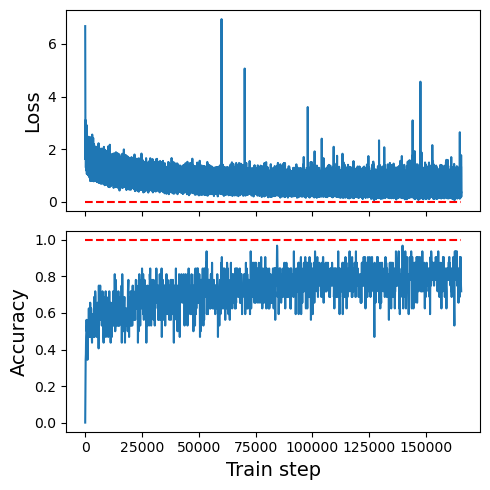

In [34]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

In [37]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu')
    

# Plotting results

In [38]:
from survey_ops.utils.geometry import angular_separation


## First, visualize healpix's gridding and actual ra, dec of observed fields

In [39]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [40]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

/tmp/ipykernel_13726/415551787.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)


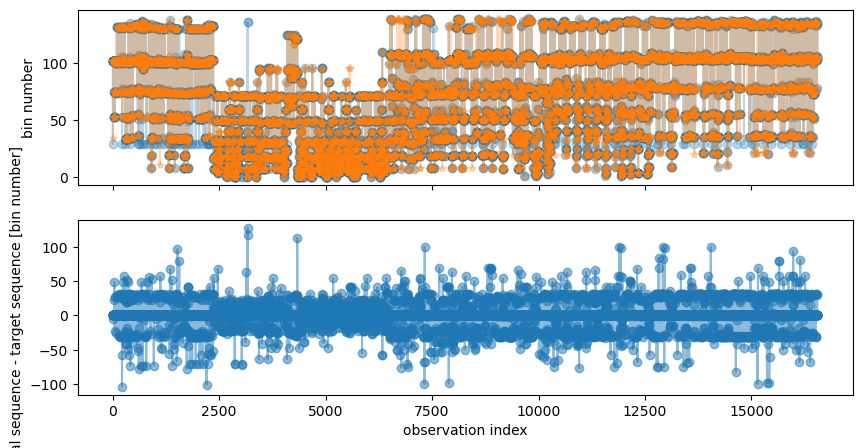

In [41]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(eval_sequence, marker='o', alpha=.3)
axs[0].plot(target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence [bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

In [42]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2015],
    specific_months=[12],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

In [43]:
with torch.no_grad():
    test_q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    test_eval_actions = torch.argmax(test_q_vals, dim=1).to('cpu')

test_target_sequence = test_dataset.actions.detach().numpy()
test_eval_sequence = test_eval_actions.detach().numpy()

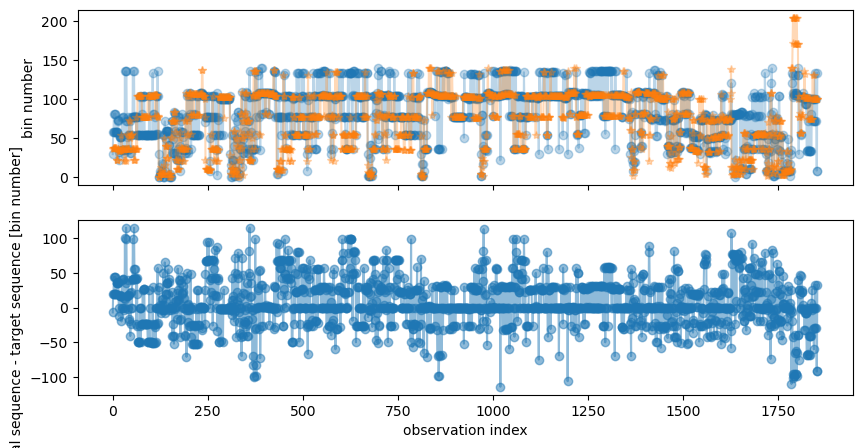

In [44]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(test_eval_sequence, marker='o', alpha=.3)
axs[0].plot(test_target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(test_eval_sequence - test_target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence [bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'test_eval_and_target_bin_sequences.png')